In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

/tmp/ipykernel_50890/1256517549.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import numpy as np
from tqdm import tqdm as tqdm
#from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
import optparse
import os.path as osp
import math
import torch_geometric
import torch
import sys
from torch_geometric.data import Data
import glob


from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import torch.jit as jit

In [3]:
# tt=torch.load("/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/ntup_pho_18082024/data_499.pt")
# np.unique(tt[0].clus2d_feat[:,5])

In [4]:
#########################################
# clus2d_feats = np.stack((ak.to_numpy(sel_clusters[ts].position_x),
#                          ak.to_numpy(sel_clusters[ts].position_y),
#                          ak.to_numpy(sel_clusters[ts].position_z),
#                          ak.to_numpy(sel_clusters[ts].energy),
#                          ak.to_numpy(sel_clusters[ts].cluster_time),
#                          ak.to_numpy(sel_clusters[ts].cluster_layer_id))).T

#                     #print(clus2d_feats.shape)
# clus3d_feats = np.stack((sel_tseta[ts][0],
#                          sel_tsphi[ts][0],
#                          sel_tsen[ts][0],
#                          sel_tst[ts][0],
#                          min(ak.to_numpy(sel_clusters[ts].cluster_layer_id)),
#                          max(ak.to_numpy(sel_clusters[ts].cluster_layer_id)))).T
# gun_feats = np.stack((sel_cpeta[ts][0],
#                       sel_cpphi[ts][0],
#                       sel_cpen[ts][0],
#                       sel_cpent[ts][0], 
#                       sel_ratem[ts][0]    trk_em/ sim_em
#                       sel_rattot[ts][0]   trk/sim
#                        )).T
########################################

In [5]:
from torch.utils.data import Dataset

class ClassificationDataset(Dataset):
    def __init__(self, datapath, numLC, feats, signal, ispi, abz):
        self.datapath_ = datapath
        self.numLC_ = numLC
        self.signal_ = signal
        self.ispi_ = ispi
        self.abz_ = abz
        self.feats_ = feats
        self.process = self.load_datafiles(self.datapath_)
        self.data = torch.stack(self.process[0],dim=0)
        self.labels = torch.stack(self.process[1],dim=0)
        self.masks = torch.stack(self.process[2],dim=0)
        self.info3d = torch.stack(self.process[3],dim=0)
        self.infogun = torch.stack(self.process[4],dim=0)


    def load_datafiles(self, filepath) :
        "filepath of the form /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_DATA/ntup_pho_frac0p8/ "
        print("processing files from:",filepath)
        filelist = [filen for filen in glob.glob(filepath+'data*.pt')]
        output_tensor_list = []
        label = []
        mask_tensor_list = []
        info3d_tensor_list = []
        infogun_tensor_list = []
        
        ctot = 0
        cll = 0
        
        
        for i in tqdm(filelist):
            if (len(label)>50000):
                    break
            
            for filei in torch.load(i) :
                ctot += 1
                #print(filei.gun_feat)
                passpi = False
                passpu = False
                nlay = len(np.unique(filei.clus2d_feat[:,5]))
                ratrec_true = (filei.clus3d_feat[2]/filei.gun_feat[:,3]).item()

                if (self.signal_):
#                    if (nlay < 13) :
                    if (ratrec_true < 0.7):
                        cll += 1                        
                        continue
                else:
                    feat2da = filei.clus2d_feat
                    fracen26 = torch.sum(feat2da[feat2da[:,5] <=26][:,3])/torch.sum(feat2da[:,3])
                    if self.ispi_:
                        #if (nlay > 10)and(fracen26 > 0.7)and(min(feat2da[:,5]) < 15) :
                        passpi = True
                        if not(passpi):
                            cll += 1
                            continue
                        #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay , fracen26)
                    else:
                        #if ((nlay < 10)and(fracen26 < 0.7))or ((nlay > 10)and(fracen26 < 0.7)) or ((nlay < 10)and(fracen26 > 0.7)):
                        #if not((nlay > 10)and(fracen26 > 0.7)and(min(feat2da[:,5]) < 15)):
                        if not((nlay > 10)and(fracen26 > 0.6)and(min(feat2da[:,5]) < 15)and((np.average(filei.clus2d_feat[:,2], weights=filei.clus2d_feat[:,3])) < 360)):
                            passpu = True
                        else:
                            pass
                            #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay, fracen26)
                        if not(passpu):
                            cll += 1
                            continue
                        #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay, fracen26)
               
                
                
                
                
                
                optensor = self.transform_data(filei.clus2d_feat, self.numLC_)
                output_tensor_list.append(optensor[0])
                mask_tensor_list.append(optensor[1])
                info3d_tensor_list.append(filei.clus3d_feat[[0,1,2,4,5]])
                infogun_tensor_list.append(filei.gun_feat)
                if self.signal_:
                    label.append(torch.ones(1,dtype=torch.double))
                else:
                    label.append(torch.zeros(1,dtype=torch.double))
         
        
        print ("nskipped | ntotal:",cll," | ",ctot)
        return output_tensor_list, label, mask_tensor_list, info3d_tensor_list, infogun_tensor_list
                
    def transform_data(self, tensor, nLC) :            

        #feats = [0,1,2,5]
        target = torch.zeros(nLC, len(self.feats_))
        mask0 = torch.ones(nLC)
        source = tensor[:nLC,self.feats_]
        mask1 = torch.zeros(source.shape[0])
        if self.abz_:
            source[:,2] = np.abs(source[:,2])
        target[:source.shape[0], :] = source
        #source = source.T
        mask0[:source.shape[0]] = mask1
        mask0 
        #print(mask0)
        return target, mask0 > 0
    
        
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx): 
        return self.data[idx], self.labels[idx], self.masks[idx], self.info3d[idx], self.infogun[idx]

In [6]:
pho_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rmin_pho_30072024/"
pho_dataset = ClassificationDataset(pho_path, 150, [0,1,5,3], True, False, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rmin_pho_30072024/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 32.30it/s]


nskipped | ntotal: 119  |  50000


In [7]:
lowptpho_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rmin_pho2to15_27092024/"
lowptpho_dataset = ClassificationDataset(lowptpho_path, 150, [0,1,5,3], True, False, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rmin_pho2to15_27092024/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:09<00:00, 33.03it/s]


nskipped | ntotal: 589  |  30000


In [8]:
hizpu_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2R0p9_pi_30072024/"
hizpu_dataset = ClassificationDataset(hizpu_path, 150, [0,1,5,3], False, False, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2R0p9_pi_30072024/


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 484/500 [00:36<00:01, 13.33it/s]


nskipped | ntotal: 20625  |  70628


In [9]:
lowzpu_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rno_PUenrich_05082024/"
lowzpu_dataset = ClassificationDataset(lowzpu_path, 150, [0,1,5,3], False, True, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rno_PUenrich_05082024/


 17%|███████████████████▌                                                                                                 | 1/6 [00:42<03:31, 42.36s/it]


nskipped | ntotal: 0  |  95549


In [10]:
print("lenpho:",len(pho_dataset), " lenhizpu:",len(hizpu_dataset), " lenlozpu:",len(lowzpu_dataset), " lenlowptpho:",len(lowptpho_dataset))

lenpho: 49881  lenhizpu: 50003  lenlozpu: 95549  lenlowptpho: 29411


In [11]:
nphos_high = len(pho_dataset)
nphos_low = len(lowptpho_dataset)
nphos_tot = int(1.3 * nphos_high) # tot number of photons = high pt pho + 30% low pt pho
idxstotsamp = np.arange(nphos_tot)
lowptpho = torch.utils.data.Subset(lowptpho_dataset, idxstotsamp[:int(0.3*nphos_high)]) #low pt photons: 30% of high pt photons 
hizpusel = torch.utils.data.Subset(hizpu_dataset, idxstotsamp[:int(0.3*nphos_tot)])
lowzpusel = torch.utils.data.Subset(lowzpu_dataset, idxstotsamp[:int(0.7*nphos_tot)])
#npusel = len(pho_dataset) - len(pisel)
#pusel = torch.utils.data.Subset(pu_dataset, idxstotsamp[:int(npusel)])

combdataset = torch.utils.data.ConcatDataset([pho_dataset, lowptpho, hizpusel, lowzpusel])

nsamp = len(combdataset)

idxs = np.arange(nsamp)
np.random.shuffle(idxs)
tridx = idxs[:int(0.8*nsamp)]
tsidx = idxs[int(0.8*nsamp):nsamp]
trdata = torch.utils.data.Subset(combdataset, tridx)
tsdata = torch.utils.data.Subset(combdataset, tsidx)

ntrainbatch = 600
trainloader = torch.utils.data.DataLoader(trdata, batch_size=ntrainbatch ,shuffle=True)#, num_workers=2)
testloader = torch.utils.data.DataLoader(tsdata, batch_size=ntrainbatch,shuffle=True)#, num_workers=2)


print("total samples > nphohigh | nlowpho | nphotot | nhizpu | nlozpu | nTOT:",
      len(pho_dataset)," | ",len(lowptpho)," | ",nphos_tot," | ",len(hizpusel)," | ",len(lowzpusel)," | ",nsamp)
print("N_train, N_test:",len(trdata),",",len(tsdata))

print(idxs)

total samples > nphohigh | nlowpho | nphotot | nhizpu | nlozpu | nTOT: 49881  |  14964  |  64845  |  19453  |  45391  |  129689
N_train, N_test: 103751 , 25938
[ 94803 116836 110378 ...   6921 120833   8805]


In [12]:
# test
nphos_tot + len(hizpusel) +len(lowzpusel)

129689

In [13]:
## Define model
## refer https://github.com/ludovicobuizza/HAR-Transformer/blob/main/src/transformer/transformer.py for batchnorm
import torch.nn as nn
import torch.nn.functional as F

class MHA_model(jit.ScriptModule):
    

    def __init__(
        self,
        input_dim = 6,
        dim_emb = 64,
        n_heads = 16,
        num_enclayers = 6,
        dim_feedforward = 64,
        n_seq = 150,
        output_dim = 2,
        norm=torch.tensor([1./100., 1./100., 1./100., 1./100.]),
    ):
        
        super(MHA_model, self).__init__()
        self.datanorm = nn.Parameter(norm, requires_grad=False) 
        self.emb_inp = nn.Sequential(
            nn.Linear(input_dim, dim_emb),
            nn.Dropout(0.3),
            nn.ELU(),
            #nn.LeakyReLU(negative_slope=0.4),
            nn.Linear(dim_emb, dim_emb),
            nn.Dropout(0.3),
#            nn.LeakyReLU(negative_slope=0.4),
#            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ELU(),
            #nn.LeakyReLU(negative_slope=0.4),
        )
        
#        self.emb_inp =  nn.Linear(input_dim, dim_emb)      
        encoder_layer = nn.TransformerEncoderLayer(
                dim_emb,
                n_heads,
                dim_feedforward,
                dropout = 0.3,
                batch_first= True,
                activation=nn.ELU(),  #nn.LeakyReLU(negative_slope=0.4),
            )
        
        
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_enclayers)
        
        self.output_layer = nn.Sequential(nn.Linear(n_seq*dim_emb + 5, dim_emb//2),
                                    
                                    #nn.LeakyReLU(negative_slope=0.4),
                                    nn.Dropout(0.3),
                                    nn.ELU(),
                                    #nn.Softplus(),
                                    nn.Linear(dim_emb//2, dim_emb//2),#added
                                    nn.Dropout(0.3),
                                    nn.ELU(),
                                    nn.Linear(dim_emb//2, dim_emb//2),#added
                                    nn.Dropout(0.3),
                                    nn.ELU(),
                                    #nn.Softplus(),
                                    nn.Linear(dim_emb//2, output_dim)
                                   )
    
    
    @jit.script_method
    def forward(self, X, mask, info3d) :
        
        
        #project input to dim_emb dimensional space
        X = self.datanorm*X
        inp = self.emb_inp(X) #* math.sqrt(self.dim_embed)
        
        output = self.transformer_encoder(inp, src_key_padding_mask=mask)  # (batch, seq, feat)
        output = output.reshape(output.shape[0], -1)  # (batch, seq * feat)
        output = torch.concat((output,info3d), dim = -1)
        output = self.output_layer(output)  # (batch, num_classes)

        return F.log_softmax(output, dim=-1)

In [14]:
### define training and testing functions
#from lr_modulation import *
device = torch.device('cuda:0')#('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
#model = NetCNN().to(float) ### change to NetDNN().to(float) for DNN
#model = model.to(device)


model = MHA_model(n_seq=150,
        input_dim = 4,
        dim_emb = 16,#32
        n_heads = 16,
        num_enclayers = 6,#4
        dim_feedforward = 64,
        output_dim = 2)


model = model.to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
#scheduler = CyclicLRWithRestarts(optimizer, ntrainbatch, epoch_size, restart_period=10, t_mult=1.2, policy="cosine")
#scheduler = CyclicLRWithRestarts(optimizer, 200, 200, restart_period=30, t_mult=1.2, policy="cosine")
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,50)
#lossfunction = nn.BCELoss()



def train(epoch):
    model.train()
    torch.cuda.empty_cache()
    loss = []
    true_preds, num_preds = 0., 0.
    iters = len(trainloader)
    cc = 0
    for data in tqdm(trainloader):  ### change to loaderDNN for DNN
            #datax, label = data[0].to(device), data[1].to(device)
            datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
            label = label.to(torch.long).squeeze()
            optimizer.zero_grad()
            result = model(datax, masks, info3d)
            #print(result)
            
            #print(label)
            #print(result.dtype)
            #lossc = lossfunction(result, label)
            lossc = F.nll_loss(result, label)
            
            loss.append(lossc.item()) 
            lossc.backward()
            optimizer.step()
            scheduler.step(epoch + cc / iters)
            cc += 1
            pred_labels = torch.argmax(result.cpu(), dim=-1) 
            true_preds += (pred_labels == label.cpu()).sum()
            num_preds += label.shape[0]
            
    acc = true_preds / num_preds
    #print( 'batches for train:',len(loss)) 
    print('train loss:',np.mean(np.array(loss)))
    print('train acc:',np.mean(np.array(acc)))
    return np.mean(np.array(loss)), np.array(acc)


def test(epoch):
    model.eval()
    loss = []
    true_preds, num_preds = 0., 0.
    for data in tqdm(testloader): ### change to loaderDNN for DNN
            datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)            
            label = label.to(torch.long).squeeze()
            result = model(datax, masks, info3d)
            lossc = F.nll_loss(result, label)
            loss.append(lossc.item())
            
            pred_labels = torch.argmax(result.cpu(), dim=-1) 
            true_preds += (pred_labels == label.cpu()).sum()
            num_preds += label.shape[0]
            
            
    acc = true_preds / num_preds
    #print( 'batches for train:',len(loss)) 
    print('test loss:',np.mean(np.array(loss)))
    print('test acc:',np.mean(np.array(acc)))
    return np.mean(np.array(loss)), np.array(acc)

/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/jit/_recursive.py:266: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


epoch: 0
Learning rate: 0.001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:42<00:00,  4.08it/s]


train loss: 0.48097452831406123
train acc: 0.782431


  0%|                                                                                                                            | 0/44 [00:00<?, ?it/s]/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/nn/modules/module.py:1501: UserWarning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
 (Triggered internally at ../third_party/nvfuser/csrc/manager.cpp:335.)
  return forward_call(*args, **kwargs)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 13.42it/s]


test loss: 0.2412184950980273
test acc: 0.8979875
new best acc: 0.8979875
epoch: 1
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.51it/s]


train loss: 0.26663623388447516
train acc: 0.8919239


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.91it/s]


test loss: 0.19143142280253497
test acc: 0.91653174
new best acc: 0.91653174
epoch: 2
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.24it/s]


train loss: 0.21558386673127986
train acc: 0.91343695


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.50it/s]


test loss: 0.17917889932339842
test acc: 0.9310664
new best acc: 0.9310664
epoch: 3
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.20454596448151363
train acc: 0.9196827


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.20it/s]


test loss: 0.1753540619869124
test acc: 0.9298327
epoch: 4
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.1917615137520553
train acc: 0.92438626


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.00it/s]


test loss: 0.18504104390740395
test acc: 0.93075794
epoch: 5
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.18315019204437388
train acc: 0.92806816


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.05it/s]


test loss: 0.21106093376874924
test acc: 0.9258231
epoch: 6
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.17732010773151596
train acc: 0.93067056


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.99it/s]


test loss: 0.15683539008552377
test acc: 0.94166857
new best acc: 0.94166857
epoch: 7
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.1756542887474071
train acc: 0.9318657


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.41it/s]


test loss: 0.2425909201529893
test acc: 0.92759657
epoch: 8
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.17196668757696373
train acc: 0.9329067


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.05it/s]


test loss: 0.21390593593770807
test acc: 0.934729
epoch: 9
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.17056553130377236
train acc: 0.93403435


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.46it/s]


test loss: 0.30502743036909535
test acc: 0.91317755


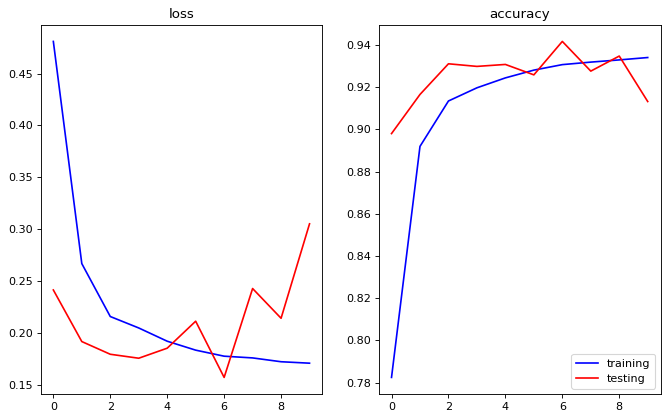

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.95it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


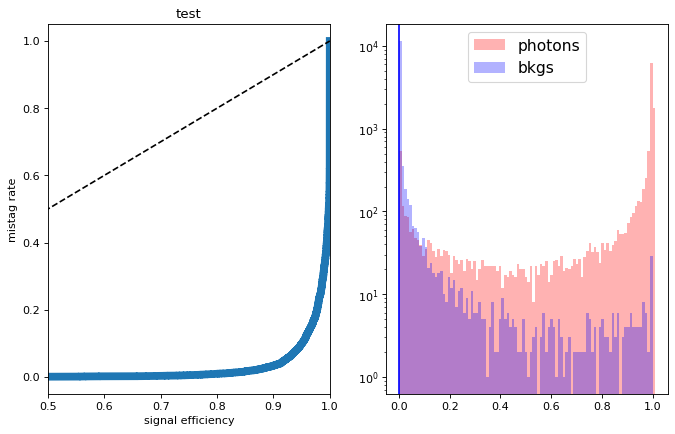

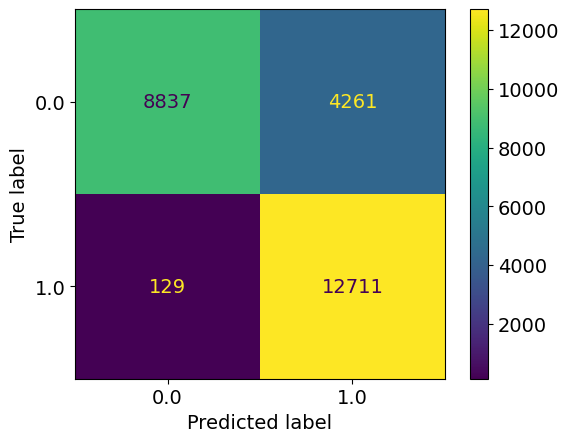

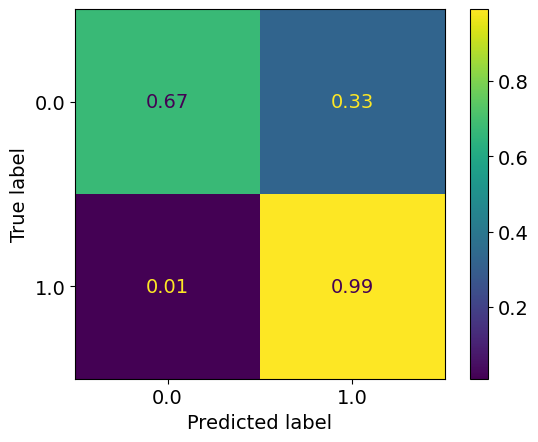

epoch: 10
Learning rate: 0.0009046152093405279


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.16640343168222835
train acc: 0.93546087


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.14589940062300724
test acc: 0.94706607
new best acc: 0.94706607
epoch: 11
Learning rate: 0.000885372348954578


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.16758805750250128
train acc: 0.93560547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.2793438644571738
test acc: 0.92327857
epoch: 12
Learning rate: 0.0008646085999671836


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.1650046040815425
train acc: 0.93618375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.25979670272632077
test acc: 0.9238569
epoch: 13
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.16274128156590323
train acc: 0.9373693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.2935212776064873
test acc: 0.9213509
epoch: 14
Learning rate: 0.0008188518951657368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.1616823350246242
train acc: 0.93706083


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.82it/s]


test loss: 0.2532907886938615
test acc: 0.933341
epoch: 15
Learning rate: 0.0007940395201612855


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.16176575538567725
train acc: 0.9371572


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.05it/s]


test loss: 0.24637573991309514
test acc: 0.9260159
epoch: 16
Learning rate: 0.0007680667055046367


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.15842217077754137
train acc: 0.9382367


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.60it/s]


test loss: 0.20667490126057106
test acc: 0.9330712
epoch: 17
Learning rate: 0.0007410359540293891


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.15890414452966237
train acc: 0.9375813


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.99it/s]


test loss: 0.22766561095010152
test acc: 0.9356928
epoch: 18
Learning rate: 0.0007130539437624405


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.15716266657920241
train acc: 0.9395572


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.36it/s]


test loss: 0.17539901286363602
test acc: 0.93962526
epoch: 19
Learning rate: 0.0006842311069145497


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.51it/s]


train loss: 0.15747824048548076
train acc: 0.93951863


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.94it/s]


test loss: 0.25405701486901805
test acc: 0.93206877


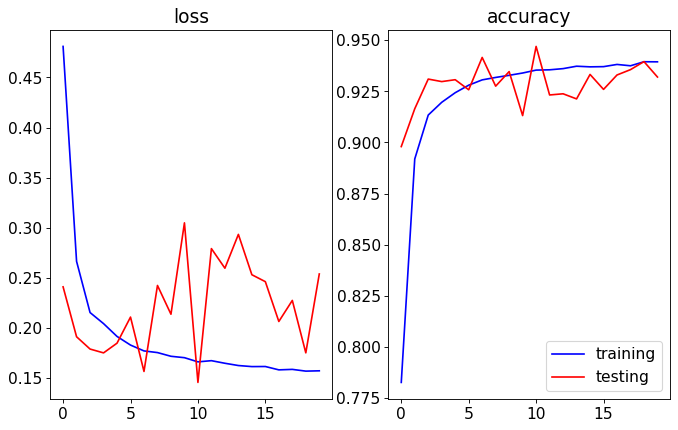

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.05it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


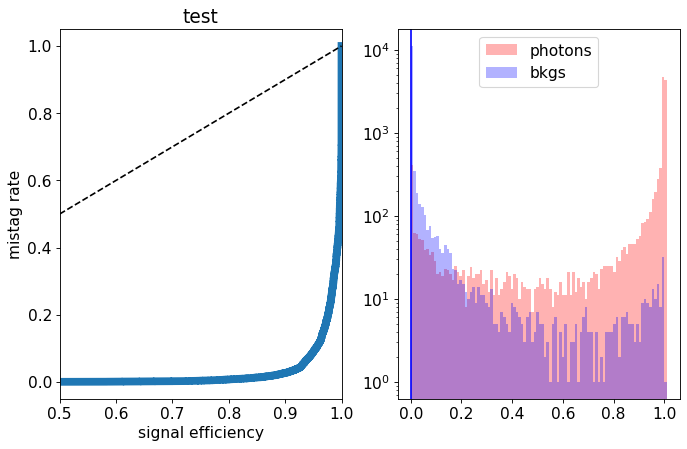

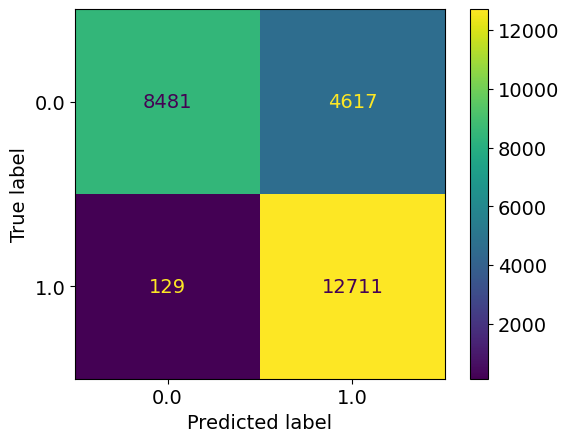

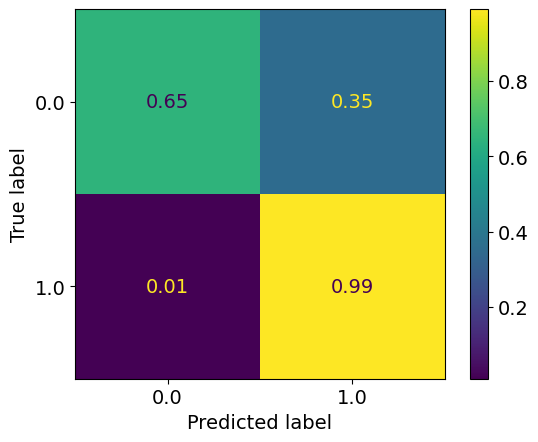

epoch: 20
Learning rate: 0.0006546811940548538


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.15911488243610183
train acc: 0.9388632


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.94it/s]


test loss: 0.2785019740800966
test acc: 0.92771226
epoch: 21
Learning rate: 0.0006245208251893391


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.1566084761581669
train acc: 0.9391524


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.96it/s]


test loss: 0.2204516279426488
test acc: 0.9402421
epoch: 22
Learning rate: 0.0005938690295149558


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.15556970398033285
train acc: 0.9393355


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.99it/s]


test loss: 0.1909106204455549
test acc: 0.9399337
epoch: 23
Learning rate: 0.0005628467756657573


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.15478111252274818
train acc: 0.94052106


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.97it/s]


test loss: 0.3265914629128846
test acc: 0.9272882
epoch: 24
Learning rate: 0.0005315764943049666


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.15267115891668837
train acc: 0.94004875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.18491547148336063
test acc: 0.9387385
epoch: 25
Learning rate: 0.0005001815949470823


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.15298592708358874
train acc: 0.9414078


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.81it/s]


test loss: 0.26235938715663826
test acc: 0.9345748
epoch: 26
Learning rate: 0.0004687859789169048


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.20it/s]


train loss: 0.15427725628621317
train acc: 0.9407235


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.29it/s]


test loss: 0.24187744002450595
test acc: 0.9289074
epoch: 27
Learning rate: 0.0004375135503676123


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.40it/s]


train loss: 0.1517626094077364
train acc: 0.94091624


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.23it/s]


test loss: 0.22109735282984647
test acc: 0.9323772
epoch: 28
Learning rate: 0.0004064877272876757


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.14931380305159297
train acc: 0.94171625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.25521668300709943
test acc: 0.9226617
epoch: 29
Learning rate: 0.00037583095442644083


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.1494498359243994
train acc: 0.9417066


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.00it/s]


test loss: 0.23177406632087447
test acc: 0.9306809


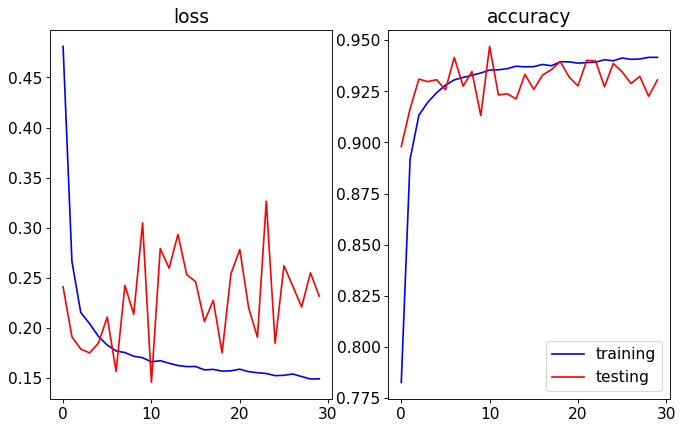

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.66it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


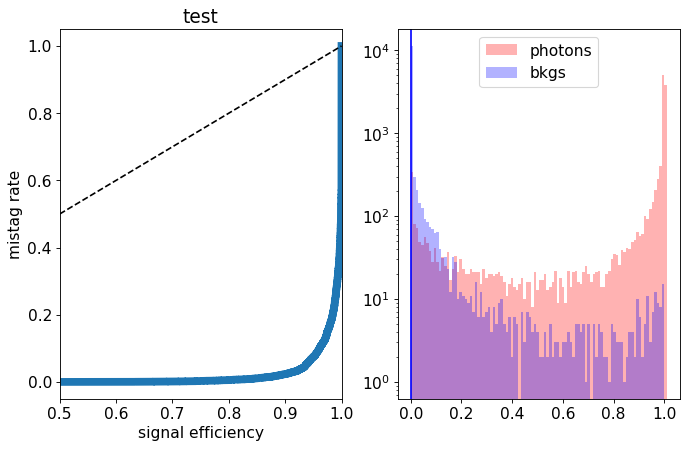

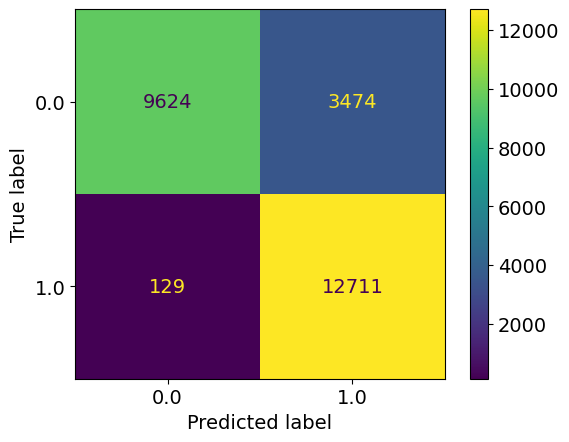

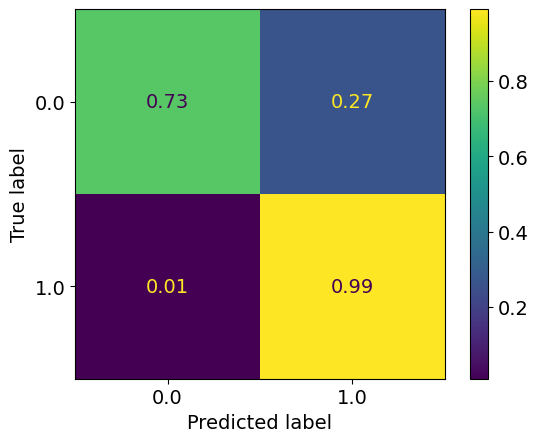

epoch: 30
Learning rate: 0.000345664220060644


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.14545023859064013
train acc: 0.9437114


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.89it/s]


test loss: 0.22203336452895944
test acc: 0.9336109
epoch: 31
Learning rate: 0.00031610657850895675


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.14603986595407387
train acc: 0.9431138


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.00it/s]


test loss: 0.2424504892392592
test acc: 0.93083507
epoch: 32
Learning rate: 0.00028727468027898187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.14365353874560727
train acc: 0.94385594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.27689070999622345
test acc: 0.92258465
epoch: 33
Learning rate: 0.00025928231170099157


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.14404605781239582
train acc: 0.9446463


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.2371941696513783
test acc: 0.93546146
epoch: 34
Learning rate: 0.0002322399458652666


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.14312421461578048
train acc: 0.9446656


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.73it/s]


test loss: 0.23738918622786348
test acc: 0.93434346
epoch: 35
Learning rate: 0.00020625430663527867


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.14238009575991273
train acc: 0.9447234


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.2777778066017411
test acc: 0.92894596
epoch: 36
Learning rate: 0.0001814279474573593


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.14118714897618817
train acc: 0.94475234


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.93it/s]


test loss: 0.22718461433594878
test acc: 0.9374277
epoch: 37
Learning rate: 0.00015785884662909916


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.14119170950671842
train acc: 0.94543666


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.23310786485671997
test acc: 0.93615544
epoch: 38
Learning rate: 0.0001356400206237693


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.13949160312297026
train acc: 0.9458704


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.3050590174441988
test acc: 0.9291387
epoch: 39
Learning rate: 0.00011485915699679673


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.27it/s]


train loss: 0.13951241784874416
train acc: 0.9460728


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.2336328039792451
test acc: 0.9339579


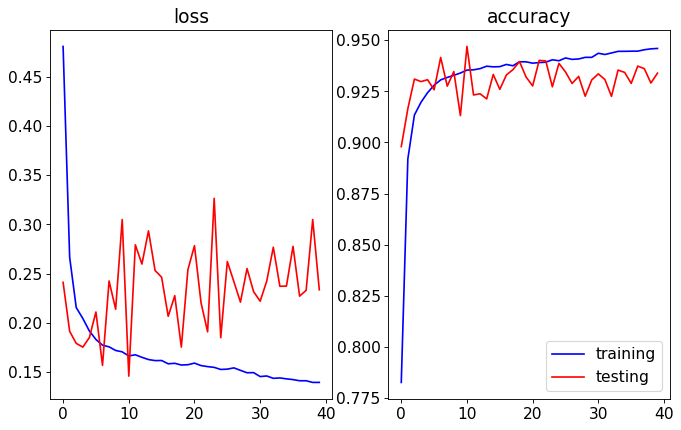

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


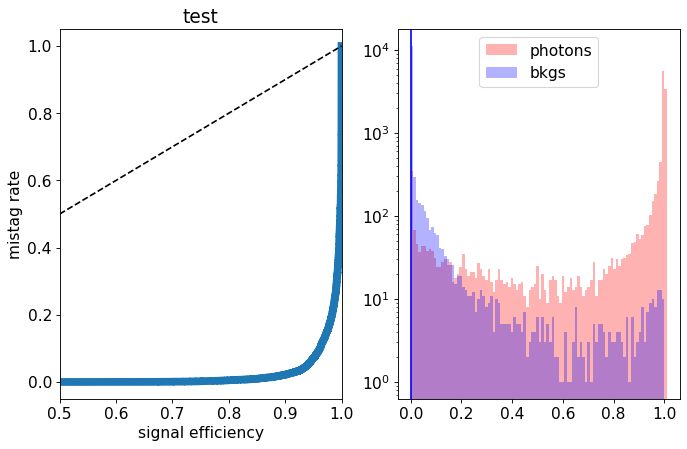

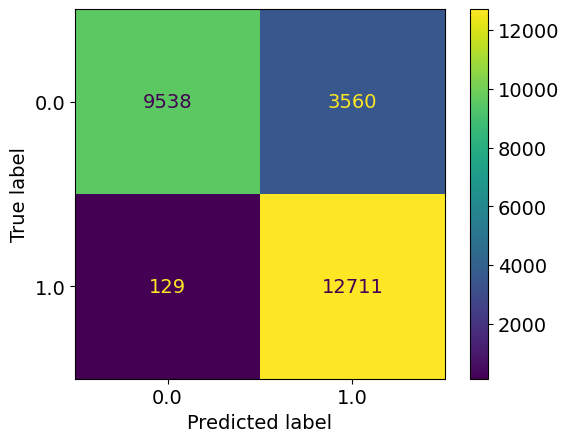

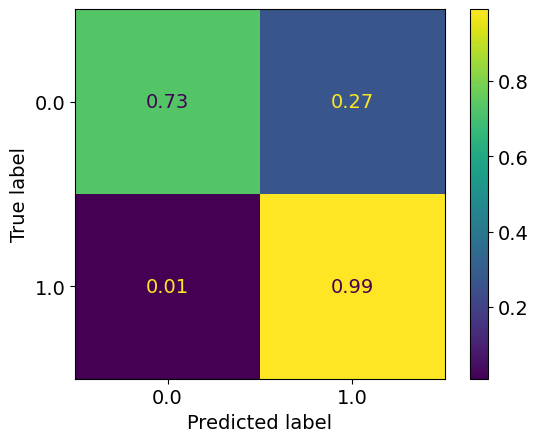

epoch: 40
Learning rate: 9.559826832304369e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.28it/s]


train loss: 0.13870856144352456
train acc: 0.94537884


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.81it/s]


test loss: 0.26903391392393544
test acc: 0.93206877
epoch: 41
Learning rate: 7.793336853064242e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.14003330051382154
train acc: 0.945321


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.28188149156895553
test acc: 0.9294857
epoch: 42
Learning rate: 6.193417290874859e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.13986692887682445
train acc: 0.94588006


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.92it/s]


test loss: 0.23906845904209398
test acc: 0.9324543
epoch: 43
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.1393832575120678
train acc: 0.94600534


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.88it/s]


test loss: 0.2502755079079758
test acc: 0.9317604
epoch: 44
Learning rate: 3.5178637275523064e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.1382632862367382
train acc: 0.9461114


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.2542018040337346
test acc: 0.9323001
epoch: 45
Learning rate: 2.4527889139894345e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.1384494226275152
train acc: 0.94636196


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.05it/s]


test loss: 0.2526367658918554
test acc: 0.93218446
epoch: 46
Learning rate: 1.5753612203285418e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.29it/s]


train loss: 0.1379642474082853
train acc: 0.9462463


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.23it/s]


test loss: 0.2445488040420142
test acc: 0.9325314
epoch: 47
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.42it/s]


train loss: 0.13731805308361275
train acc: 0.9464005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.78it/s]


test loss: 0.24381534145636993
test acc: 0.9330712
epoch: 48
Learning rate: 3.965441941372383e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.1370860839940909
train acc: 0.9460728


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.00it/s]


test loss: 0.25138172947547655
test acc: 0.9321459
epoch: 49
Learning rate: 9.980711385892405e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.13695737263026264
train acc: 0.9457258


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.01it/s]


test loss: 0.2516212256794626
test acc: 0.93218446


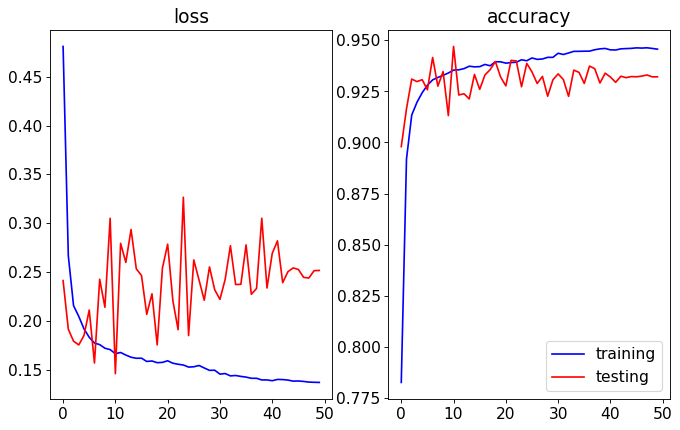

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.61it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


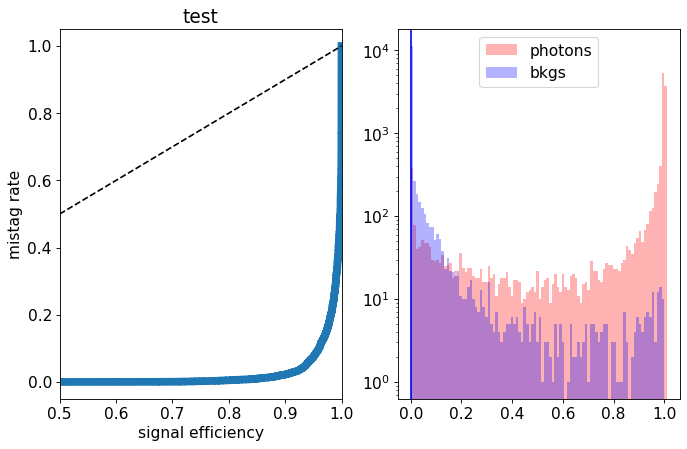

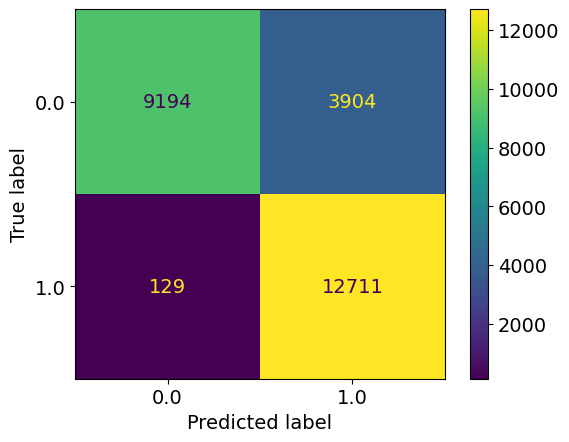

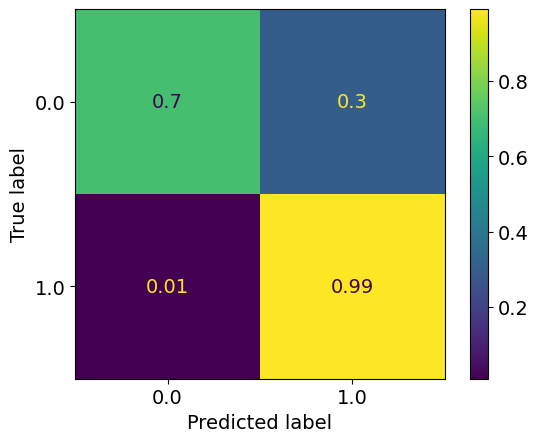

epoch: 50
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.38it/s]


train loss: 0.15149343272165067
train acc: 0.94064635


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.04it/s]


test loss: 0.328772672875361
test acc: 0.92979413
epoch: 51
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.28it/s]


train loss: 0.14538803834446593
train acc: 0.94313306


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.2323799134994095
test acc: 0.9324158
epoch: 52
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.14635557371240132
train acc: 0.94280535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.1642301224849441
test acc: 0.94378906
epoch: 53
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.27it/s]


train loss: 0.1432436677503448
train acc: 0.9442415


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.09it/s]


test loss: 0.29080510579726915
test acc: 0.9293315
epoch: 54
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.40it/s]


train loss: 0.14307315294453174
train acc: 0.9429596


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.19it/s]


test loss: 0.2616630056026307
test acc: 0.9348446
epoch: 55
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.26it/s]


train loss: 0.1413151478836302
train acc: 0.9448873


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.28683910078623076
test acc: 0.93257
epoch: 56
Learning rate: 0.0009649550618418059


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.14099244618346926
train acc: 0.9446945


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.02it/s]


test loss: 0.294722837141969
test acc: 0.93368804
epoch: 57
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.1407963688232306
train acc: 0.9443186


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.92it/s]


test loss: 0.4586176736788316
test acc: 0.91568357
epoch: 58
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.13903438325734496
train acc: 0.9451764


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.2471925582398068
test acc: 0.9273267
epoch: 59
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.14199639538119982
train acc: 0.94501257


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.99it/s]


test loss: 0.2860615009611303
test acc: 0.9224304


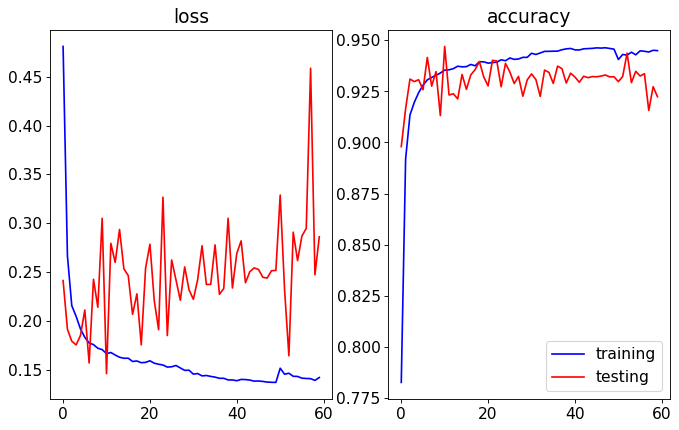

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.42it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


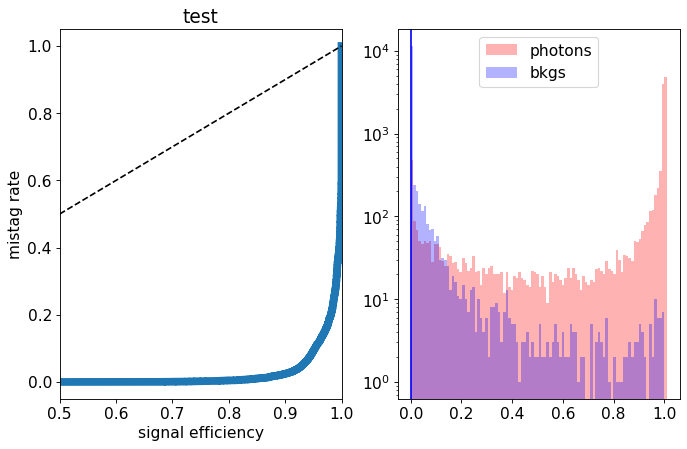

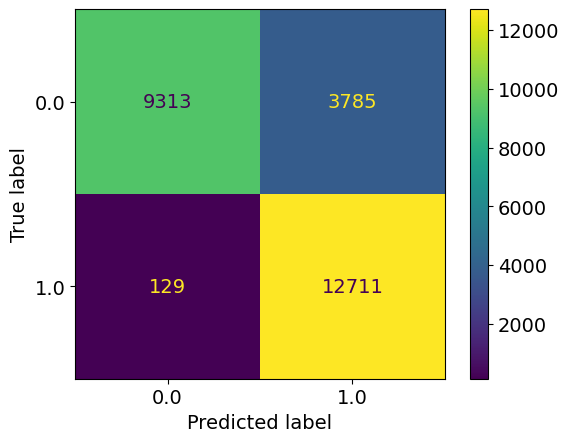

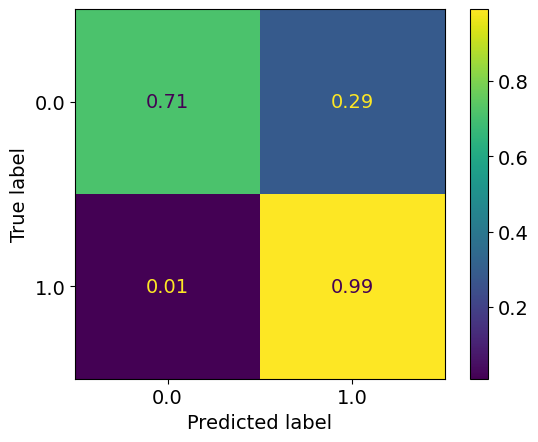

epoch: 60
Learning rate: 0.0009046152093405278


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.1384630361733409
train acc: 0.94653547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.87it/s]


test loss: 0.2770928860726682
test acc: 0.9274038
epoch: 61
Learning rate: 0.000885372348954578


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.13941521735894197
train acc: 0.94537884


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.82it/s]


test loss: 0.2779647863724015
test acc: 0.9205413
epoch: 62
Learning rate: 0.0008646085999671836


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.52it/s]


train loss: 0.14012275214140127
train acc: 0.9444439


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.22it/s]


test loss: 0.3172734857282855
test acc: 0.932223
epoch: 63
Learning rate: 0.0008424059074095433


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.13885429876215885
train acc: 0.9457933


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.1632952798496593
test acc: 0.9418999
epoch: 64
Learning rate: 0.0008188518951657367


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.13809354026193563
train acc: 0.9456969


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.99it/s]


test loss: 0.19836453466930173
test acc: 0.93411213
epoch: 65
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.13700895941670918
train acc: 0.9468632


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.19599357484416527
test acc: 0.93060374
epoch: 66
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.29it/s]


train loss: 0.1363811109624157
train acc: 0.94586074


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.89it/s]


test loss: 0.23851339620622722
test acc: 0.92736524
epoch: 67
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.13599304109811783
train acc: 0.9463523


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.25572962974282826
test acc: 0.92455083
epoch: 68
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.1372735897412879
train acc: 0.94585115


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.2972286848182028
test acc: 0.92408824
epoch: 69
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.1368484252450094
train acc: 0.9457933


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.2808408242734996
test acc: 0.9287532


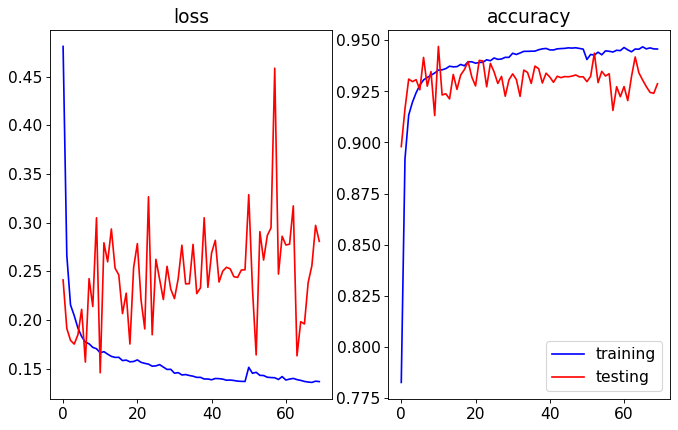

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.05it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


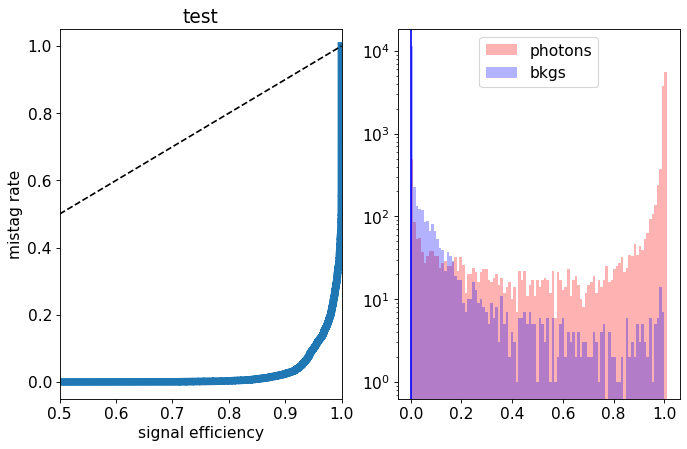

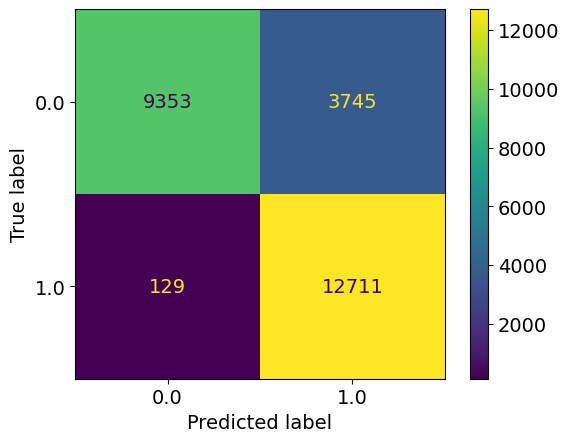

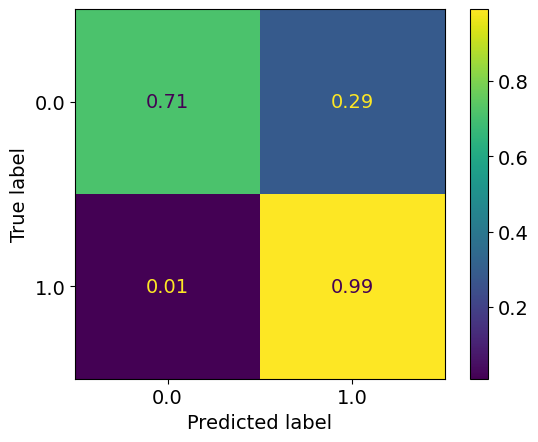

epoch: 70
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.13682666700871693
train acc: 0.9458126


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.24492852355946193
test acc: 0.921775
epoch: 71
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.13659195838808325
train acc: 0.9455909


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.3252355947413228
test acc: 0.9211196
epoch: 72
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.1369788128172042
train acc: 0.94681495


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.3476243970746344
test acc: 0.92262316
epoch: 73
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.13659629712387317
train acc: 0.9459571


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.74it/s]


test loss: 0.3256189684298905
test acc: 0.9251292
epoch: 74
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.13420651258760793
train acc: 0.9474222


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.87it/s]


test loss: 0.2647159251977097
test acc: 0.93168324
epoch: 75
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.13376244919837554
train acc: 0.9474608


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.27it/s]


test loss: 0.27692249180241063
test acc: 0.929023
epoch: 76
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.13314894194892377
train acc: 0.9471041


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.14it/s]


test loss: 0.29707222702828323
test acc: 0.92570746
epoch: 77
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.13410832319473256
train acc: 0.9472776


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.78it/s]


test loss: 0.26596400277181104
test acc: 0.9284062
epoch: 78
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.133668118043442
train acc: 0.94819325


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.2458427558568391
test acc: 0.9327242
epoch: 79
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.13477454778086934
train acc: 0.94615954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.76it/s]


test loss: 0.23654905097051102
test acc: 0.93168324


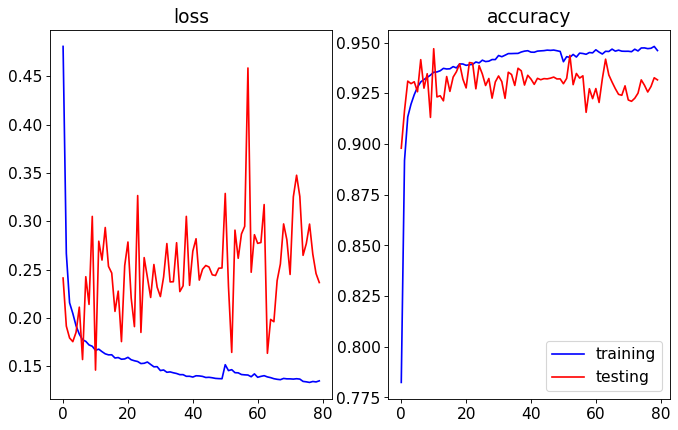

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.00it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


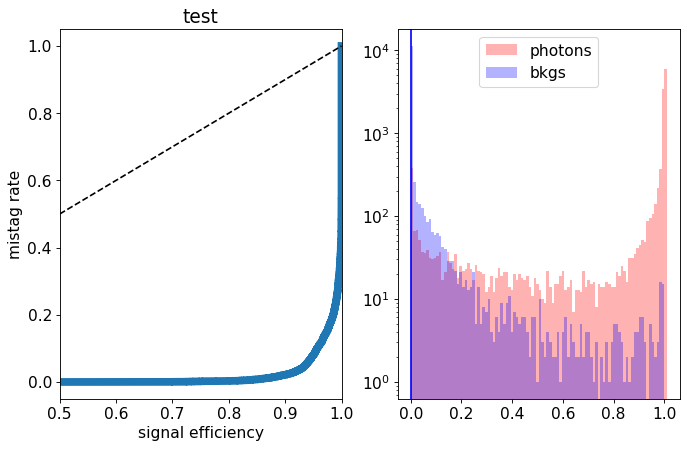

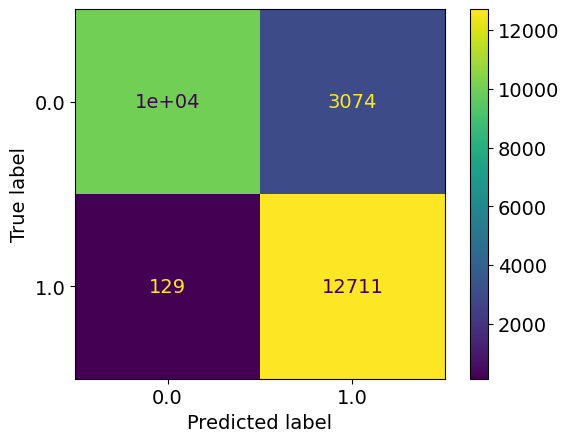

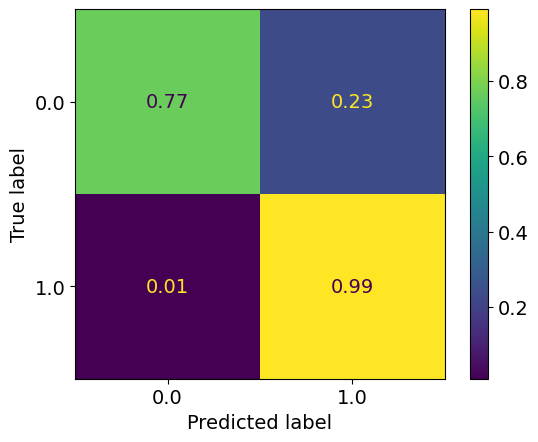

epoch: 80
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.13261476624218715
train acc: 0.9477306


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.28516908802769403
test acc: 0.923587
epoch: 81
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.13256535377633366
train acc: 0.9474029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.28122333166274155
test acc: 0.92644
epoch: 82
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.1321584603431597
train acc: 0.9475764


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.2875875945795666
test acc: 0.9257846
epoch: 83
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.13186700220052908
train acc: 0.94833785


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.2742283997887915
test acc: 0.9263243
epoch: 84
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.13036650457995475
train acc: 0.948627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.53it/s]


test loss: 0.31641941686922853
test acc: 0.92397255
epoch: 85
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.13129377679500967
train acc: 0.94813544


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.01it/s]


test loss: 0.2653040120547468
test acc: 0.92736524
epoch: 86
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.1317699556750369
train acc: 0.94774026


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.32it/s]


test loss: 0.26338477060198784
test acc: 0.92670983
epoch: 87
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.13022625713334607
train acc: 0.94818366


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.2689483528110114
test acc: 0.9287532
epoch: 88
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.1307488457229785
train acc: 0.9478752


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.2797862450507554
test acc: 0.93141335
epoch: 89
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.13099972442912228
train acc: 0.9487137


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.02it/s]


test loss: 0.2821992987936193
test acc: 0.92813635


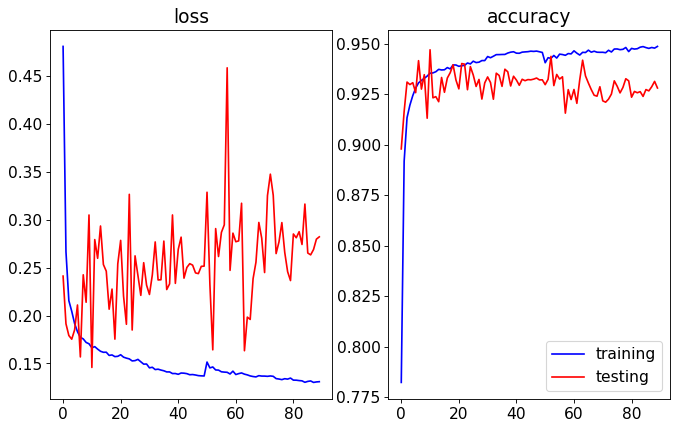

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


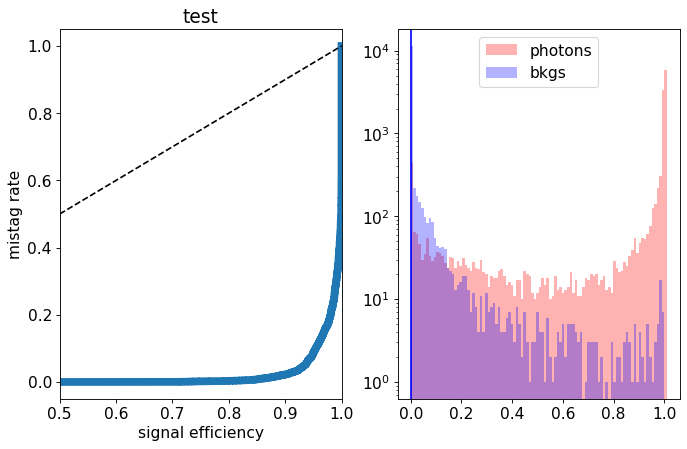

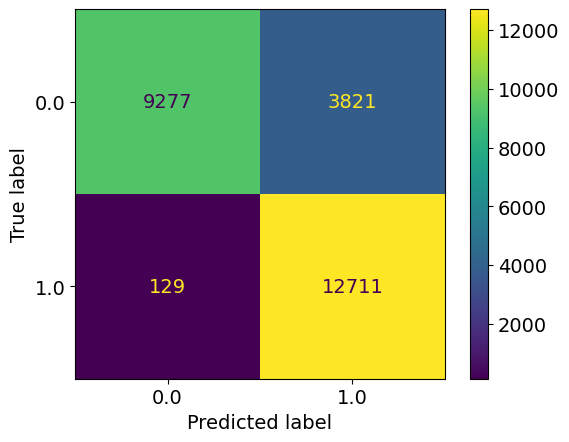

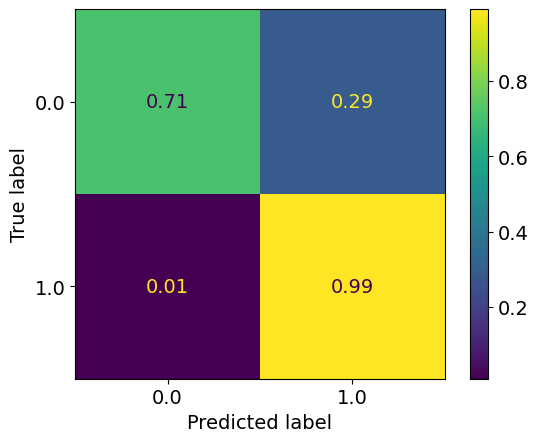

epoch: 90
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.29it/s]


train loss: 0.13090055655537314
train acc: 0.9480873


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.02it/s]


test loss: 0.2507991316643628
test acc: 0.927905
epoch: 91
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.12969575004081504
train acc: 0.94914746


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.2509146864441308
test acc: 0.9302182
epoch: 92
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.12899247031508154
train acc: 0.9485403


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.21it/s]


test loss: 0.26110985807397147
test acc: 0.92967844
epoch: 93
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.13084436195089638
train acc: 0.94795233


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.26850691640918906
test acc: 0.9263629
epoch: 94
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.12995668672929608
train acc: 0.9488776


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.88it/s]


test loss: 0.2881112389943816
test acc: 0.927905
epoch: 95
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.13000381557066318
train acc: 0.9487523


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.2886528897691857
test acc: 0.9263243
epoch: 96
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.13105025530033718
train acc: 0.94833785


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.05it/s]


test loss: 0.2655341655693271
test acc: 0.92886883
epoch: 97
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.1291737522434637
train acc: 0.9491089


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.36it/s]


test loss: 0.2811155668036504
test acc: 0.9268641
epoch: 98
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.12809422207361013
train acc: 0.94921494


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.23it/s]


test loss: 0.2784335406666452
test acc: 0.92751944
epoch: 99
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.13127553282101032
train acc: 0.9485981


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.66it/s]


test loss: 0.27407113022424956
test acc: 0.92748094


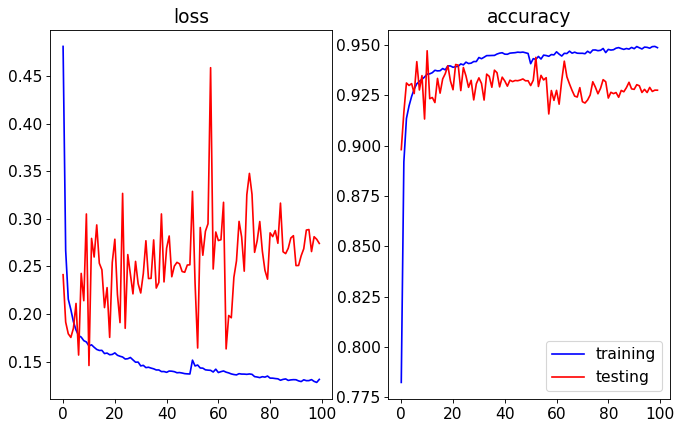

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


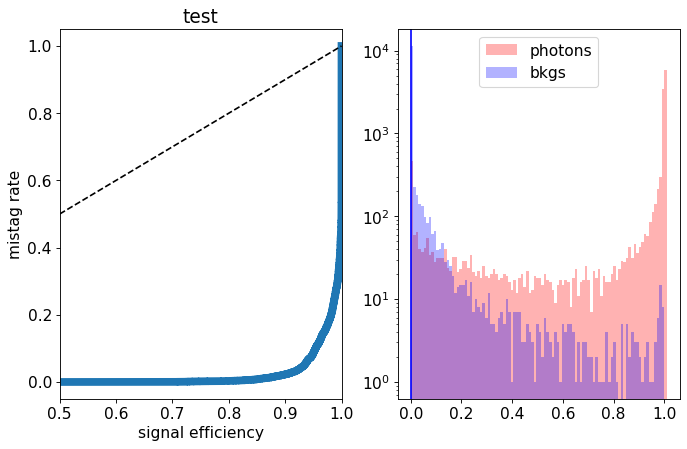

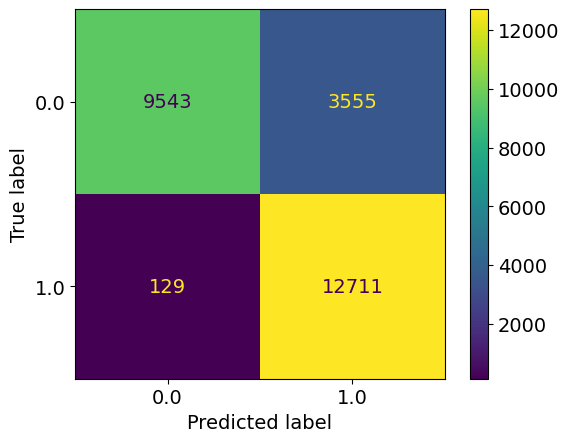

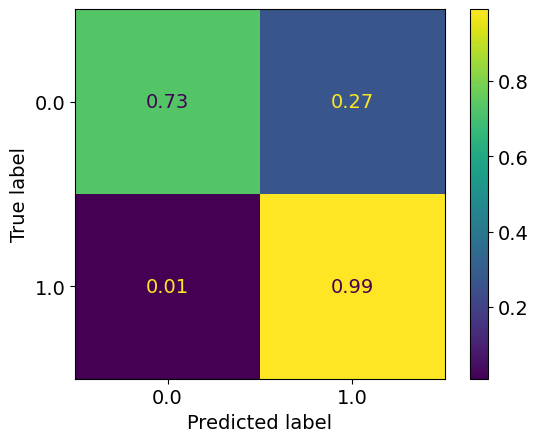

epoch: 100
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.13800647833271523
train acc: 0.9456487


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.02it/s]


test loss: 0.19644430990923534
test acc: 0.9280592
epoch: 101
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.13911310243124217
train acc: 0.9446367


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.36163474585522304
test acc: 0.91707146
epoch: 102
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.13593502652782924
train acc: 0.94585115


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.25505213236266916
test acc: 0.93075794
epoch: 103
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.1354426875968889
train acc: 0.9466993


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.21035819331353361
test acc: 0.93557715
epoch: 104
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.13677912735181047
train acc: 0.94513786


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.3379355777393688
test acc: 0.9270183
epoch: 105
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.13358185849437823
train acc: 0.9467186


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.87it/s]


test loss: 0.4006510932337154
test acc: 0.92331713
epoch: 106
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.13612355321990272
train acc: 0.94645834


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.42480513148687105
test acc: 0.9175341
epoch: 107
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.13490049898452153
train acc: 0.9461692


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.20it/s]


test loss: 0.22320252284407616
test acc: 0.93291694
epoch: 108
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.1339491099291454
train acc: 0.9467379


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.17it/s]


test loss: 0.2921631576662714
test acc: 0.92879176
epoch: 109
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.37it/s]


train loss: 0.13385666273749633
train acc: 0.9472776


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.22it/s]


test loss: 0.3040999197824435
test acc: 0.92925435


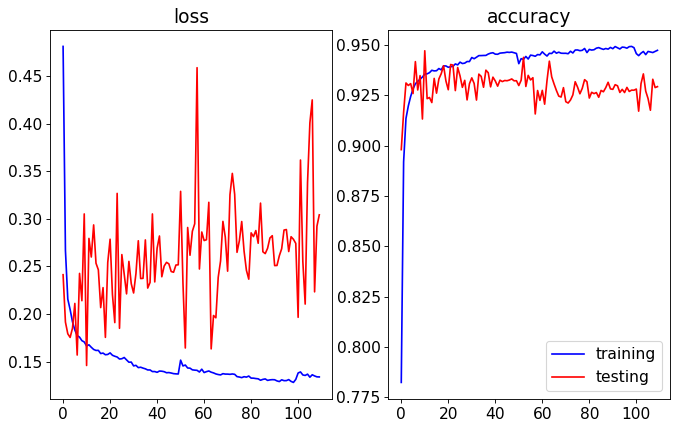

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.18it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


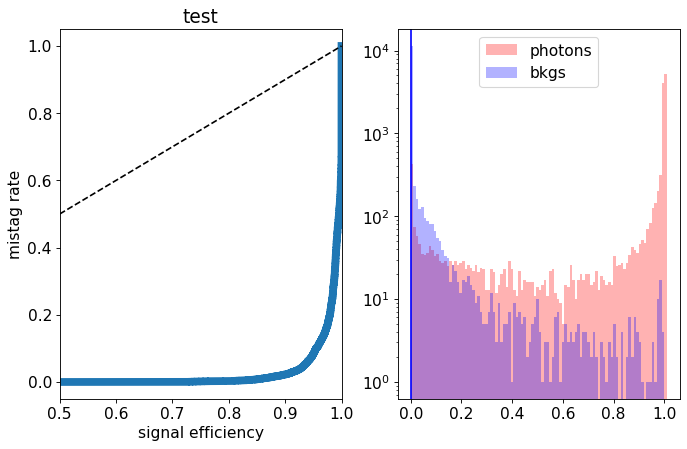

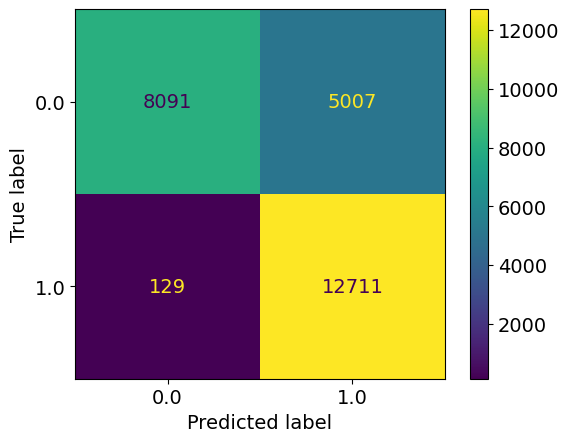

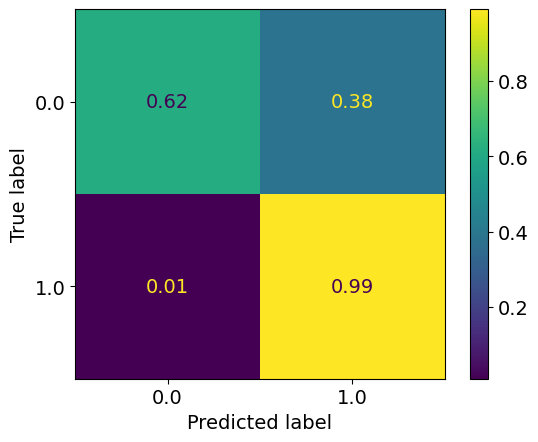

epoch: 110
Learning rate: 0.000904615209340528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.13345145761449903
train acc: 0.94684386


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.95it/s]


test loss: 0.31371993029659445
test acc: 0.91884494
epoch: 111
Learning rate: 0.0008853723489545782


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.13396180179939104
train acc: 0.94705594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.38201131468469446
test acc: 0.92057985
epoch: 112
Learning rate: 0.0008646085999671838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.13315465667344242
train acc: 0.9474897


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.23it/s]


test loss: 0.2587394677102566
test acc: 0.92975557
epoch: 113
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.58it/s]


train loss: 0.13325801564951165
train acc: 0.9471812


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.22it/s]


test loss: 0.2101477939974178
test acc: 0.9317604
epoch: 114
Learning rate: 0.0008188518951657369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.36it/s]


train loss: 0.1332015377076375
train acc: 0.94731617


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.3298715749247508
test acc: 0.9250906
epoch: 115
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.13361894046467854
train acc: 0.94753784


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]


test loss: 0.35688293792984704
test acc: 0.9186522
epoch: 116
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.13272795959704184
train acc: 0.94843423


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.21it/s]


test loss: 0.3897276222705841
test acc: 0.9166474
epoch: 117
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.58it/s]


train loss: 0.1333836402334919
train acc: 0.94755715


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.19it/s]


test loss: 0.3185198174958879
test acc: 0.9183052
epoch: 118
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.38it/s]


train loss: 0.1330854535275112
train acc: 0.9479041


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.21it/s]


test loss: 0.27422555265101517
test acc: 0.9280978
epoch: 119
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.13303002676350534
train acc: 0.94799083


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.3795965005728332
test acc: 0.9240111


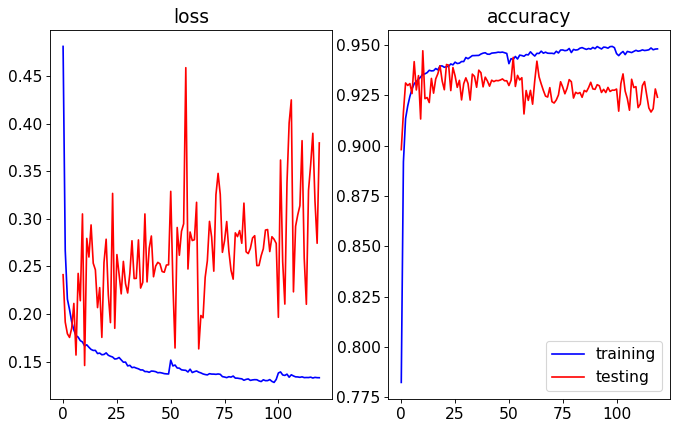

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.67it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


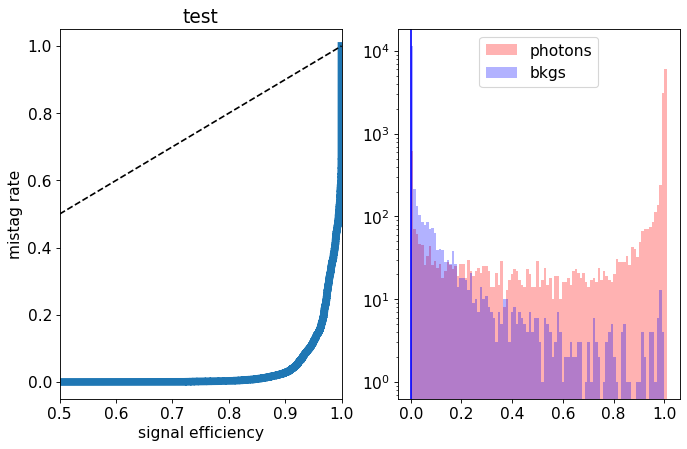

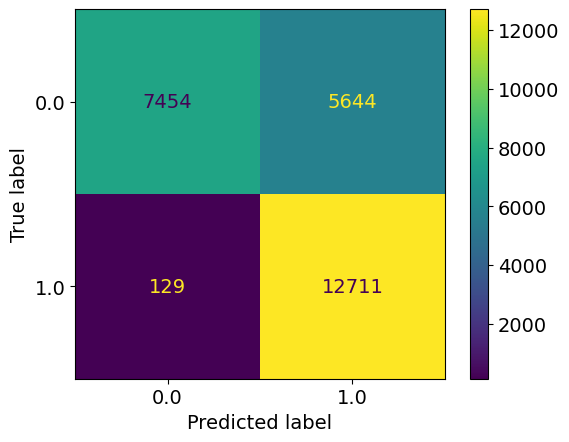

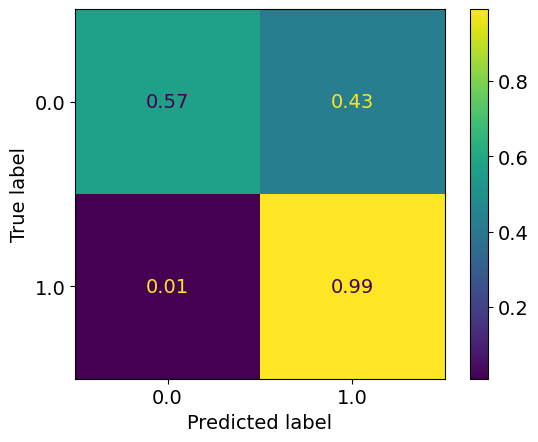

epoch: 120
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.13123478314091017
train acc: 0.94765353


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.41334877569567074
test acc: 0.9176498
epoch: 121
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.13023075896363728
train acc: 0.9483571


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.79it/s]


test loss: 0.3507108739153905
test acc: 0.92489785
epoch: 122
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.1314879812601674
train acc: 0.9481258


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.30915494059974497
test acc: 0.9213509
epoch: 123
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.23it/s]


train loss: 0.13046742135906494
train acc: 0.9479427


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.39it/s]


test loss: 0.32957188243215735
test acc: 0.917457
epoch: 124
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.47it/s]


train loss: 0.13190040939805137
train acc: 0.9482511


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.43it/s]


test loss: 0.3973128304562785
test acc: 0.922122
epoch: 125
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.25it/s]


train loss: 0.12986545738457256
train acc: 0.9482704


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.3231302686035633
test acc: 0.92223763
epoch: 126
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.12975715819983125
train acc: 0.94869447


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.99it/s]


test loss: 0.26365337961099367
test acc: 0.925399
epoch: 127
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.12894960841691563
train acc: 0.9485595


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.2321195290847258
test acc: 0.934035
epoch: 128
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.58it/s]


train loss: 0.12956830811810632
train acc: 0.949186


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.3384063812819394
test acc: 0.9218521
epoch: 129
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.22it/s]


train loss: 0.12900075238908645
train acc: 0.94879085


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.41it/s]


test loss: 0.33835198831829155
test acc: 0.92316294


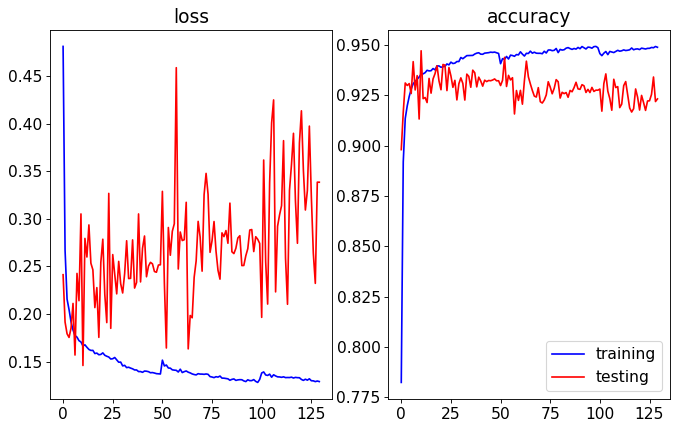

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.38it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


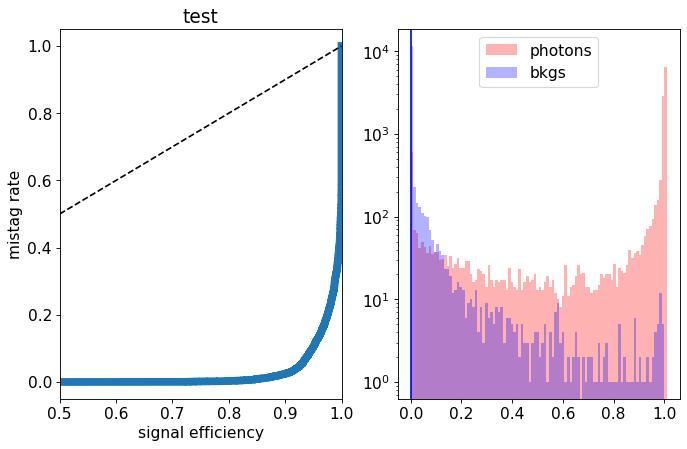

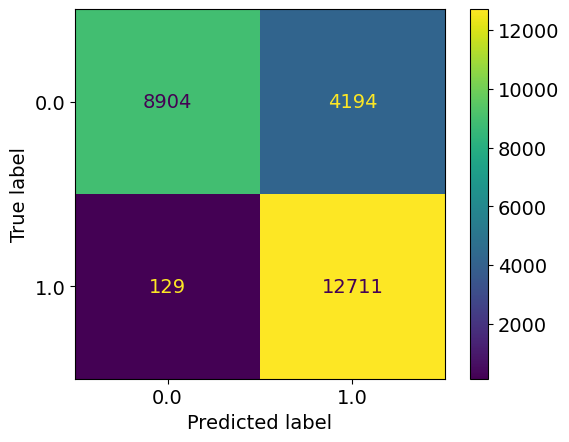

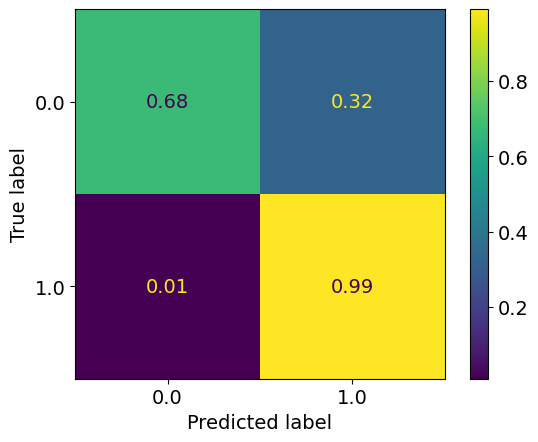

epoch: 130
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.12876799754324675
train acc: 0.94860774


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.28136117316105147
test acc: 0.92381835
epoch: 131
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.13074962153083328
train acc: 0.94828004


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.3692041059786623
test acc: 0.92246896
epoch: 132
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.12948950728929112
train acc: 0.94903183


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.30518060617826204
test acc: 0.9240497
epoch: 133
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.45it/s]


train loss: 0.13009258751579791
train acc: 0.9484535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.29it/s]


test loss: 0.27138071981343354
test acc: 0.92586166
epoch: 134
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.25it/s]


train loss: 0.1284705704088845
train acc: 0.9489547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.2873286178166216
test acc: 0.92759657
epoch: 135
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.1290106235470386
train acc: 0.9489836


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.33822754804383626
test acc: 0.9268641
epoch: 136
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.1281156506324779
train acc: 0.949427


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.17it/s]


test loss: 0.28777124868197873
test acc: 0.9267484
epoch: 137
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.1273555250870699
train acc: 0.94988


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.19it/s]


test loss: 0.27739382975480775
test acc: 0.9279821
epoch: 138
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.12769088304111723
train acc: 0.9494559


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.00it/s]


test loss: 0.3494626442817124
test acc: 0.9248593
epoch: 139
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.1280781486303131
train acc: 0.94944626


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]


test loss: 0.3330453173680739
test acc: 0.9211967


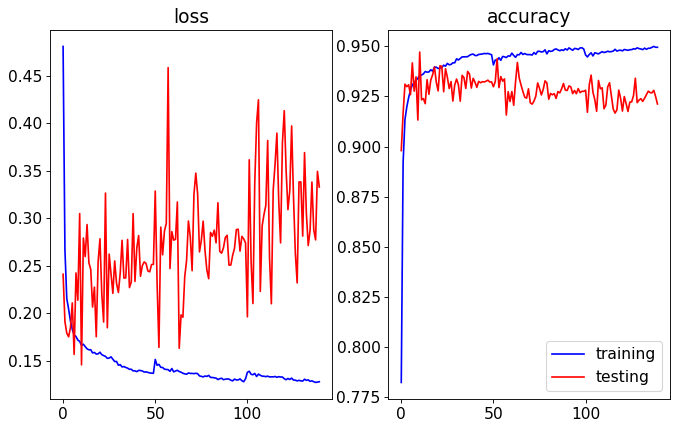

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.35it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


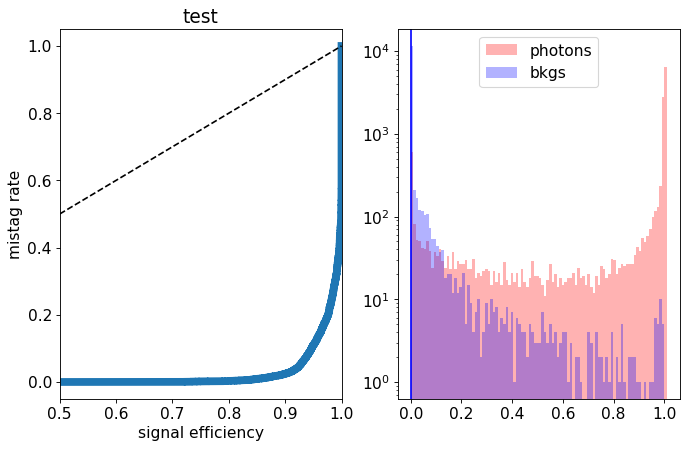

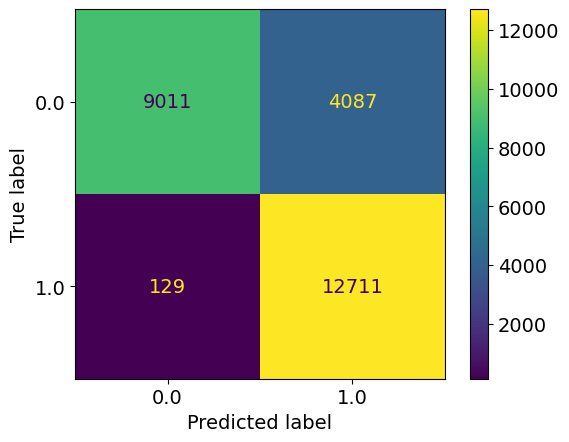

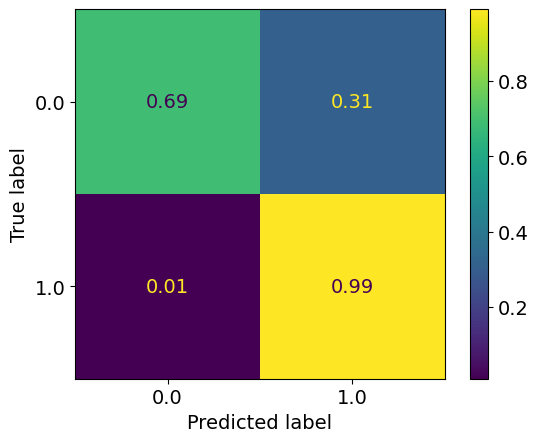

epoch: 140
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.49it/s]


train loss: 0.12712220925127152
train acc: 0.94893545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.35it/s]


test loss: 0.30921944129196083
test acc: 0.9265942
epoch: 141
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.24it/s]


train loss: 0.12755943391192165
train acc: 0.9493113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.28it/s]


test loss: 0.30455747788602655
test acc: 0.9236256
epoch: 142
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.1267057083159513
train acc: 0.95032334


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.05it/s]


test loss: 0.33202527971430257
test acc: 0.9250135
epoch: 143
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.25it/s]


train loss: 0.1272328135078353
train acc: 0.94935954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.91it/s]


test loss: 0.3261453326452862
test acc: 0.9250135
epoch: 144
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.12765119978458206
train acc: 0.9492535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.40it/s]


test loss: 0.3311657707460902
test acc: 0.9246665
epoch: 145
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.22it/s]


train loss: 0.12621081620454788
train acc: 0.94941735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.43it/s]


test loss: 0.33248156952587044
test acc: 0.9251292
epoch: 146
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.47it/s]


train loss: 0.12621235567538036
train acc: 0.9503041


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.27it/s]


test loss: 0.32094560631296853
test acc: 0.92559177
epoch: 147
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.12692873666568988
train acc: 0.9492824


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.3240393992852081
test acc: 0.9250135
epoch: 148
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.12625954442286078
train acc: 0.9501595


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.32189249992370605
test acc: 0.9252448
epoch: 149
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.12603402856974244
train acc: 0.9501595


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.32115496559576556
test acc: 0.9255147


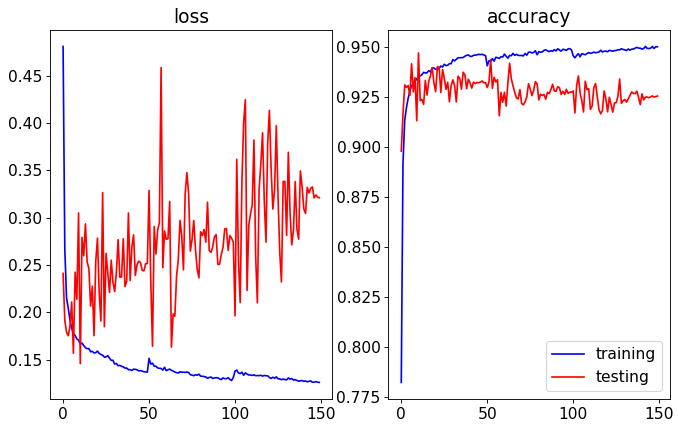

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


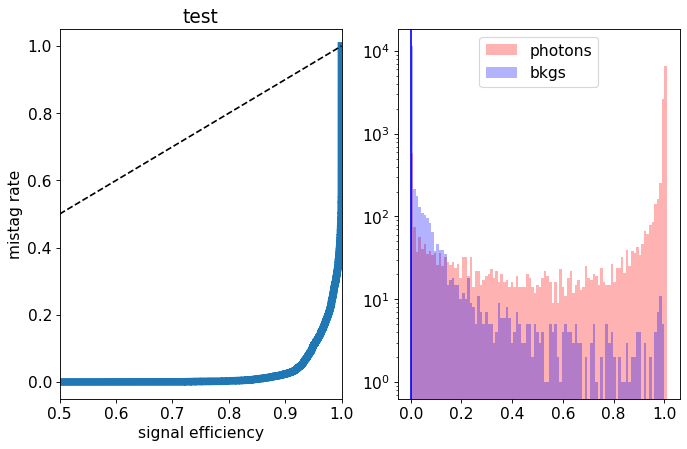

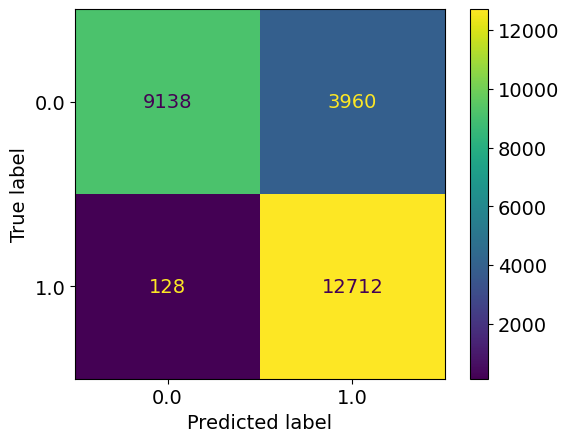

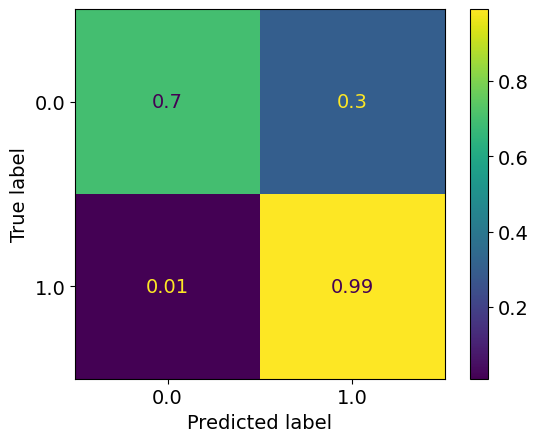

epoch: 150
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.13346589683969587
train acc: 0.94668


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.29it/s]


test loss: 0.2675476494160565
test acc: 0.9276737
epoch: 151
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.13274165049109155
train acc: 0.94725835


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.85it/s]


test loss: 0.3520059897141023
test acc: 0.9172642
epoch: 152
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.13273538175345845
train acc: 0.9473065


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.24it/s]


test loss: 0.33940371430732985
test acc: 0.92015576
epoch: 153
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.13231909580830203
train acc: 0.9478463


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.95it/s]


test loss: 0.2834055450829593
test acc: 0.93299407
epoch: 154
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.1338682149703792
train acc: 0.94628483


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.14it/s]


test loss: 0.3480722447010604
test acc: 0.9209268
epoch: 155
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.1314329274127938
train acc: 0.94786555


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.92it/s]


test loss: 0.297720093280077
test acc: 0.92817485
epoch: 156
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.13262374897223678
train acc: 0.9473644


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.3269400782883167
test acc: 0.9269026
epoch: 157
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.13090796118354522
train acc: 0.94768244


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.14it/s]


test loss: 0.33375994251532987
test acc: 0.925746
epoch: 158
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.13126332976053215
train acc: 0.94822216


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.25552399354902183
test acc: 0.9298327
epoch: 159
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.13175514969178018
train acc: 0.94788486


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.35148199884728953
test acc: 0.91965455


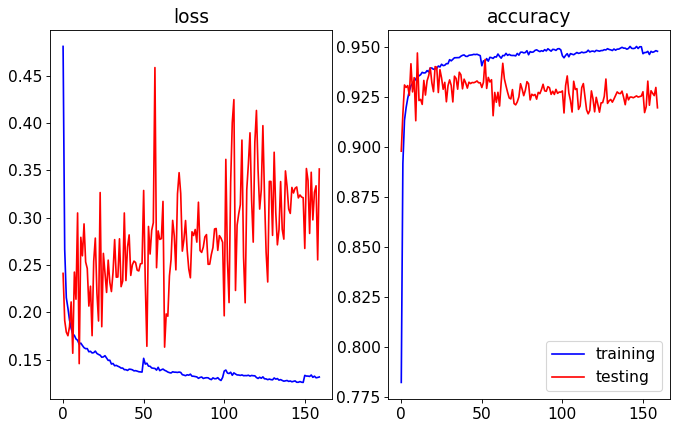

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


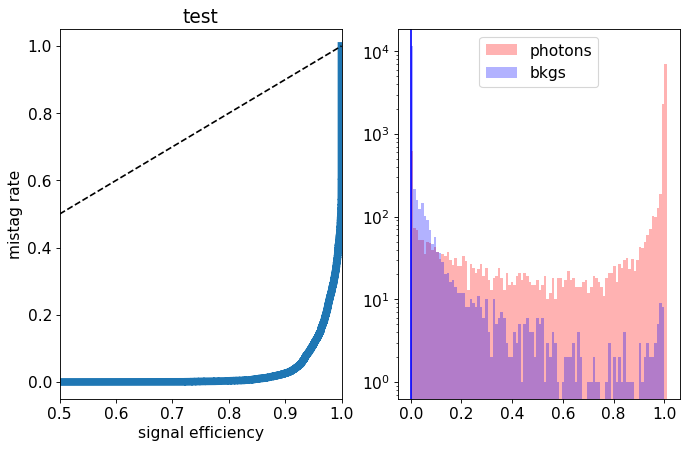

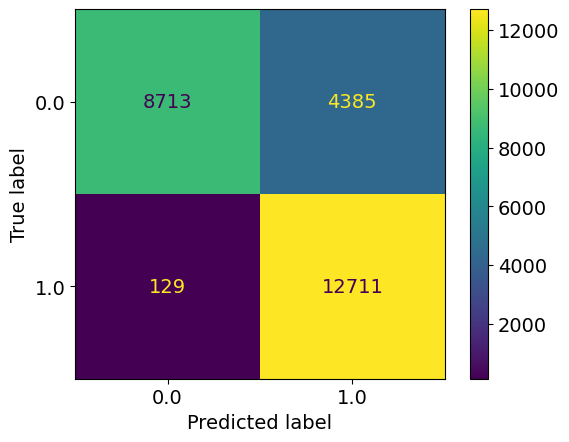

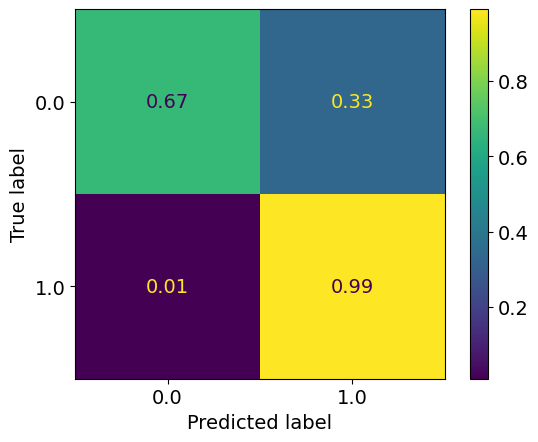

epoch: 160
Learning rate: 0.000904615209340528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.13026224188721938
train acc: 0.94866556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.22it/s]


test loss: 0.3373336673460223
test acc: 0.92354846
epoch: 161
Learning rate: 0.0008853723489545782


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.1325241259670671
train acc: 0.9484535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.17it/s]


test loss: 0.3939625532789664
test acc: 0.9221991
epoch: 162
Learning rate: 0.0008646085999671838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.39it/s]


train loss: 0.13027287253065606
train acc: 0.94881016


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.3437723009423776
test acc: 0.9132547
epoch: 163
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.13185848011446827
train acc: 0.9482511


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.46it/s]


test loss: 0.26291460543870926
test acc: 0.919963
epoch: 164
Learning rate: 0.0008188518951657369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.13136125407639265
train acc: 0.94788486


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.19it/s]


test loss: 0.40446697717363184
test acc: 0.9191534
epoch: 165
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.58it/s]


train loss: 0.1294990473916765
train acc: 0.94968724


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.63it/s]


test loss: 0.3080821138891307
test acc: 0.9273267
epoch: 166
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.12938754958224435
train acc: 0.94831854


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.3097325221381404
test acc: 0.9296014
epoch: 167
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.28it/s]


train loss: 0.13058814901664767
train acc: 0.94861734


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.90it/s]


test loss: 0.34992691468108783
test acc: 0.92439663
epoch: 168
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.1292076541939912
train acc: 0.94819325


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.27938044850121846
test acc: 0.9217364
epoch: 169
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.12879985148851583
train acc: 0.9495234


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.26145840605551546
test acc: 0.9294086


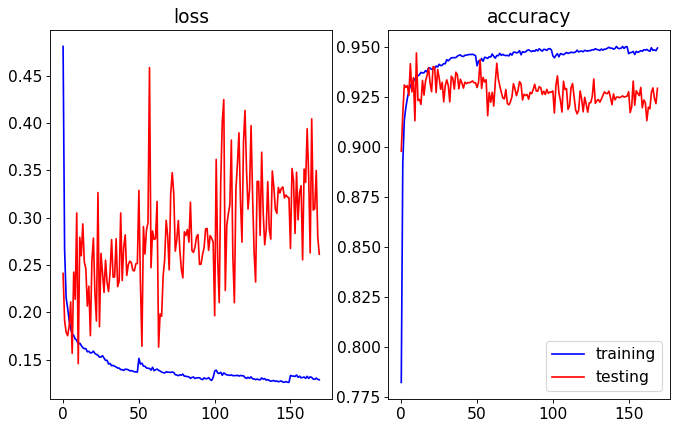

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


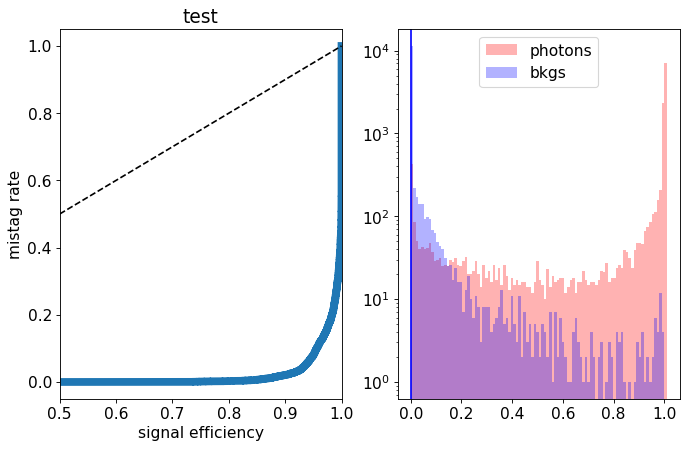

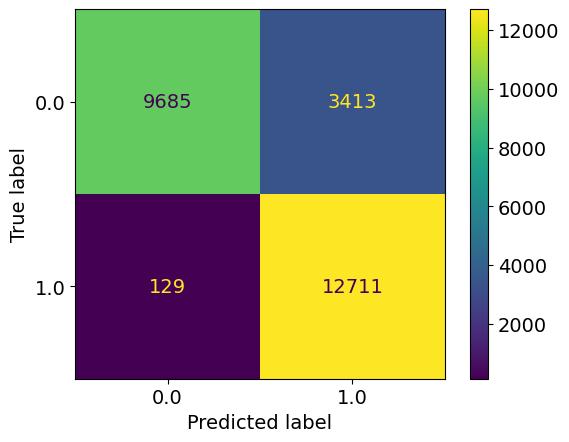

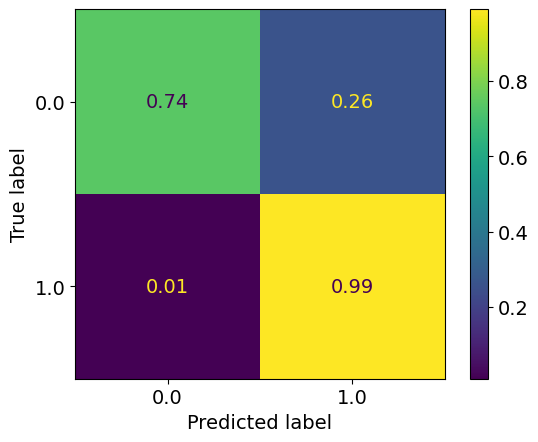

epoch: 170
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.12785501313002812
train acc: 0.949321


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.21it/s]


test loss: 0.22668358852917497
test acc: 0.9332254
epoch: 171
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.12949414318696612
train acc: 0.94951373


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.31307091089812195
test acc: 0.92597735
epoch: 172
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.1282913216276665
train acc: 0.94906074


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.22it/s]


test loss: 0.33298747410828416
test acc: 0.92370266
epoch: 173
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.26it/s]


train loss: 0.12706054497316394
train acc: 0.94966793


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.00it/s]


test loss: 0.37285069274631416
test acc: 0.9267484
epoch: 174
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.1271665149255295
train acc: 0.9497354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.3084800700572404
test acc: 0.92778933
epoch: 175
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.12722591836156183
train acc: 0.9493499


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.3256311904300343
test acc: 0.929023
epoch: 176
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.12737368736308435
train acc: 0.9483571


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.31it/s]


test loss: 0.22264472327449106
test acc: 0.9324543
epoch: 177
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.12713463031659925
train acc: 0.9494559


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.21it/s]


test loss: 0.2836148119108243
test acc: 0.9305652
epoch: 178
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.12635577452837388
train acc: 0.94991857


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.26it/s]


test loss: 0.31595129011706874
test acc: 0.928252
epoch: 179
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.12769979023175432
train acc: 0.94953305


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.27772727981209755
test acc: 0.9329555


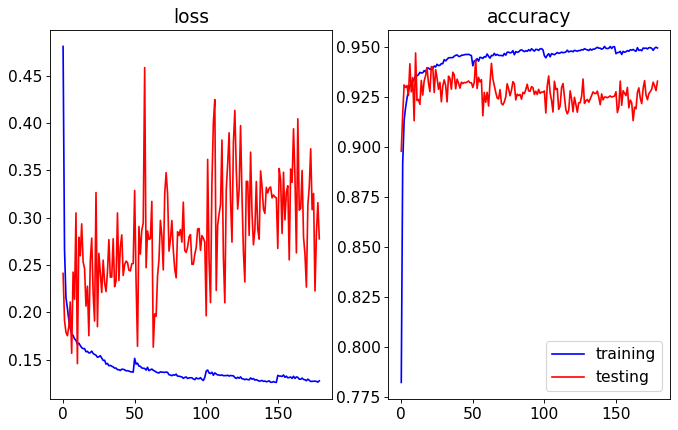

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


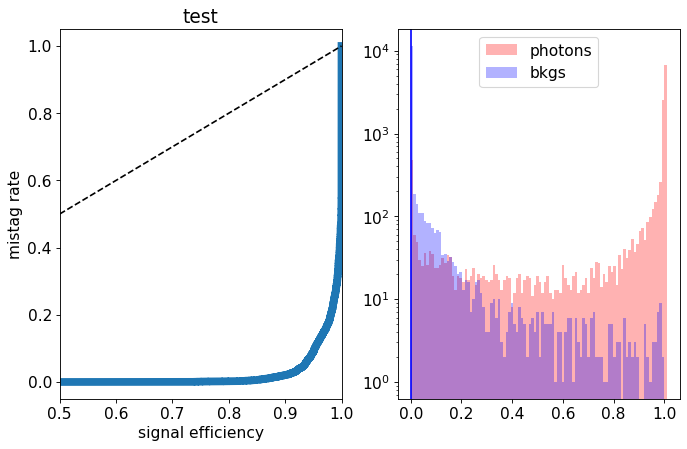

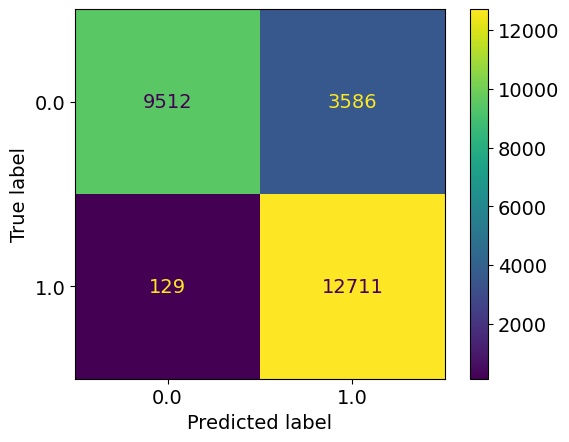

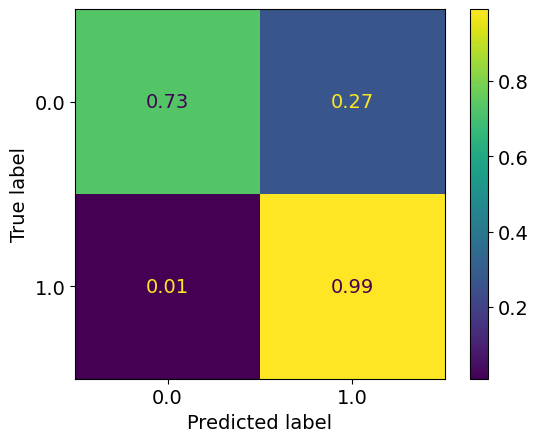

epoch: 180
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.12473433348484811
train acc: 0.9502752


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.3077402324839072
test acc: 0.9289845
epoch: 181
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.12594506286644522
train acc: 0.95028484


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.02it/s]


test loss: 0.3051720383492383
test acc: 0.93033385
epoch: 182
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.12646828087940382
train acc: 0.95061255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.24832537533207374
test acc: 0.93017966
epoch: 183
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.58it/s]


train loss: 0.12485122542849855
train acc: 0.95021737


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.17it/s]


test loss: 0.3998306854204698
test acc: 0.92613155
epoch: 184
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.12542530519597103
train acc: 0.94984144


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.96it/s]


test loss: 0.30933527343652467
test acc: 0.9306423
epoch: 185
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.12417691562733899
train acc: 0.9508631


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.3349208797920834
test acc: 0.9260159
epoch: 186
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.1250548005707002
train acc: 0.9508053


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.3021537248383869
test acc: 0.9278279
epoch: 187
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.12486297516636766
train acc: 0.9503908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.67it/s]


test loss: 0.3063732192597606
test acc: 0.92994833
epoch: 188
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.26it/s]


train loss: 0.12470890758182272
train acc: 0.95032334


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.301063053987243
test acc: 0.9306809
epoch: 189
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.12447643245575744
train acc: 0.9501595


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.33469734442504967
test acc: 0.9262472


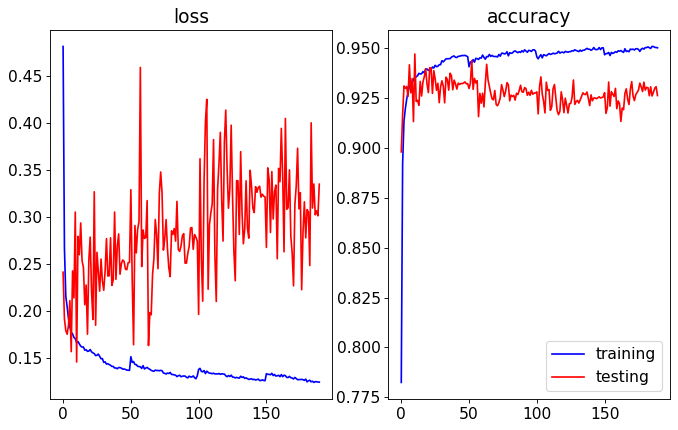

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.18it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


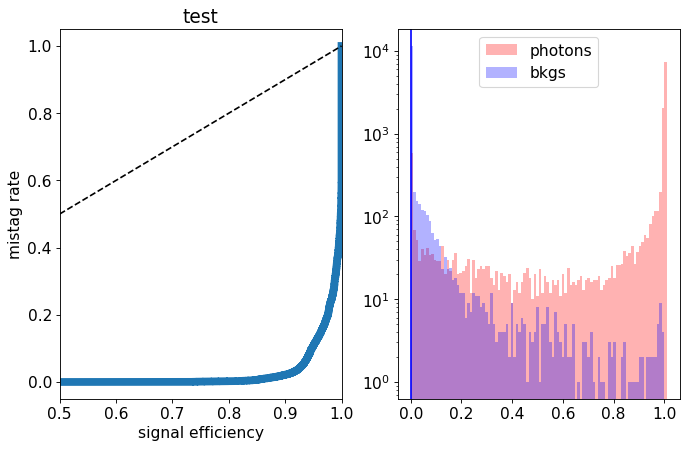

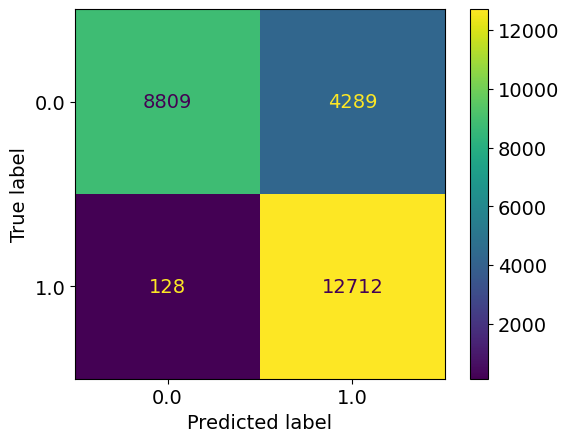

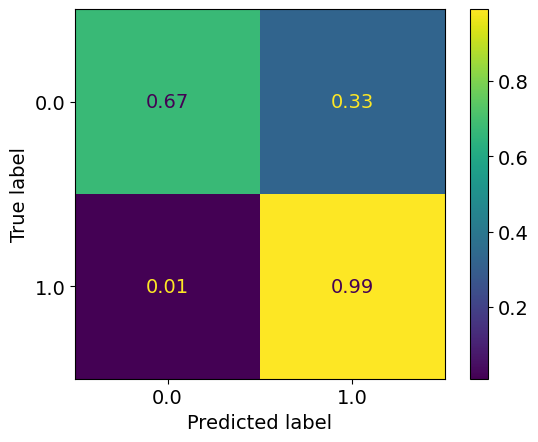

epoch: 190
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.45it/s]


train loss: 0.12531769310118834
train acc: 0.9500053


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.45it/s]


test loss: 0.3189436810260469
test acc: 0.92655563
epoch: 191
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.24it/s]


train loss: 0.1254496840986213
train acc: 0.95028484


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]


test loss: 0.2828921875493093
test acc: 0.93125916
epoch: 192
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.12379563905600179
train acc: 0.95145106


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.22it/s]


test loss: 0.2784892676228827
test acc: 0.9301025
epoch: 193
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.12579225498989138
train acc: 0.9507185


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.2977254803885113
test acc: 0.9284062
epoch: 194
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.12352130101250776
train acc: 0.9504583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.35it/s]


test loss: 0.2942093878307126
test acc: 0.92856044
epoch: 195
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.28it/s]


train loss: 0.12361740661149768
train acc: 0.9508149


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.17it/s]


test loss: 0.2989716533232819
test acc: 0.92871463
epoch: 196
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.12375043315349976
train acc: 0.95059323


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.25it/s]


test loss: 0.29695660451596434
test acc: 0.9282134
epoch: 197
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.36it/s]


train loss: 0.12334499370328264
train acc: 0.9508439


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.3030488799241456
test acc: 0.927905
epoch: 198
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.12245015304729429
train acc: 0.95097876


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.20it/s]


test loss: 0.3014611720361493
test acc: 0.92813635
epoch: 199
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.12418568384096113
train acc: 0.9503523


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.30236785621805623
test acc: 0.9280978


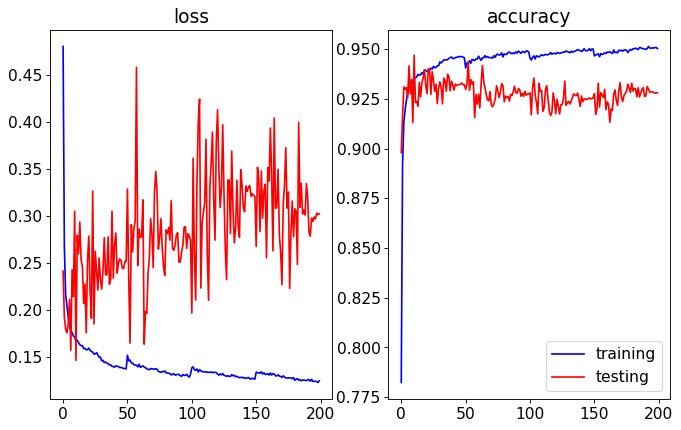

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.22it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


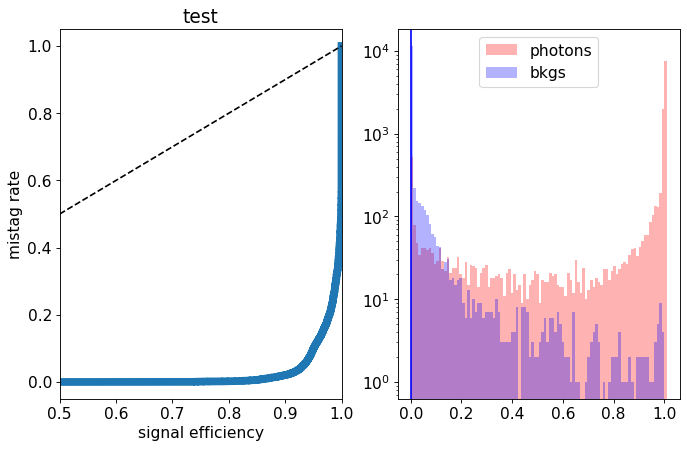

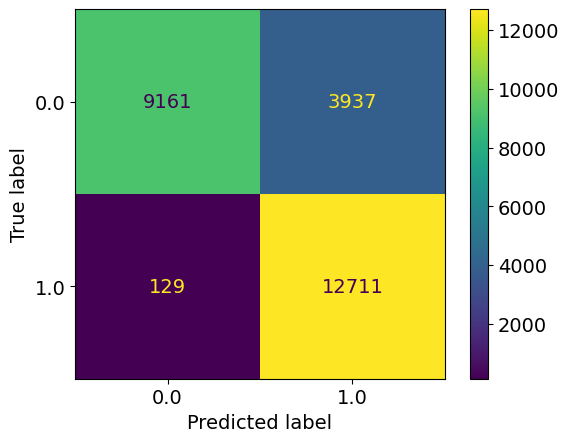

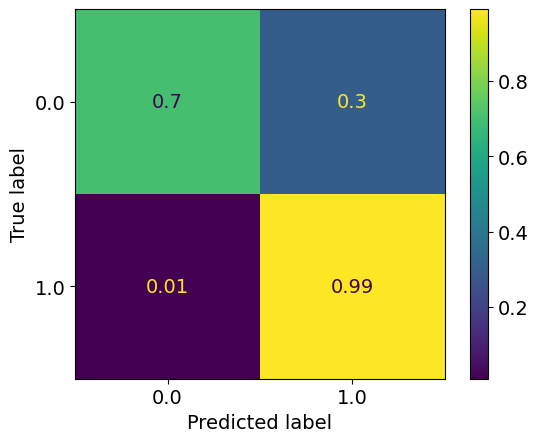

epoch: 200
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.12932253219833265
train acc: 0.9488294


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.22it/s]


test loss: 0.23178467289967972
test acc: 0.9305652
epoch: 201
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.1310664709076027
train acc: 0.9474318


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.17it/s]


test loss: 0.30956301160834054
test acc: 0.91680163
epoch: 202
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.13015427237990274
train acc: 0.9477981


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.19it/s]


test loss: 0.24608001925728537
test acc: 0.9255147
epoch: 203
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.12917290929424968
train acc: 0.948386


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.23176941444927995
test acc: 0.93191457
epoch: 204
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.12918811670445293
train acc: 0.94758606


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.02it/s]


test loss: 0.22455392303791913
test acc: 0.93017966
epoch: 205
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.12968654478388714
train acc: 0.9491957


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.3337970985607667
test acc: 0.92883027
epoch: 206
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.1297581698422487
train acc: 0.9487427


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.18181373890150676
test acc: 0.9397024
epoch: 207
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.12906725868324323
train acc: 0.94894505


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.75it/s]


test loss: 0.48596603355624457
test acc: 0.92000157
epoch: 208
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.26it/s]


train loss: 0.129057430592231
train acc: 0.94927275


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.36it/s]


test loss: 0.39597793499177153
test acc: 0.9191534
epoch: 209
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.49it/s]


train loss: 0.12848836954446197
train acc: 0.94914746


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.43it/s]


test loss: 0.396908181973479
test acc: 0.91980875


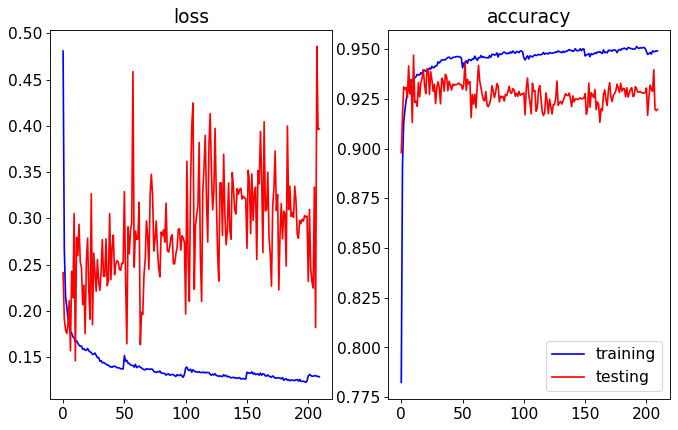

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.44it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


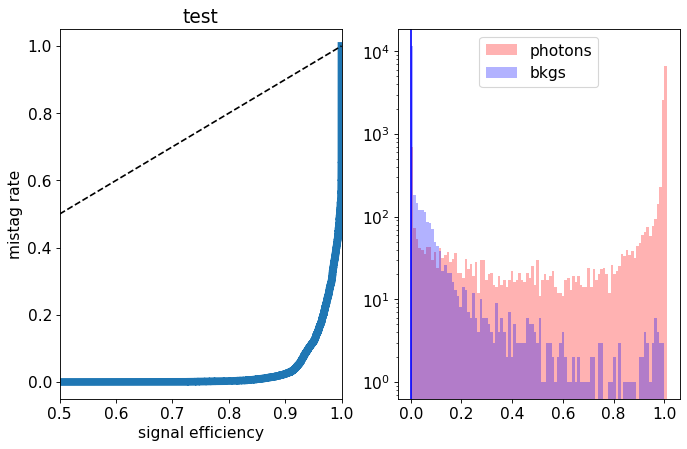

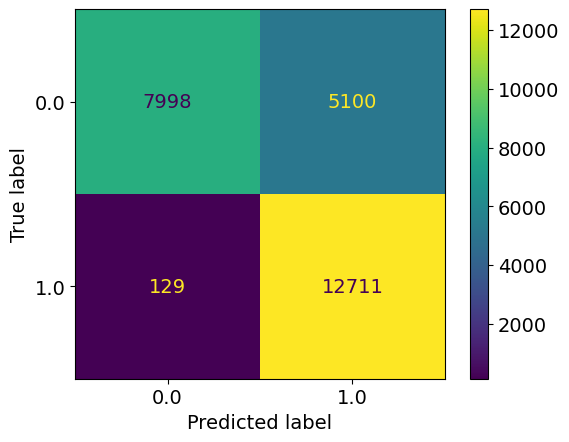

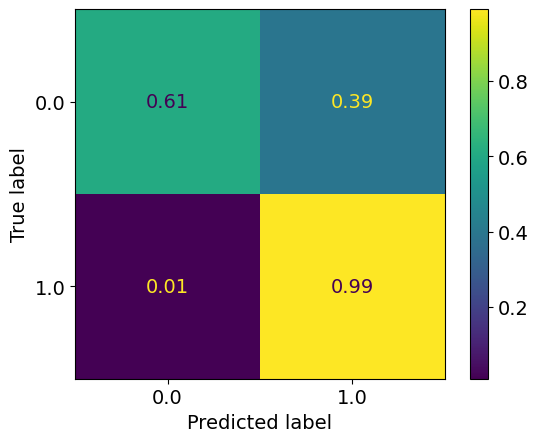

epoch: 210
Learning rate: 0.000904615209340528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.24it/s]


train loss: 0.12759939977371623
train acc: 0.948868


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.46it/s]


test loss: 0.3304167725145817
test acc: 0.9259388
epoch: 211
Learning rate: 0.0008853723489545782


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.47it/s]


train loss: 0.12675768360926237
train acc: 0.9496487


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.02it/s]


test loss: 0.2642968584868041
test acc: 0.933341
epoch: 212
Learning rate: 0.0008646085999671838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.48it/s]


train loss: 0.1264811133632081
train acc: 0.94924384


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.38it/s]


test loss: 0.392418406565081
test acc: 0.93276274
epoch: 213
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.47it/s]


train loss: 0.12704172851033294
train acc: 0.949639


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.01it/s]


test loss: 0.18493919345465573
test acc: 0.93600124
epoch: 214
Learning rate: 0.0008188518951657369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.50it/s]


train loss: 0.12712304139068362
train acc: 0.9494848


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.18it/s]


test loss: 0.3945245973088525
test acc: 0.92586166
epoch: 215
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.37it/s]


train loss: 0.12755294286274496
train acc: 0.9494366


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.21it/s]


test loss: 0.24077921123667198
test acc: 0.9405891
epoch: 216
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.1265404589603402
train acc: 0.9497643


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.19it/s]


test loss: 0.3098975013602864
test acc: 0.9255147
epoch: 217
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.36it/s]


train loss: 0.12510525387835641
train acc: 0.94957155


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]


test loss: 0.2341823164712299
test acc: 0.9361169
epoch: 218
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.12701350932865474
train acc: 0.9495041


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.22it/s]


test loss: 0.3024234913966872
test acc: 0.9332254
epoch: 219
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.1259310033624572
train acc: 0.95004386


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.21797745234586977
test acc: 0.93260854


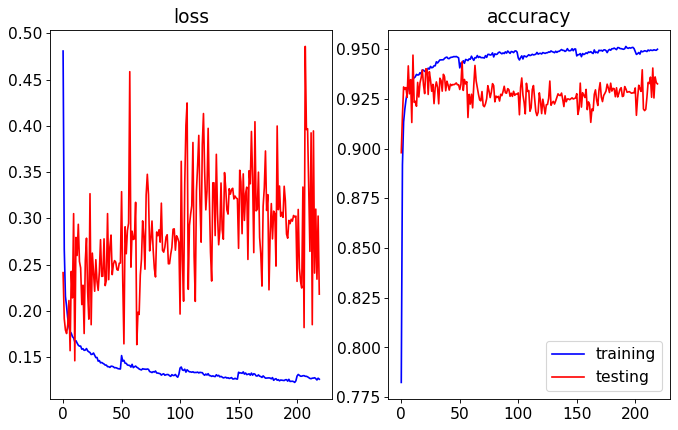

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


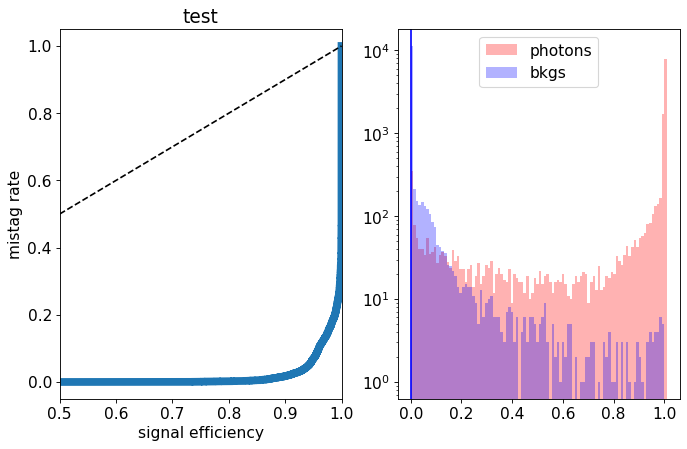

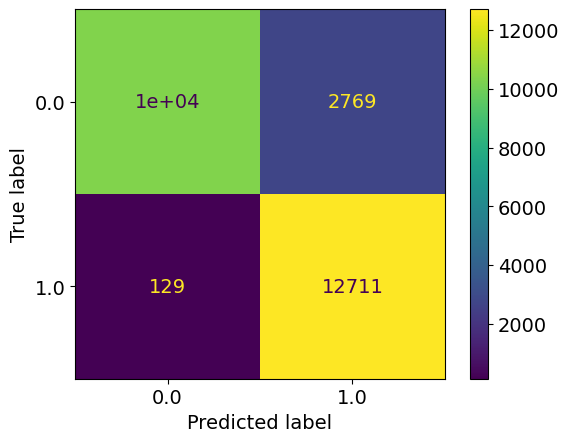

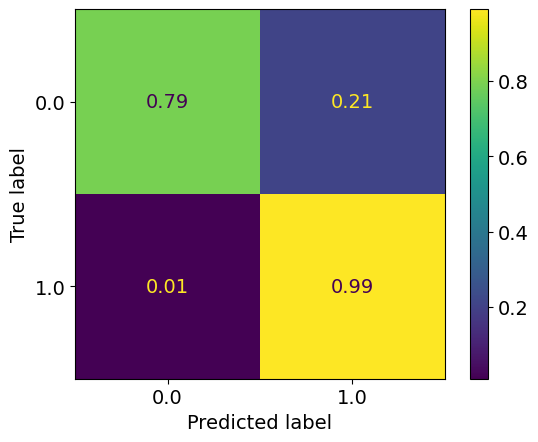

epoch: 220
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.1273453911346507
train acc: 0.94954264


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.27872271835803986
test acc: 0.9294471
epoch: 221
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.12569825260797676
train acc: 0.94968724


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.02it/s]


test loss: 0.2222451516850428
test acc: 0.93233865
epoch: 222
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.12380558915565469
train acc: 0.9505643


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.2357040982354771
test acc: 0.93434346
epoch: 223
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.36it/s]


train loss: 0.1260235474977879
train acc: 0.9501113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.23it/s]


test loss: 0.335660456256433
test acc: 0.92397255
epoch: 224
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.12431822066878997
train acc: 0.9501788


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.35825435004451056
test acc: 0.9291773
epoch: 225
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.12300452977591167
train acc: 0.95082456


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.19it/s]


test loss: 0.2510631973431869
test acc: 0.93125916
epoch: 226
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.12467606430281104
train acc: 0.95062214


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.45it/s]


test loss: 0.27764329009435396
test acc: 0.9344205
epoch: 227
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.58it/s]


train loss: 0.12495150692717877
train acc: 0.9502463


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.2537585459649563
test acc: 0.93438196
epoch: 228
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.12273124101534055
train acc: 0.9510173


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.33it/s]


test loss: 0.27887285737828776
test acc: 0.93465185
epoch: 229
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.12431585526018474
train acc: 0.95019805


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.28396389599550853
test acc: 0.929717


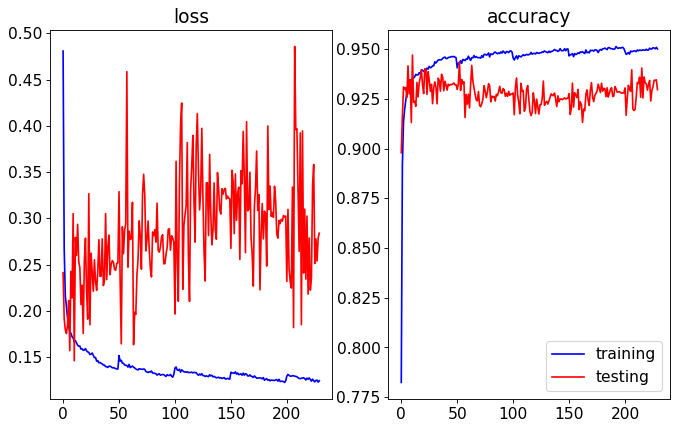

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


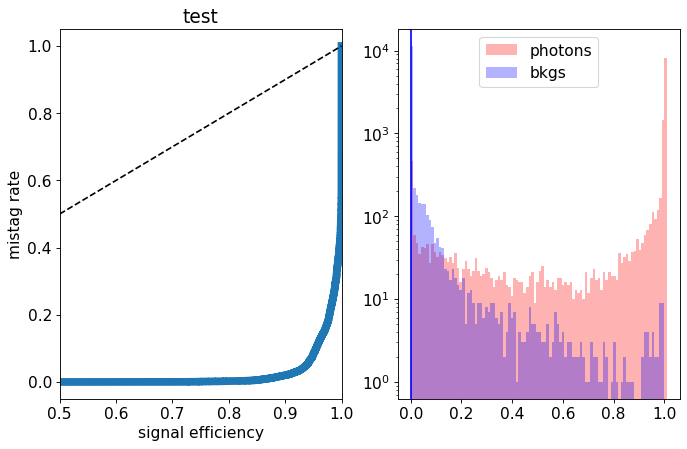

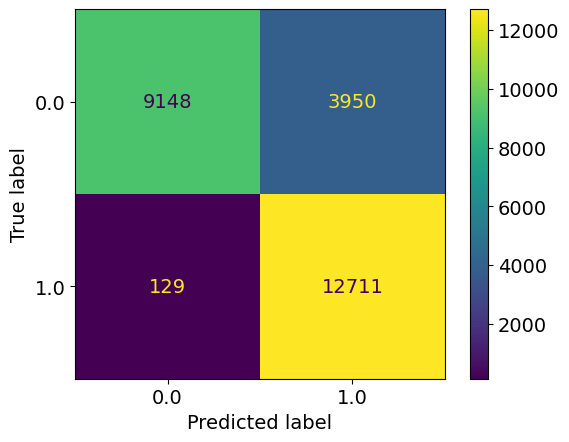

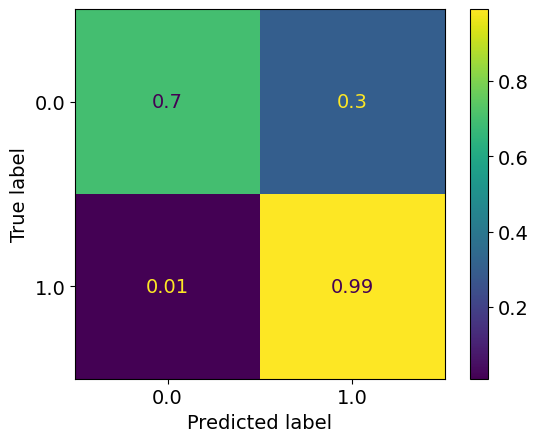

epoch: 230
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.12432565453941423
train acc: 0.95029444


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.23069135370579633
test acc: 0.9310278
epoch: 231
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.12255295361742119
train acc: 0.9507475


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]


test loss: 0.22541410780765794
test acc: 0.9366952
epoch: 232
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.12287150151123201
train acc: 0.9508728


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.02it/s]


test loss: 0.22193042595278134
test acc: 0.9361169
epoch: 233
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.12247725322067393
train acc: 0.951345


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.26053345474329864
test acc: 0.9327242
epoch: 234
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.12127135315037876
train acc: 0.95106554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.25821223787286063
test acc: 0.9357699
epoch: 235
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.1227153528029519
train acc: 0.9519523


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.2562285570258444
test acc: 0.93195313
epoch: 236
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.12312013113257513
train acc: 0.95052576


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.2703172361308878
test acc: 0.9299869
epoch: 237
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.1207721847071813
train acc: 0.9513836


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.22it/s]


test loss: 0.2863090085712346
test acc: 0.9322615
epoch: 238
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.12189591141966725
train acc: 0.9514414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.24259710311889648
test acc: 0.93330246
epoch: 239
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.12220135335460564
train acc: 0.951827


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.25804049521684647
test acc: 0.93476754


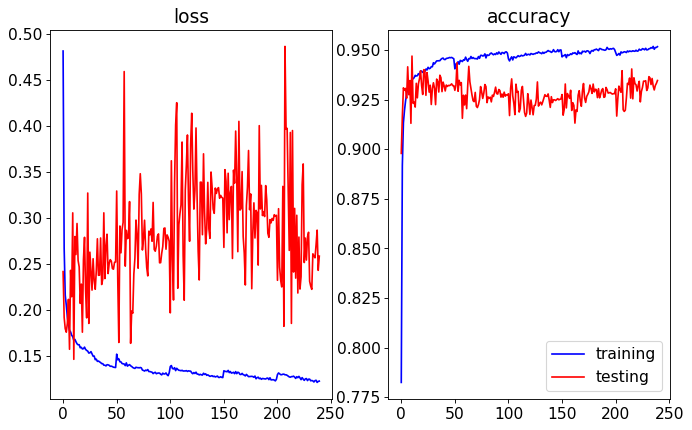

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


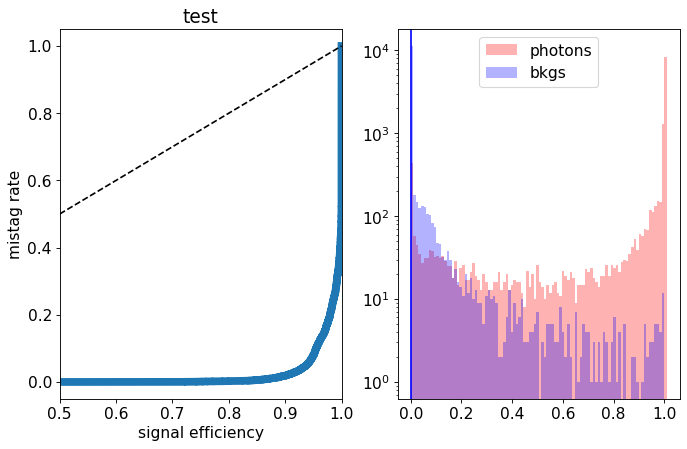

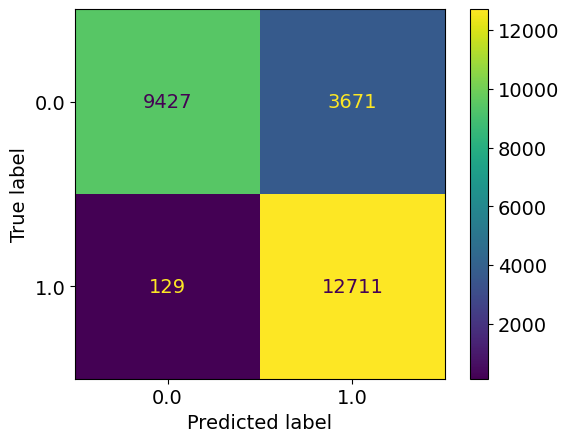

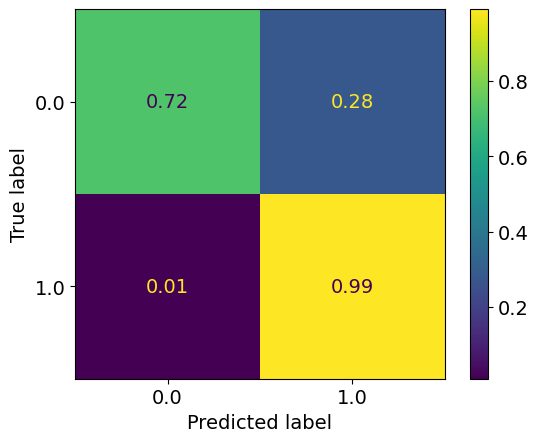

epoch: 240
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.12139953263749965
train acc: 0.9522703


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.78it/s]


test loss: 0.2452766824175011
test acc: 0.9353844
epoch: 241
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.12067691262574554
train acc: 0.9517691


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.2538704089820385
test acc: 0.933341
epoch: 242
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.12186684269953325
train acc: 0.9506896


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.2644531232389537
test acc: 0.9328013
epoch: 243
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.29it/s]


train loss: 0.12098680337557213
train acc: 0.951827


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.35it/s]


test loss: 0.25815433433110063
test acc: 0.9336109
epoch: 244
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.46it/s]


train loss: 0.12024745530303503
train acc: 0.95204866


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.2622730491513556
test acc: 0.93330246
epoch: 245
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.25it/s]


train loss: 0.12175426533111947
train acc: 0.9510752


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.25837228718129074
test acc: 0.93291694
epoch: 246
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.12109811113059865
train acc: 0.95094025


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.14it/s]


test loss: 0.25317470932548697
test acc: 0.9339579
epoch: 247
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.12130214347143393
train acc: 0.9510848


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.54it/s]


test loss: 0.2558904147960923
test acc: 0.9341892
epoch: 248
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.12136155030975453
train acc: 0.95157635


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.2543771100992506
test acc: 0.93422776
epoch: 249
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.12102819802616373
train acc: 0.9516438


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.00it/s]


test loss: 0.25651486844501714
test acc: 0.9341507


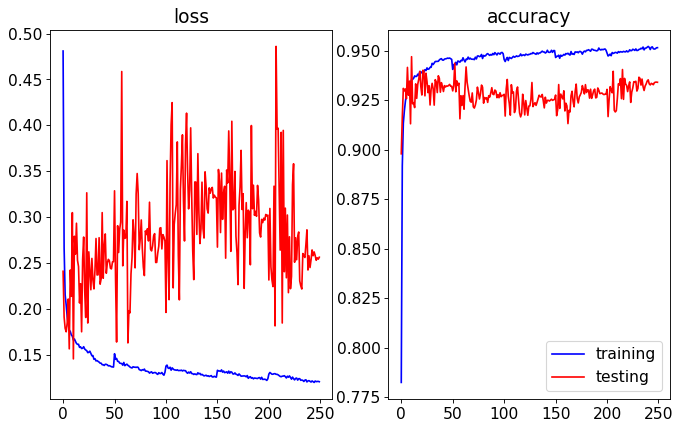

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


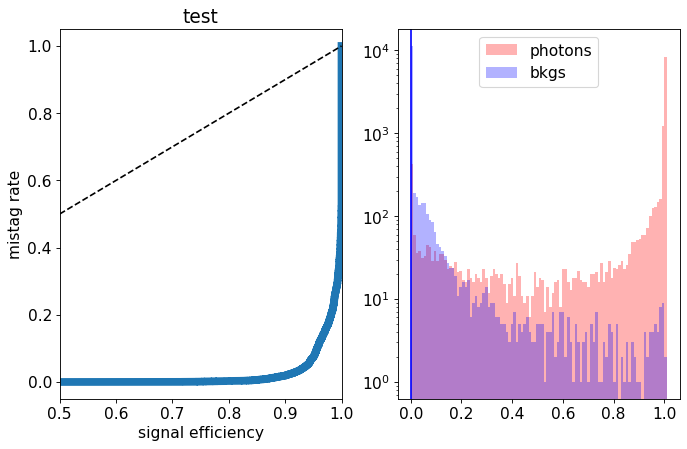

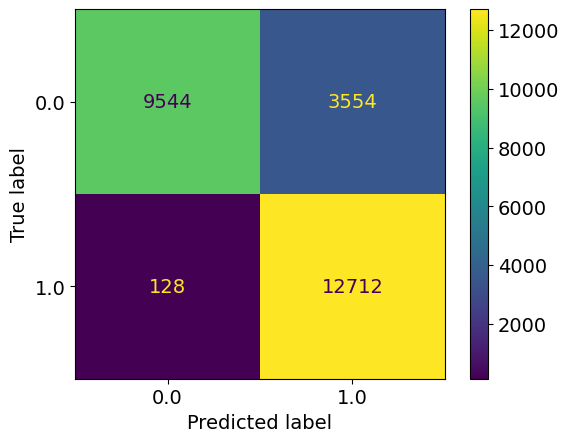

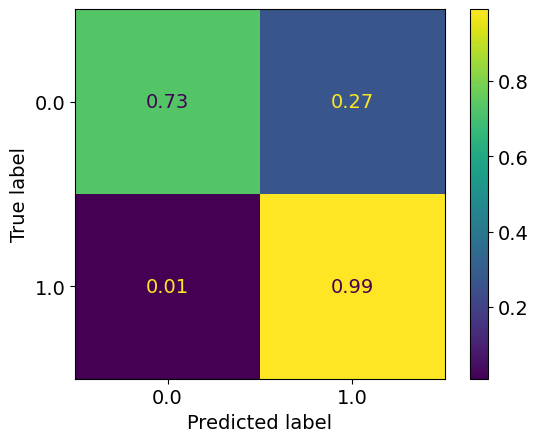

epoch: 250
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.29it/s]


train loss: 0.12739568315661712
train acc: 0.9491089


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.88it/s]


test loss: 0.29646560312672093
test acc: 0.9335338
epoch: 251
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.12801089822556933
train acc: 0.9487137


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.27141884206370875
test acc: 0.92721105
epoch: 252
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.1269667250228066
train acc: 0.9490414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.2798475230282003
test acc: 0.93923974
epoch: 253
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.1264076709230511
train acc: 0.9495234


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.3444060215895826
test acc: 0.9289845
epoch: 254
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.12592900182642688
train acc: 0.9494656


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.24663913622498512
test acc: 0.93650246
epoch: 255
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.12499633302233812
train acc: 0.95019805


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.00it/s]


test loss: 0.26762339438904414
test acc: 0.93515307
epoch: 256
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.12547231366524117
train acc: 0.95031375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.22761413319544357
test acc: 0.9345748
epoch: 257
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.58it/s]


train loss: 0.1261444701194074
train acc: 0.94992816


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.20it/s]


test loss: 0.25483754920688545
test acc: 0.93650246
epoch: 258
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.12514247732355416
train acc: 0.95022696


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.18it/s]


test loss: 0.27930162677710707
test acc: 0.94220835
epoch: 259
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.12428960695087565
train acc: 0.9511908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.02it/s]


test loss: 0.25734253735704854
test acc: 0.94055057


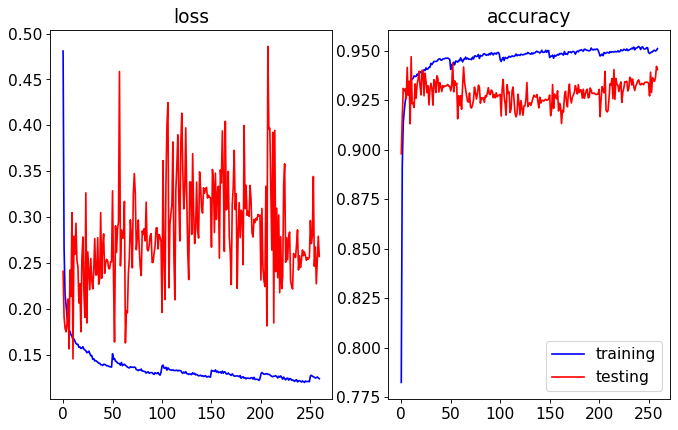

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.99it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


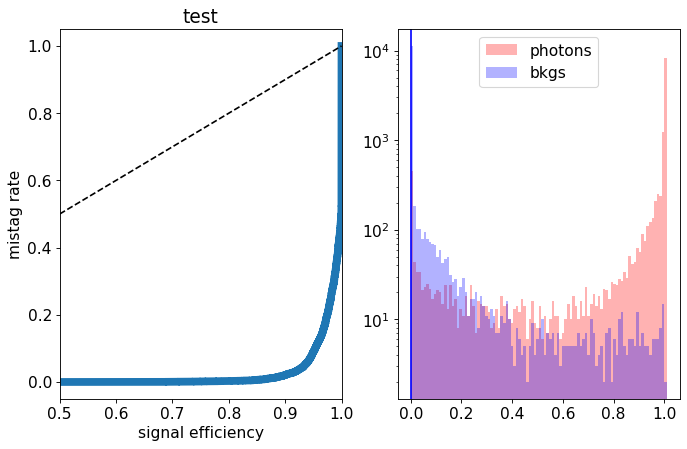

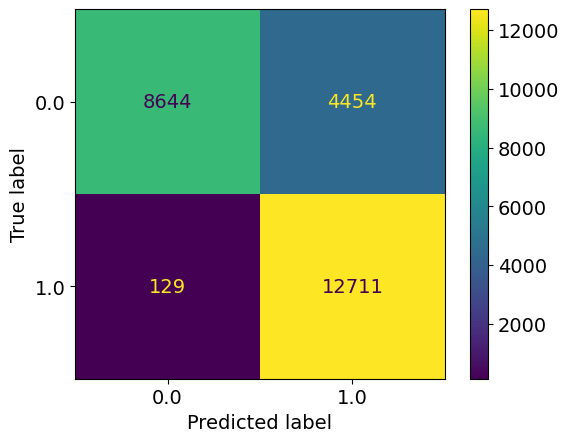

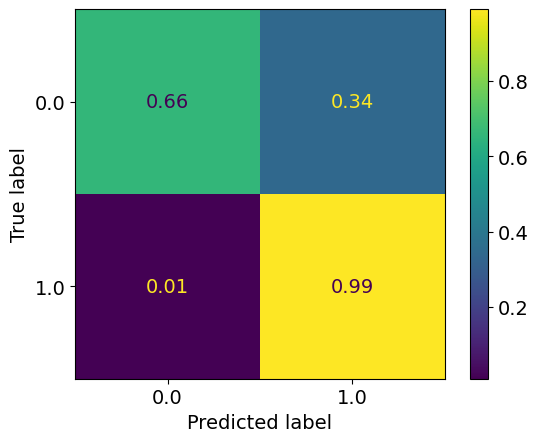

epoch: 260
Learning rate: 0.000904615209340528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.12573890301878052
train acc: 0.9503908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.95it/s]


test loss: 0.24320625683123415
test acc: 0.93939394
epoch: 261
Learning rate: 0.0008853723489545782


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.12346848836868485
train acc: 0.9507571


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.14it/s]


test loss: 0.30245194787328894
test acc: 0.9278279
epoch: 262
Learning rate: 0.0008646085999671838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.124603149734136
train acc: 0.9500246


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.2124226838350296
test acc: 0.9397024
epoch: 263
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.12304655453890045
train acc: 0.95089203


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.3231423375281421
test acc: 0.9348446
epoch: 264
Learning rate: 0.0008188518951657369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.12606162198878437
train acc: 0.9491668


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.20it/s]


test loss: 0.22989257662133736
test acc: 0.9375434
epoch: 265
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.26it/s]


train loss: 0.12453062655781046
train acc: 0.9507089


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.26it/s]


test loss: 0.1794077962298285
test acc: 0.9445601
epoch: 266
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.47it/s]


train loss: 0.12435886961531777
train acc: 0.9504101


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.02it/s]


test loss: 0.2502939443696629
test acc: 0.9328013
epoch: 267
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.1234665751629482
train acc: 0.9505451


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.28871670162135904
test acc: 0.93391937
epoch: 268
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.12468206258006179
train acc: 0.9494945


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.22it/s]


test loss: 0.2487926703285087
test acc: 0.93896985
epoch: 269
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.36it/s]


train loss: 0.12281743760053822
train acc: 0.9509306


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.20it/s]


test loss: 0.24809095669876446
test acc: 0.9382373


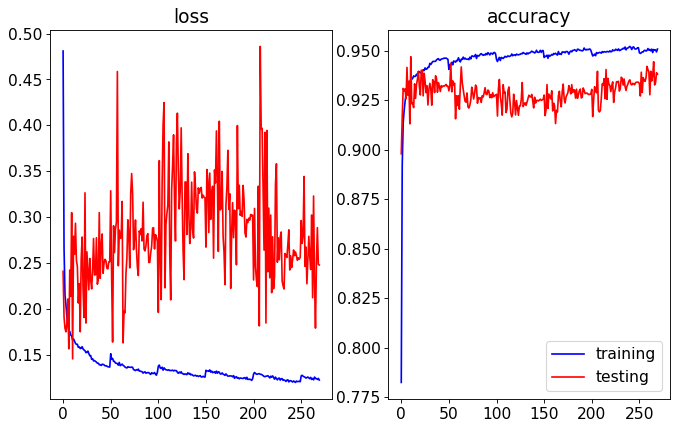

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.18it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


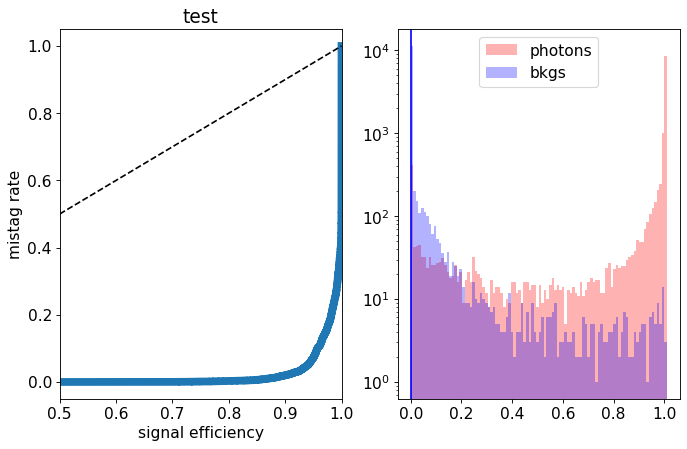

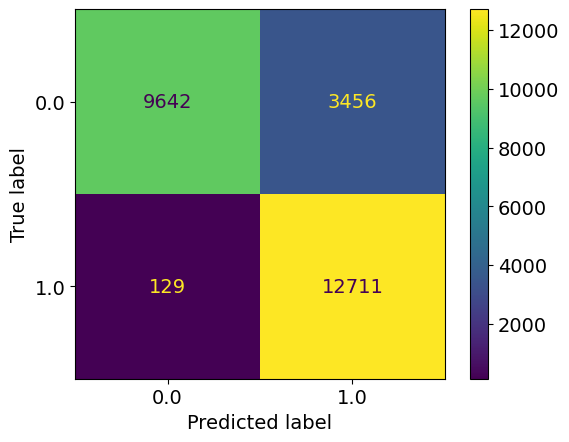

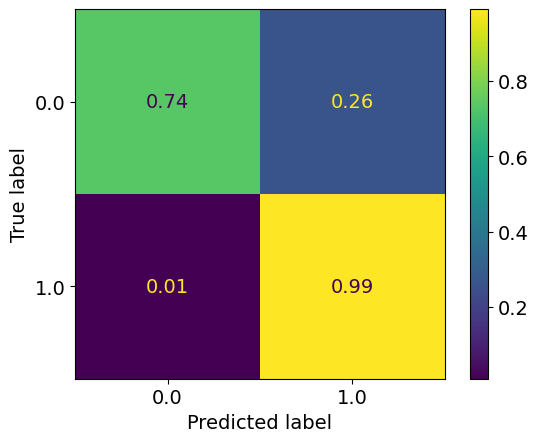

epoch: 270
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.12292664554077766
train acc: 0.95025593


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.22906411151317033
test acc: 0.9393554
epoch: 271
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.12360855067051904
train acc: 0.950333


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.97it/s]


test loss: 0.22770034183155408
test acc: 0.9406662
epoch: 272
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.12487945498930926
train acc: 0.9504101


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.69it/s]


test loss: 0.19837055998769673
test acc: 0.94097465
epoch: 273
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.12306250399247759
train acc: 0.9510462


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.19894987107677894
test acc: 0.93977946
epoch: 274
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.1224102535085871
train acc: 0.95169204


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.35it/s]


test loss: 0.27711666239933536
test acc: 0.93831444
epoch: 275
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.1219892213713227
train acc: 0.95124865


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.94it/s]


test loss: 0.23872054740786552
test acc: 0.9381988
epoch: 276
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.29it/s]


train loss: 0.12125862794632168
train acc: 0.95124865


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.23317823999307372
test acc: 0.9368494
epoch: 277
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.12233523240668236
train acc: 0.951827


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.18it/s]


test loss: 0.22271751460026612
test acc: 0.93804455
epoch: 278
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.12149102705923807
train acc: 0.95167273


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.23it/s]


test loss: 0.20161315764893184
test acc: 0.94139874
epoch: 279
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.12145250118364488
train acc: 0.95201975


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.99it/s]


test loss: 0.1882619575004686
test acc: 0.94085896


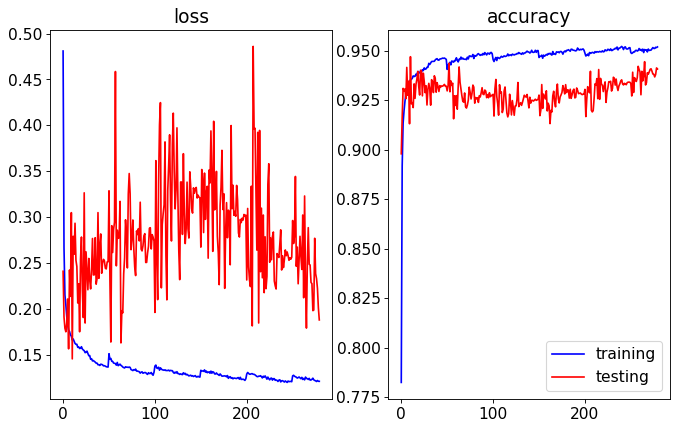

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


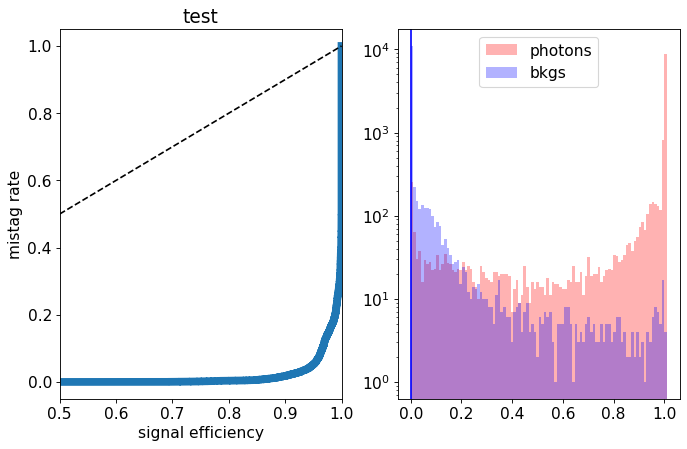

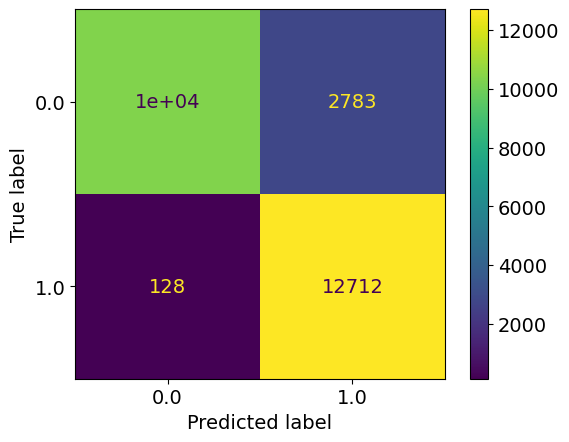

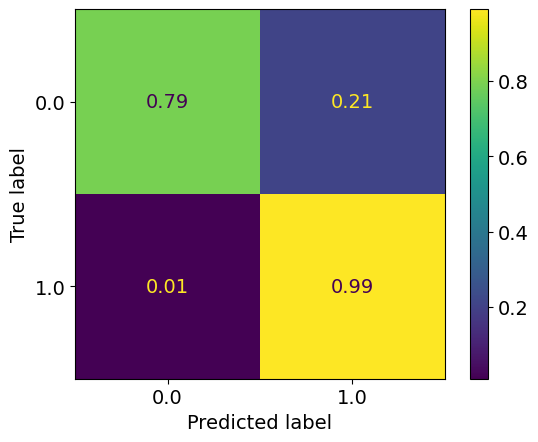

epoch: 280
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.21it/s]


train loss: 0.12215884886897369
train acc: 0.9513161


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.33it/s]


test loss: 0.22016019780527463
test acc: 0.9399337
epoch: 281
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.1208247096638459
train acc: 0.95079565


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.91it/s]


test loss: 0.258934250948104
test acc: 0.9380831
epoch: 282
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.12064968273474302
train acc: 0.9517113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.23875417391007597
test acc: 0.94101316
epoch: 283
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.12116008368186179
train acc: 0.95170164


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.05it/s]


test loss: 0.20529255795885215
test acc: 0.94286376
epoch: 284
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.12019016227625698
train acc: 0.9519426


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.23060817610133777
test acc: 0.93923974
epoch: 285
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.12022294909451049
train acc: 0.95121974


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.37it/s]


test loss: 0.21931780942461707
test acc: 0.9413216
epoch: 286
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.11954959382900612
train acc: 0.95214504


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.19it/s]


test loss: 0.2334990565749732
test acc: 0.9382373
epoch: 287
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.11957493153093868
train acc: 0.9518559


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.43it/s]


test loss: 0.24204019897363402
test acc: 0.9352687
epoch: 288
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11967476909560275
train acc: 0.951827


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.2155266119675203
test acc: 0.9397024
epoch: 289
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.11845291173354738
train acc: 0.9525788


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.2121453441002152
test acc: 0.9393554


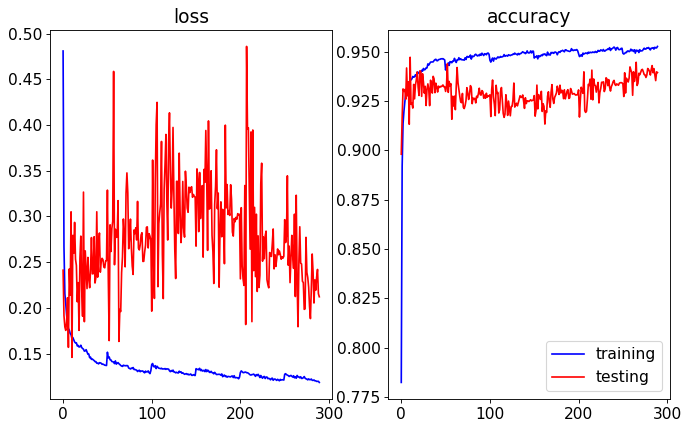

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.05it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


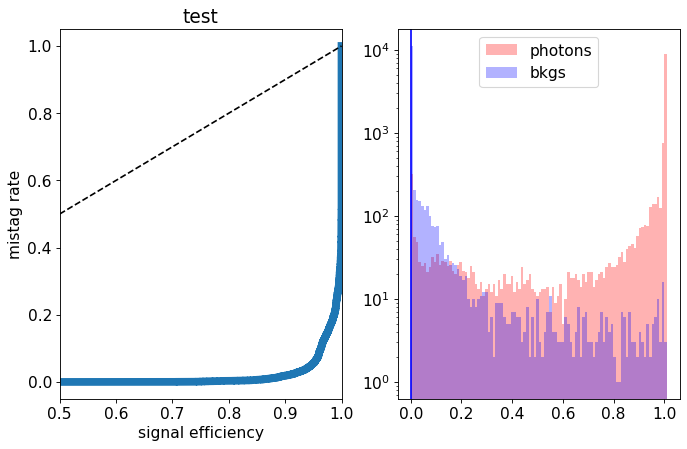

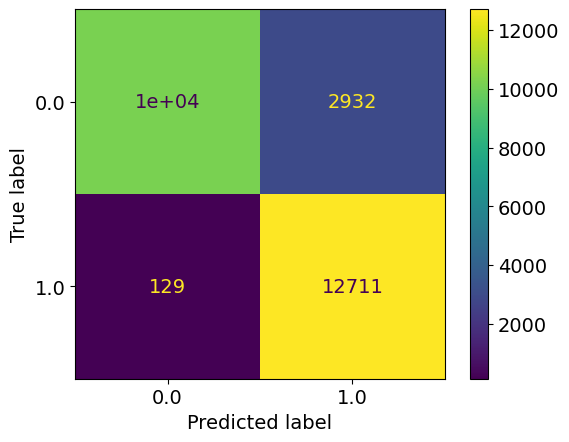

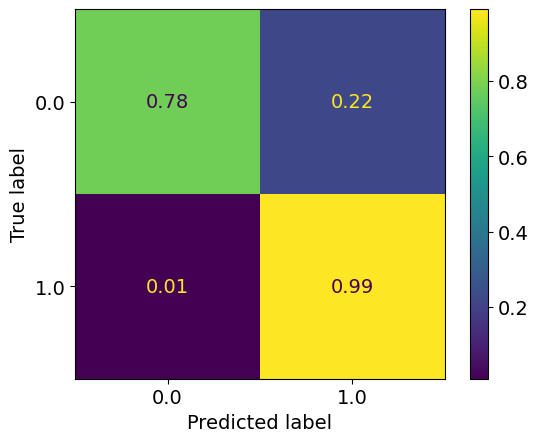

epoch: 290
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.12068926896146268
train acc: 0.9527908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.2285261448811401
test acc: 0.93843013
epoch: 291
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.11892880787911443
train acc: 0.952733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.2215105274861509
test acc: 0.9396638
epoch: 292
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.11923625832692736
train acc: 0.9522414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.21364495564590802
test acc: 0.9403578
epoch: 293
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.11907523577612948
train acc: 0.9528487


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.21880627491257407
test acc: 0.93843013
epoch: 294
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.11898110781101823
train acc: 0.95253056


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.21806131675839424
test acc: 0.9381988
epoch: 295
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.37it/s]


train loss: 0.1185992921707947
train acc: 0.9524631


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.24it/s]


test loss: 0.22067850015380167
test acc: 0.9392012
epoch: 296
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.11967566725663367
train acc: 0.9519137


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.20it/s]


test loss: 0.21684810282154518
test acc: 0.939047
epoch: 297
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.11866678435333891
train acc: 0.952839


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.99it/s]


test loss: 0.21446595527231693
test acc: 0.9387771
epoch: 298
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.11851699861315633
train acc: 0.9523571


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.21587624908848244
test acc: 0.9389313
epoch: 299
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.11838013730469467
train acc: 0.9524824


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.20it/s]


test loss: 0.21481532976031303
test acc: 0.93896985


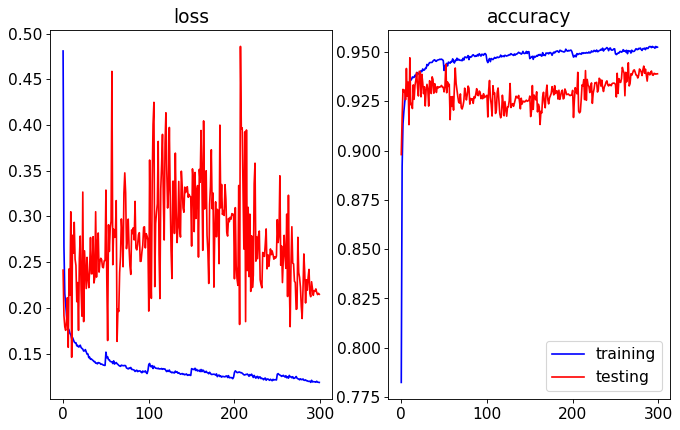

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.14it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


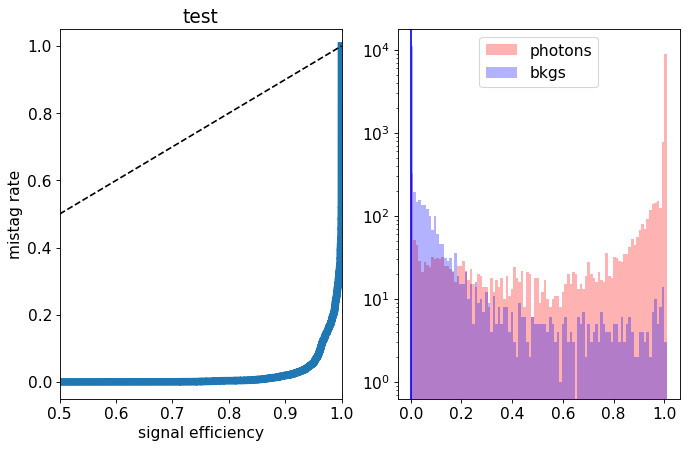

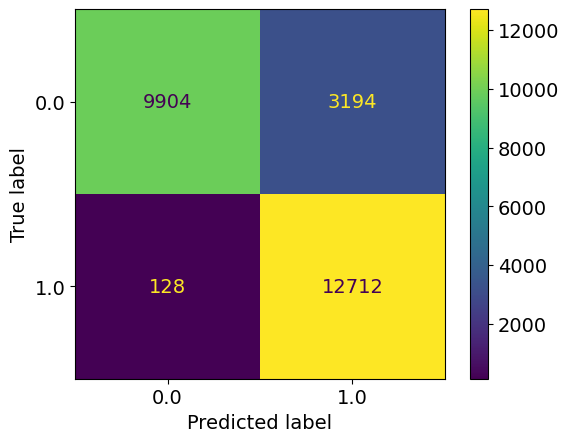

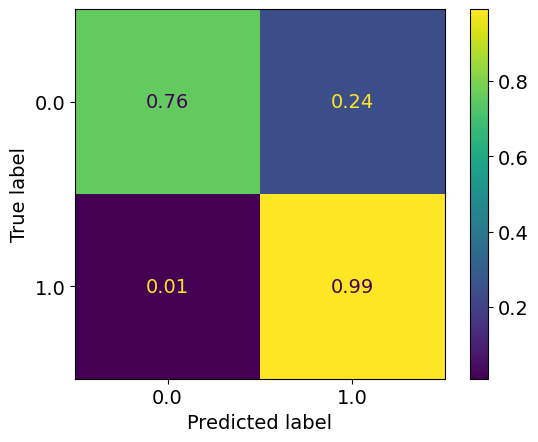

epoch: 300
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.1251692576387714
train acc: 0.9495812


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]


test loss: 0.20966968786987392
test acc: 0.9421312
epoch: 301
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.58it/s]


train loss: 0.1251062097060198
train acc: 0.9502752


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.89it/s]


test loss: 0.22778837044130673
test acc: 0.9390084
epoch: 302
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.12452638239702048
train acc: 0.9507764


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.84it/s]


test loss: 0.24746123870665376
test acc: 0.9356542
epoch: 303
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.12443675165403785
train acc: 0.950333


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.56it/s]


test loss: 0.20194041847505353
test acc: 0.93954813
epoch: 304
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.27it/s]


train loss: 0.12276385052700263
train acc: 0.95089203


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.17420171370560472
test acc: 0.94209266
epoch: 305
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.12341487063148807
train acc: 0.95037156


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.92it/s]


test loss: 0.24543093889951706
test acc: 0.9421698
epoch: 306
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.12358653592753273
train acc: 0.95091134


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.2227486383847215
test acc: 0.93438196
epoch: 307
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.1231977883618691
train acc: 0.9511041


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.2798602357506752
test acc: 0.936194
epoch: 308
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.12221528223656505
train acc: 0.95186555


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.98it/s]


test loss: 0.18513172458518634
test acc: 0.9440589
epoch: 309
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.12288469063236535
train acc: 0.95062214


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.02it/s]


test loss: 0.2642975757745179
test acc: 0.9302568


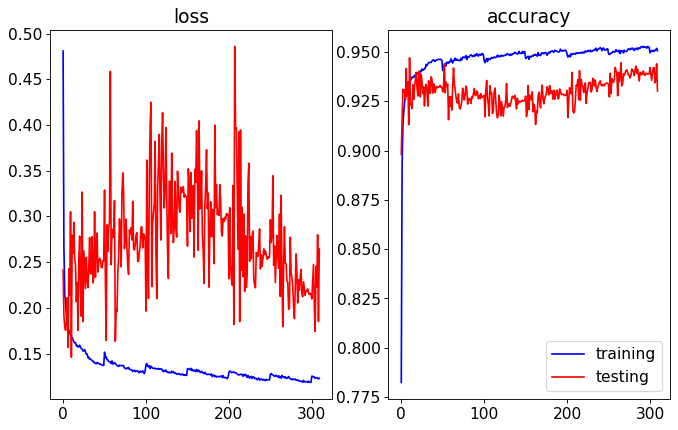

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.21it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


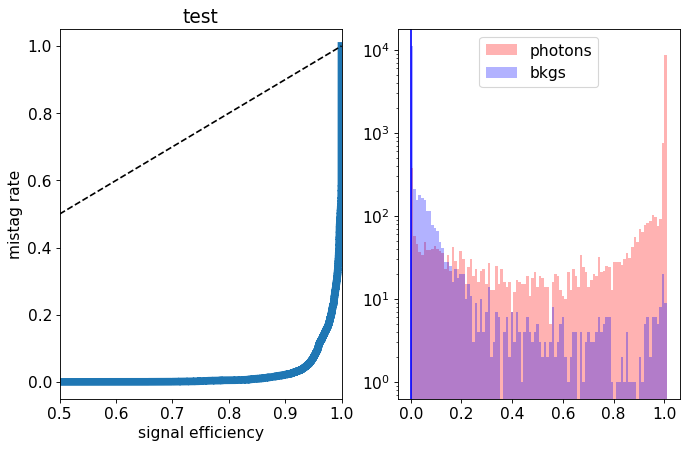

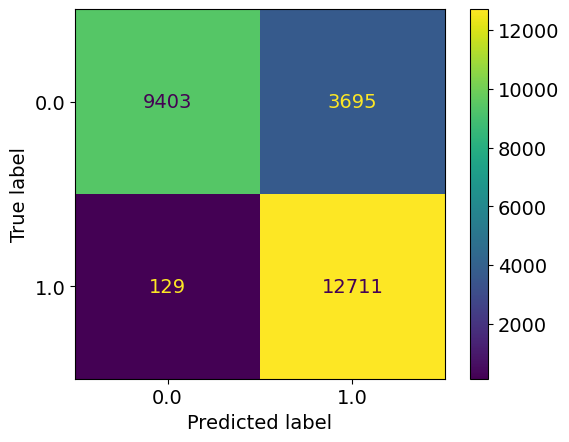

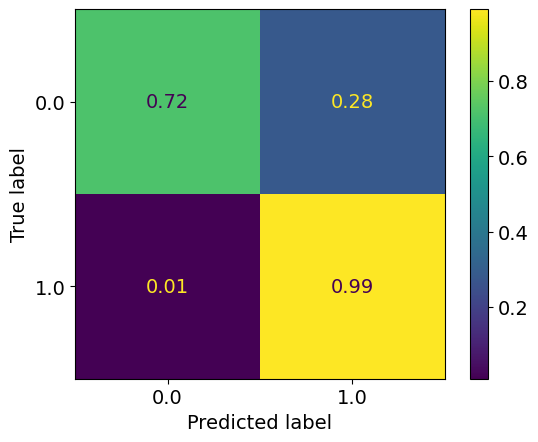

epoch: 310
Learning rate: 0.000904615209340528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.12391764334688297
train acc: 0.9503619


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.18191745030609044
test acc: 0.94251674
epoch: 311
Learning rate: 0.0008853723489545782


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.12387740909191915
train acc: 0.95014024


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.20618795332583514
test acc: 0.94166857
epoch: 312
Learning rate: 0.0008646085999671838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.1228708795815534
train acc: 0.9512583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.1758109090680426
test acc: 0.94344205
epoch: 313
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.12314763398184253
train acc: 0.9510559


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.38it/s]


test loss: 0.1981166758659211
test acc: 0.9430951
epoch: 314
Learning rate: 0.0008188518951657369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.1233375442854931
train acc: 0.95094985


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.95it/s]


test loss: 0.19040328772230583
test acc: 0.9418614
epoch: 315
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.12130898306135497
train acc: 0.951345


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.20454301989891313
test acc: 0.9387385
epoch: 316
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.12361584207570622
train acc: 0.94992816


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.01it/s]


test loss: 0.23737998476082628
test acc: 0.9350374
epoch: 317
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.12342232457130631
train acc: 0.9513065


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.92it/s]


test loss: 0.21028236807747322
test acc: 0.9418614
epoch: 318
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.12085429393831705
train acc: 0.95220286


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]


test loss: 0.16518813354725187
test acc: 0.94502276
epoch: 319
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.1229278984872592
train acc: 0.9511619


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.91it/s]


test loss: 0.2128911233422431
test acc: 0.9371193


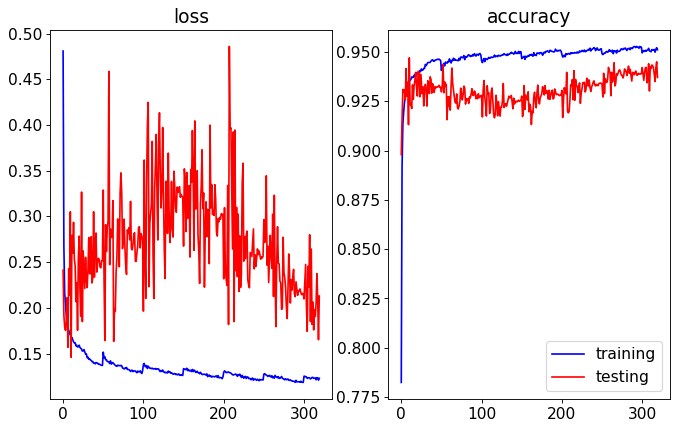

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


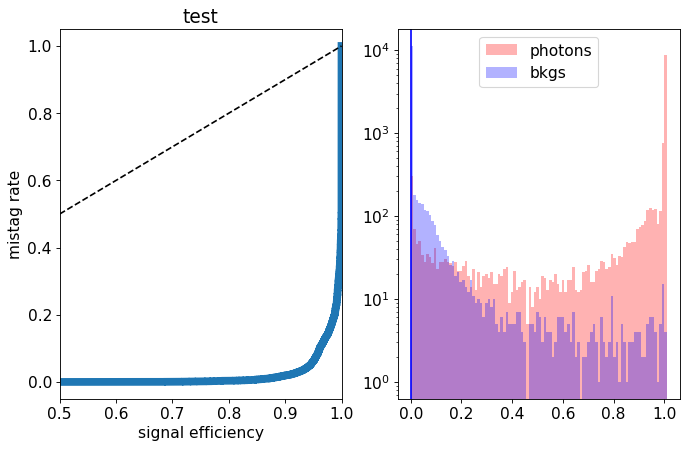

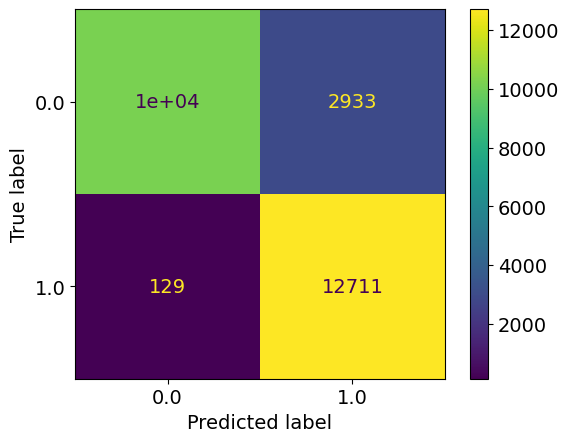

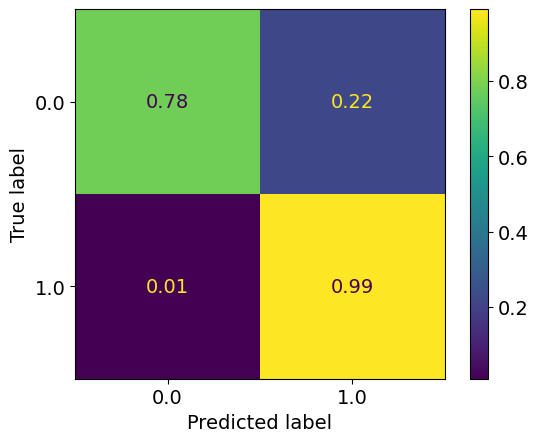

epoch: 320
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.12001093477010727
train acc: 0.9514029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.25it/s]


test loss: 0.1818111532113769
test acc: 0.9443288
epoch: 321
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.11979104358853632
train acc: 0.951827


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]


test loss: 0.19946835698051887
test acc: 0.9409361
epoch: 322
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.12056163539087152
train acc: 0.9516149


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.29it/s]


test loss: 0.18740014325488696
test acc: 0.9393554
epoch: 323
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.1214416281164037
train acc: 0.9517113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.05it/s]


test loss: 0.15963851728222586
test acc: 0.9460637
epoch: 324
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.12178007883660366
train acc: 0.95099807


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.01it/s]


test loss: 0.19080629369074648
test acc: 0.94386613
epoch: 325
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.12166469178103298
train acc: 0.951345


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.92it/s]


test loss: 0.20485476895489477
test acc: 0.94055057
epoch: 326
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.1205256454258985
train acc: 0.952386


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.20540231847288934
test acc: 0.94278663
epoch: 327
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.12018095667479355
train acc: 0.95199084


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.19it/s]


test loss: 0.21116085282780908
test acc: 0.94062763
epoch: 328
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.11860535112936373
train acc: 0.95231855


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.21092147752642632
test acc: 0.93804455
epoch: 329
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.11868045784834493
train acc: 0.95267516


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.17it/s]


test loss: 0.20807860046625137
test acc: 0.9393168


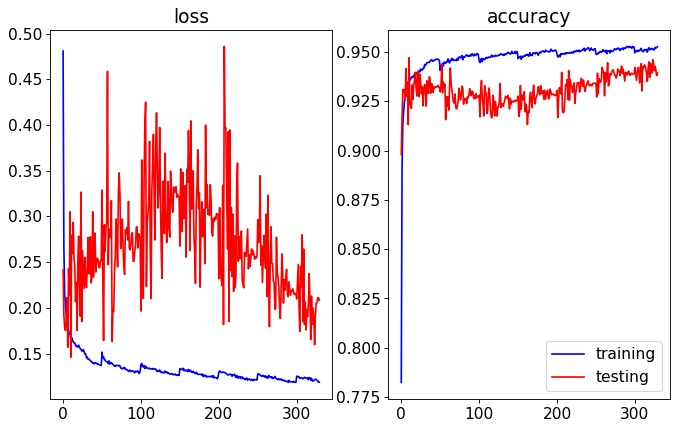

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


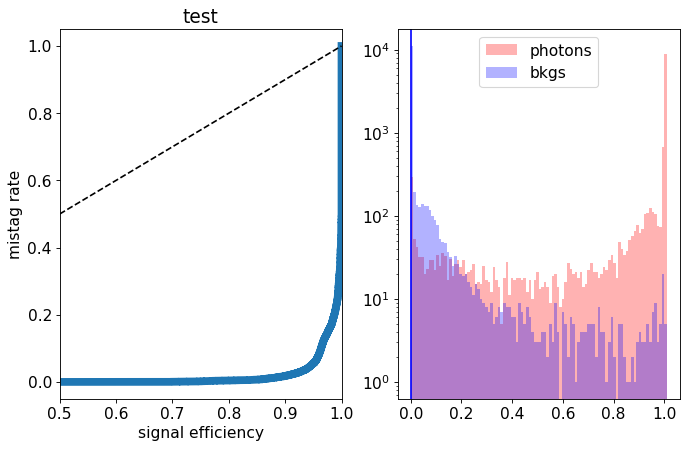

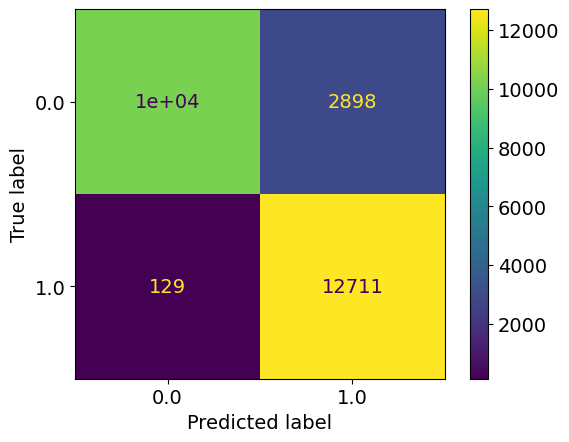

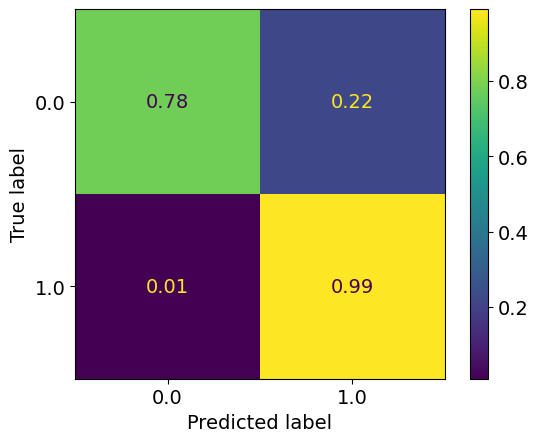

epoch: 330
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.11849468838789559
train acc: 0.952733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.19954788583246144
test acc: 0.9428252
epoch: 331
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.11972355691856043
train acc: 0.9520872


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.19it/s]


test loss: 0.19032228450206193
test acc: 0.94378906
epoch: 332
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.11720675880337036
train acc: 0.95331126


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.14it/s]


test loss: 0.18583033216947858
test acc: 0.94467574
epoch: 333
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.11891916915343675
train acc: 0.9521836


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.53it/s]


test loss: 0.16670719618824395
test acc: 0.94509983
epoch: 334
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.58it/s]


train loss: 0.11902978193725465
train acc: 0.9524342


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]


test loss: 0.1825464510104873
test acc: 0.94274807
epoch: 335
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.1192435703181118
train acc: 0.9528487


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.93it/s]


test loss: 0.18418201109902424
test acc: 0.94502276
epoch: 336
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.11848101924265052
train acc: 0.95312816


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.17178005886010148
test acc: 0.9440589
epoch: 337
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.11730476201786472
train acc: 0.95265585


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.19030449133027683
test acc: 0.9432107
epoch: 338
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11743966524483841
train acc: 0.95328236


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.16950701922178268
test acc: 0.9441746
epoch: 339
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.11785663237978268
train acc: 0.953186


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.51it/s]


test loss: 0.18858539550141853
test acc: 0.9436348


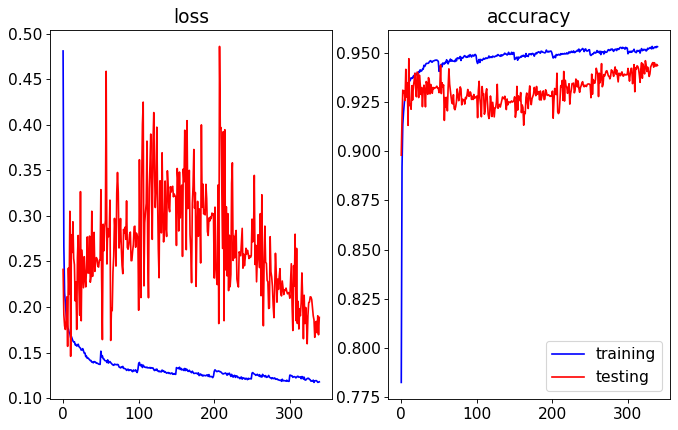

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.97it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


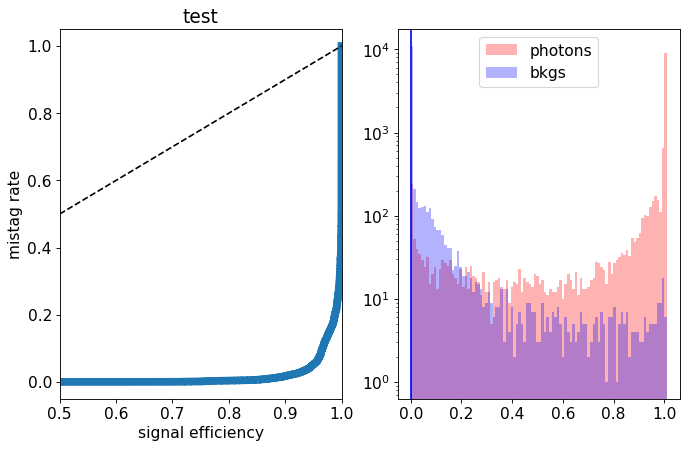

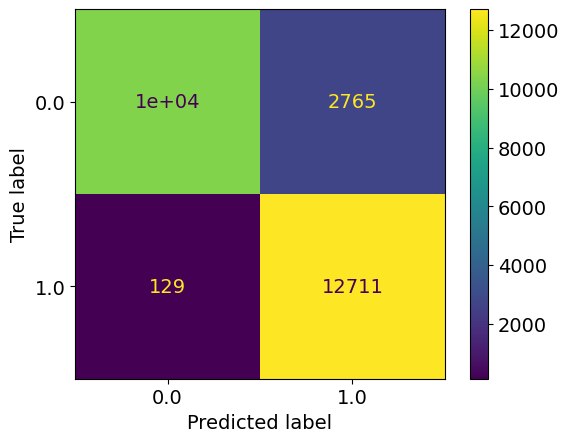

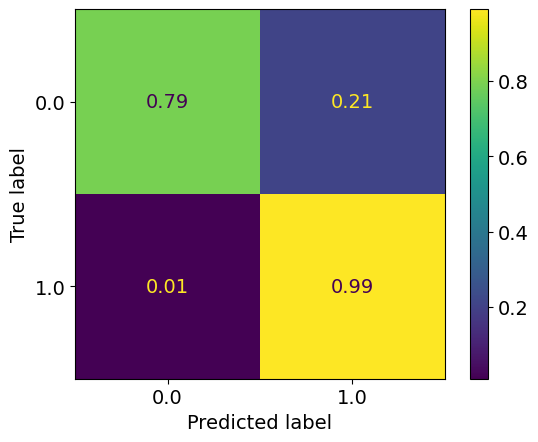

epoch: 340
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.11776575747597424
train acc: 0.95277154


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.14it/s]


test loss: 0.19943917999890717
test acc: 0.94286376
epoch: 341
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.11866452088418035
train acc: 0.9521354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.1892339170656421
test acc: 0.9417457
epoch: 342
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.11792952201269954
train acc: 0.9524245


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.98it/s]


test loss: 0.18384711207313972
test acc: 0.9432493
epoch: 343
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.19it/s]


train loss: 0.11756981474298962
train acc: 0.9528101


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.20it/s]


test loss: 0.18857023610987447
test acc: 0.94178426
epoch: 344
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.43it/s]


train loss: 0.1167545051157819
train acc: 0.95282936


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.34it/s]


test loss: 0.17966204983266917
test acc: 0.9433264
epoch: 345
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.18it/s]


train loss: 0.1170934231984133
train acc: 0.9528197


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.33it/s]


test loss: 0.18746152757243675
test acc: 0.9421698
epoch: 346
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.47it/s]


train loss: 0.11741427207268731
train acc: 0.95264626


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.16it/s]


test loss: 0.18627922880378636
test acc: 0.9433649
epoch: 347
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.61it/s]


train loss: 0.11675674059142956
train acc: 0.95361006


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.30it/s]


test loss: 0.18731388009407304
test acc: 0.9425553
epoch: 348
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.61it/s]


train loss: 0.11746572952911344
train acc: 0.9532631


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.16it/s]


test loss: 0.18712703765115954
test acc: 0.9424011
epoch: 349
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.11728988424201921
train acc: 0.95297396


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.71it/s]


test loss: 0.18750469420443883
test acc: 0.94251674


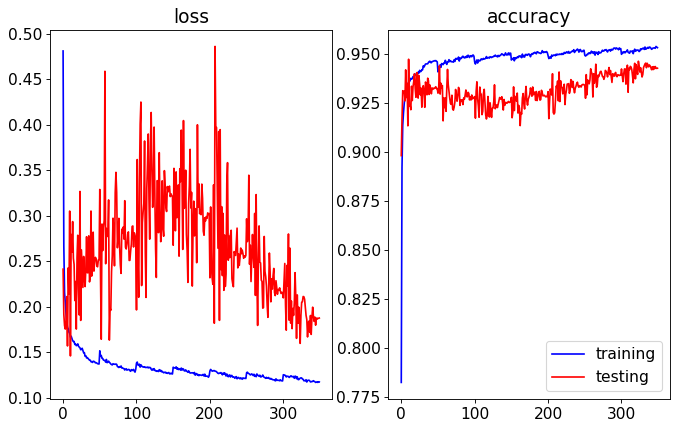

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.99it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


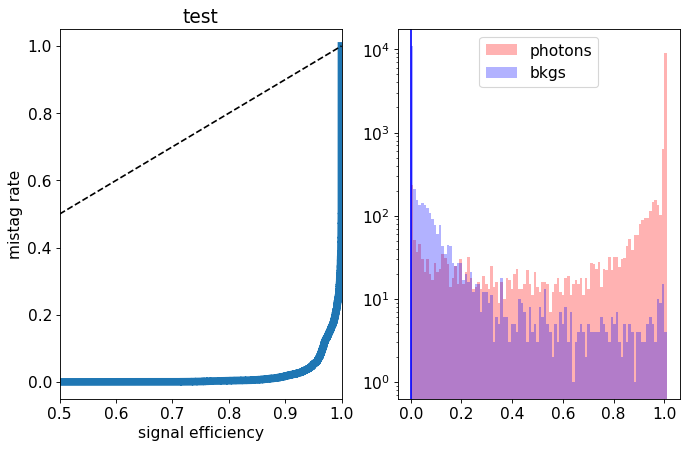

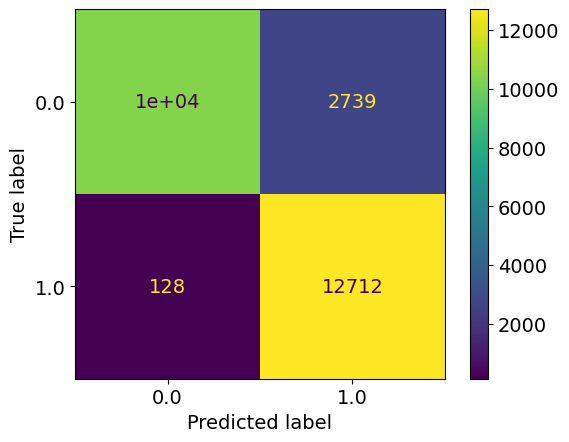

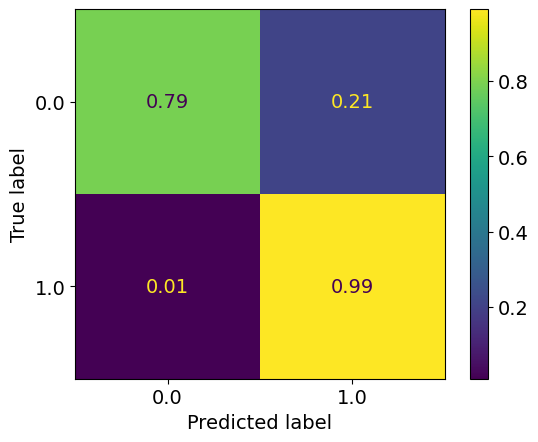

epoch: 350
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.26it/s]


train loss: 0.12256787682888824
train acc: 0.95055467


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.07it/s]


test loss: 0.13614160719920287
test acc: 0.9528491
new best acc: 0.9528491
epoch: 351
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.51it/s]


train loss: 0.12193105223378695
train acc: 0.95137393


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.1494630571793426
test acc: 0.94668055
epoch: 352
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.29it/s]


train loss: 0.1233581703350034
train acc: 0.95073783


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.17104682156985457
test acc: 0.9475673
epoch: 353
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.12364395303016452
train acc: 0.9502366


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.20it/s]


test loss: 0.17927064475688068
test acc: 0.9498805
epoch: 354
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.1235737414287694
train acc: 0.95019805


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.18442695723338562
test acc: 0.9371193
epoch: 355
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.52it/s]


train loss: 0.12235688241575494
train acc: 0.9508439


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.19it/s]


test loss: 0.20742675916037775
test acc: 0.9454854
epoch: 356
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.12205919787029311
train acc: 0.95142215


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.1769748960028995
test acc: 0.94571674
epoch: 357
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.52it/s]


train loss: 0.1222294677113522
train acc: 0.95200044


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.19it/s]


test loss: 0.19145028868859465
test acc: 0.94421315
epoch: 358
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.12144871430762241
train acc: 0.9513258


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.23it/s]


test loss: 0.19539051994004034
test acc: 0.94274807
epoch: 359
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.52it/s]


train loss: 0.1230777574843065
train acc: 0.95115227


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.2204065393995155
test acc: 0.93546146


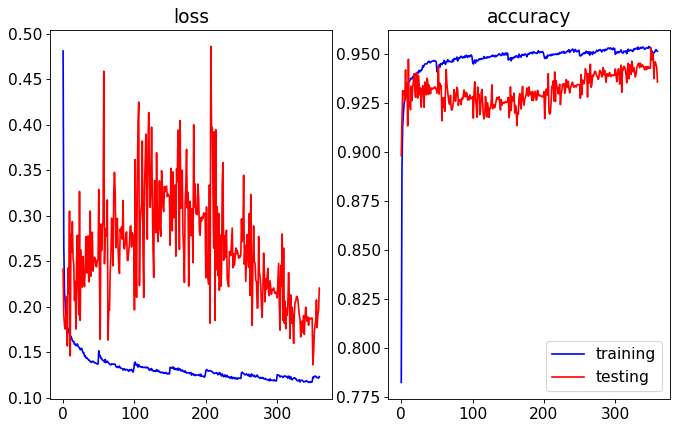

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.71it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


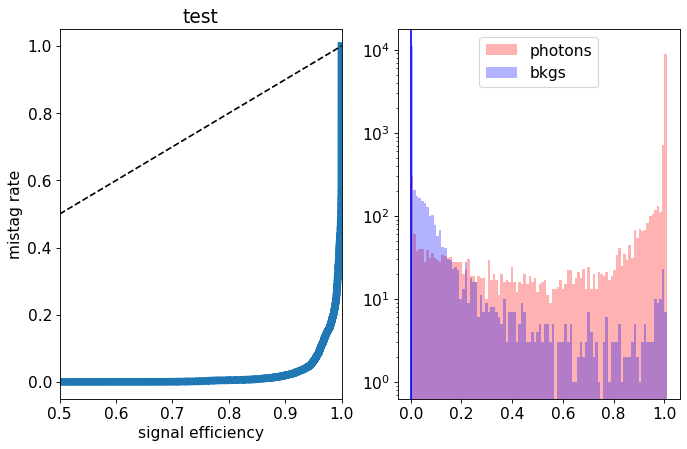

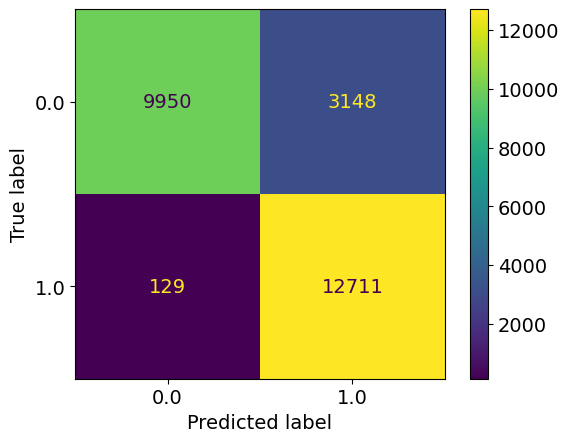

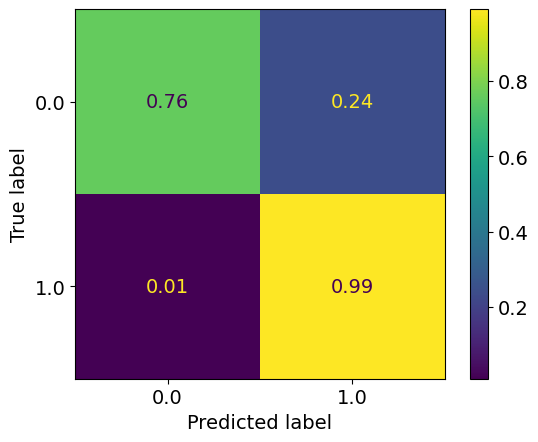

epoch: 360
Learning rate: 0.000904615209340528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.52it/s]


train loss: 0.12269112584046546
train acc: 0.9513161


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.95it/s]


test loss: 0.16810028729113666
test acc: 0.9460637
epoch: 361
Learning rate: 0.0008853723489545782


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.11966436145278071
train acc: 0.9520872


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.05it/s]


test loss: 0.19693914326754483
test acc: 0.94382757
epoch: 362
Learning rate: 0.0008646085999671838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.1201898547352394
train acc: 0.9520583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.15918905220248483
test acc: 0.9464878
epoch: 363
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.12102624653391755
train acc: 0.95181733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.14039756239137866
test acc: 0.9510371
epoch: 364
Learning rate: 0.0008188518951657369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.12132331819375815
train acc: 0.95094025


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.16138890436427158
test acc: 0.9490709
epoch: 365
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.12086103408667394
train acc: 0.9517113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.18434451791373166
test acc: 0.9465649
epoch: 366
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.11974190067865945
train acc: 0.9523089


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.99it/s]


test loss: 0.18388553014533085
test acc: 0.94722027
epoch: 367
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.22it/s]


train loss: 0.12041054963204213
train acc: 0.9513161


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.36it/s]


test loss: 0.14762239124287257
test acc: 0.9486468
epoch: 368
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.52it/s]


train loss: 0.1199128122601895
train acc: 0.9519523


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.14627940512516283
test acc: 0.9511142
epoch: 369
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.12033888025779944
train acc: 0.9519812


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.00it/s]


test loss: 0.16631010056219317
test acc: 0.94463724


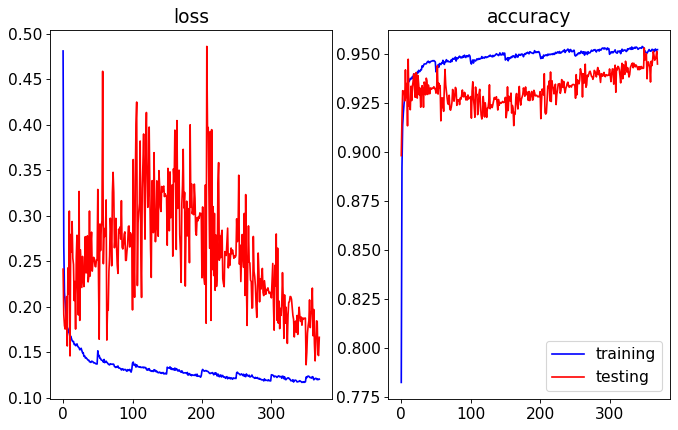

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


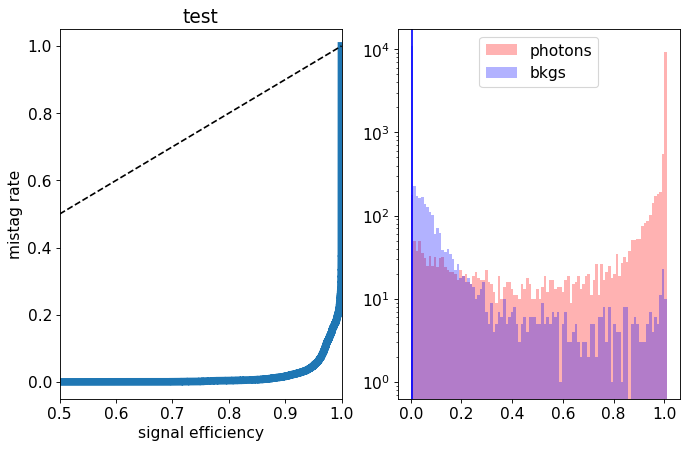

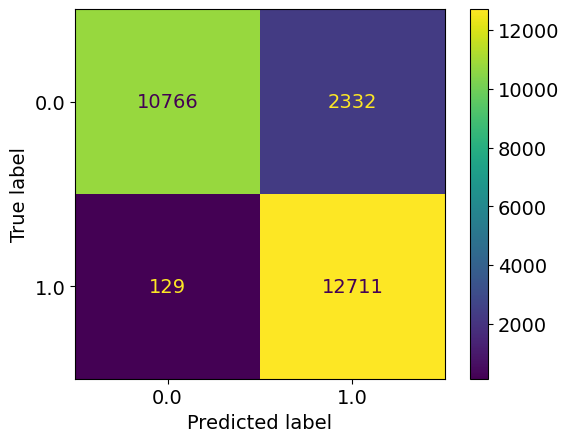

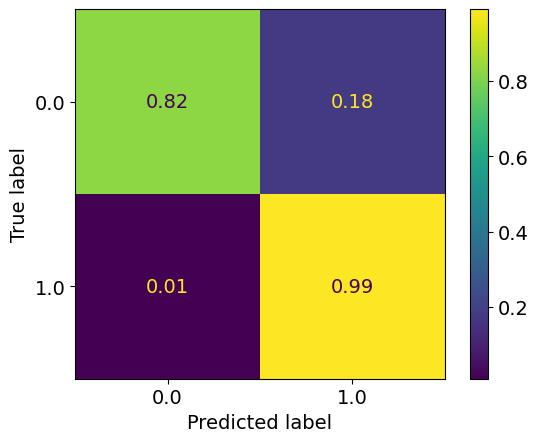

epoch: 370
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.11958578569179325
train acc: 0.95237637


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.94it/s]


test loss: 0.1544096894900907
test acc: 0.9485311
epoch: 371
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.12045965903583979
train acc: 0.95204866


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.14it/s]


test loss: 0.18568166362291033
test acc: 0.9474131
epoch: 372
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.11941151717150142
train acc: 0.95244384


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.16052905876528134
test acc: 0.94926363
epoch: 373
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11851774784870919
train acc: 0.95220286


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.17617987214841627
test acc: 0.9444444
epoch: 374
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.120305223228959
train acc: 0.9522125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.98it/s]


test loss: 0.17012271251190791
test acc: 0.9437505
epoch: 375
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.11878885862799739
train acc: 0.9521065


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.1751031538640911
test acc: 0.9465649
epoch: 376
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.11879266234319334
train acc: 0.95199084


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.19297923537140543
test acc: 0.94776005
epoch: 377
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11835459120184011
train acc: 0.95282936


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.17326435243541544
test acc: 0.9440589
epoch: 378
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.11916497056883883
train acc: 0.95223176


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.22it/s]


test loss: 0.17376336607743392
test acc: 0.9483769
epoch: 379
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.1169252660491563
train acc: 0.9529354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.19797894900495355
test acc: 0.942671


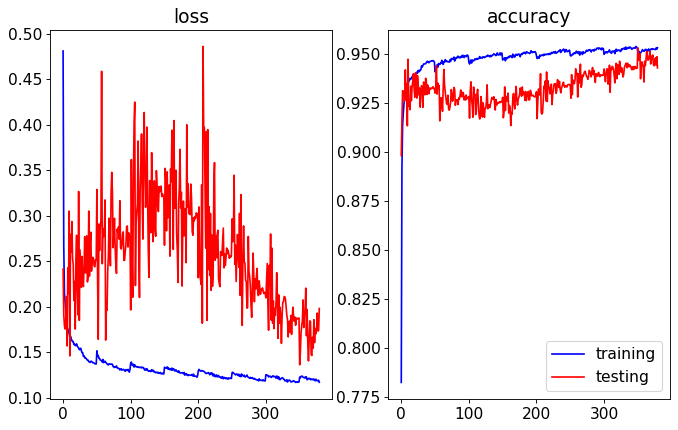

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.19it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


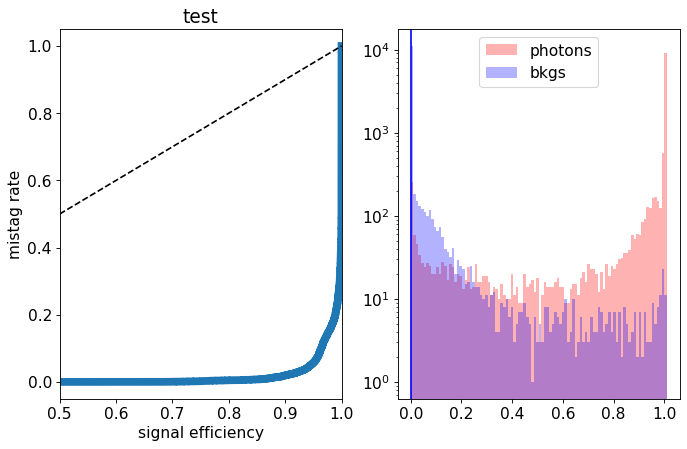

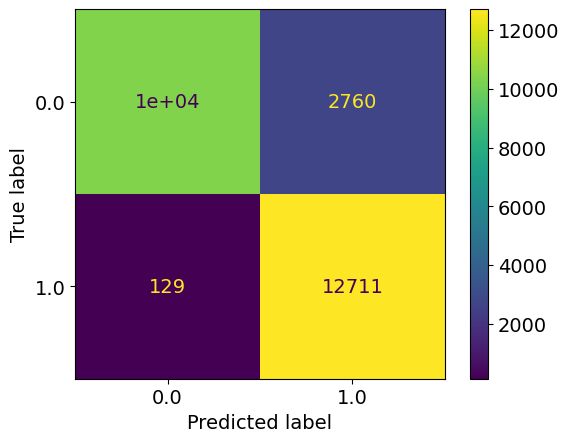

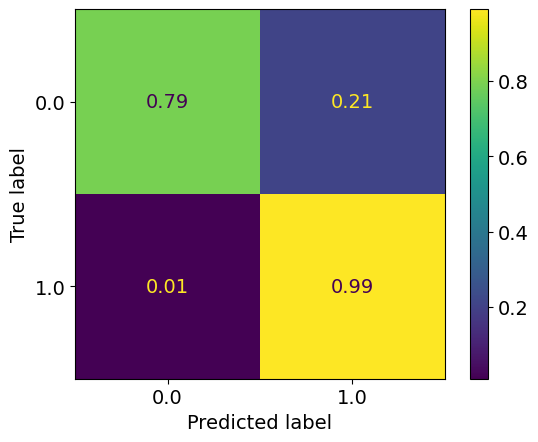

epoch: 380
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.1172881065248754
train acc: 0.95352334


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.20it/s]


test loss: 0.16600329378111797
test acc: 0.9456396
epoch: 381
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.11703332556637726
train acc: 0.9534751


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.01it/s]


test loss: 0.15552760897712273
test acc: 0.94706607
epoch: 382
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.11749516332769669
train acc: 0.9525884


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.00it/s]


test loss: 0.16323610175062309
test acc: 0.94625646
epoch: 383
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.11741752849321145
train acc: 0.95334023


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.01it/s]


test loss: 0.15777668915688992
test acc: 0.94706607
epoch: 384
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.62it/s]


train loss: 0.11732273557454864
train acc: 0.95274264


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.16895733528177848
test acc: 0.9412445
epoch: 385
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.11727996984485946
train acc: 0.95291615


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.05it/s]


test loss: 0.16411497714844617
test acc: 0.94509983
epoch: 386
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11743081128493899
train acc: 0.952839


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.17448700659654356
test acc: 0.94625646
epoch: 387
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.11543651140494153
train acc: 0.95393777


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.168359358032996
test acc: 0.94610226
epoch: 388
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.11626887209498124
train acc: 0.9533209


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.16186604293232615
test acc: 0.9470275
epoch: 389
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.36it/s]


train loss: 0.11701300283732442
train acc: 0.9535137


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.27it/s]


test loss: 0.17096298171037977
test acc: 0.9453697


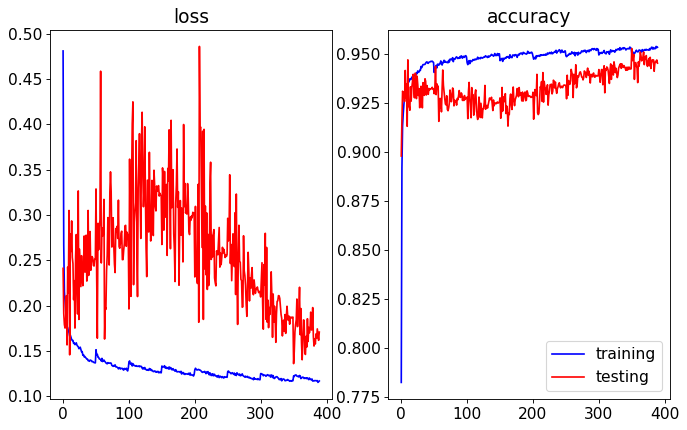

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.21it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


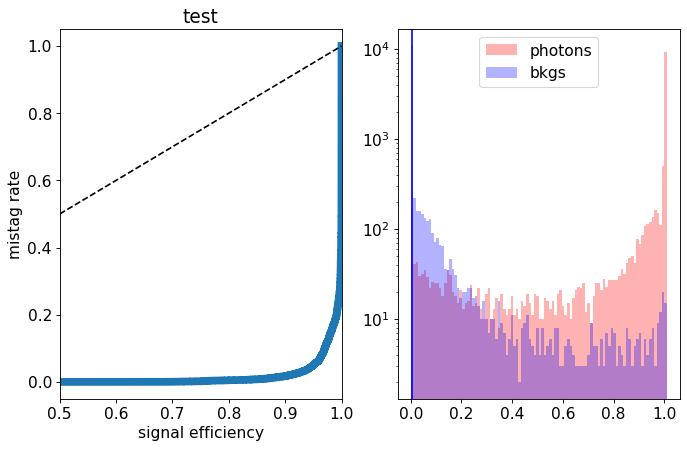

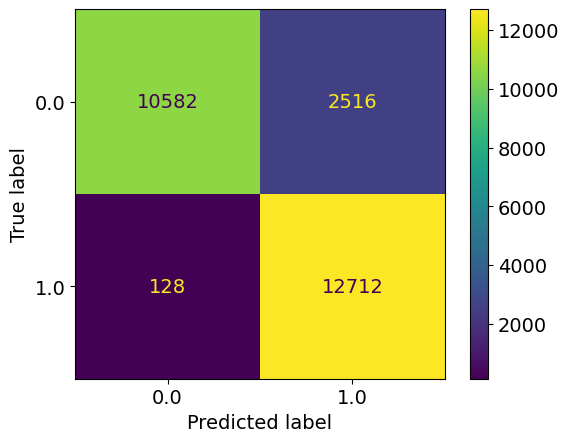

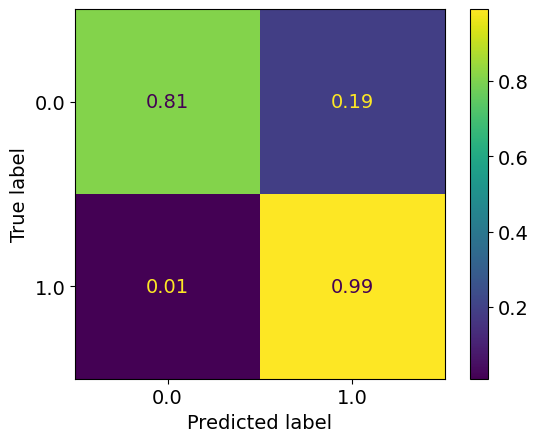

epoch: 390
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.11642515857440199
train acc: 0.95352334


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.98it/s]


test loss: 0.1882352444597266
test acc: 0.94409746
epoch: 391
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.11598654203332229
train acc: 0.95382214


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.66it/s]


test loss: 0.1878029297698628
test acc: 0.9439818
epoch: 392
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.11487424485600753
train acc: 0.95324385


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.73it/s]


test loss: 0.16981175254014405
test acc: 0.94575524
epoch: 393
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.1139986466379524
train acc: 0.95408237


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.94it/s]


test loss: 0.1761955784803087
test acc: 0.9439047
epoch: 394
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.1149703203512065
train acc: 0.95389926


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.27it/s]


test loss: 0.17363496260209518
test acc: 0.94560105
epoch: 395
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.11652692015460461
train acc: 0.95336914


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.18it/s]


test loss: 0.17221311987801033
test acc: 0.9461408
epoch: 396
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.1156123782255057
train acc: 0.95385104


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.98it/s]


test loss: 0.1742672473192215
test acc: 0.9455239
epoch: 397
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11571582837428661
train acc: 0.95330167


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.99it/s]


test loss: 0.17635779523036696
test acc: 0.9452926
epoch: 398
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.26it/s]


train loss: 0.11484797544389791
train acc: 0.95397633


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.00it/s]


test loss: 0.1762555573474277
test acc: 0.9452541
epoch: 399
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.11473959671451867
train acc: 0.95423657


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.177675866775892
test acc: 0.9452541


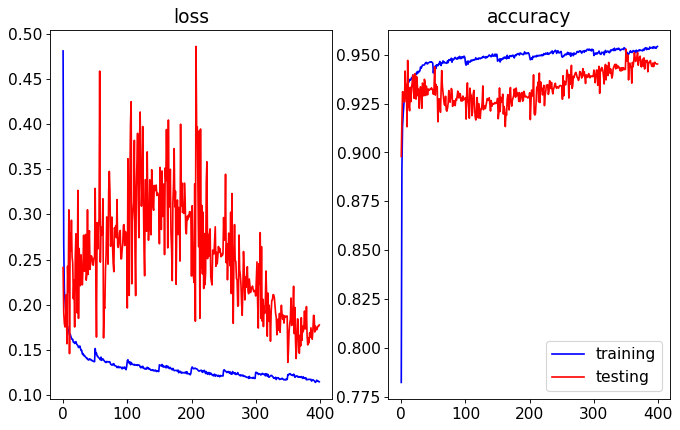

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


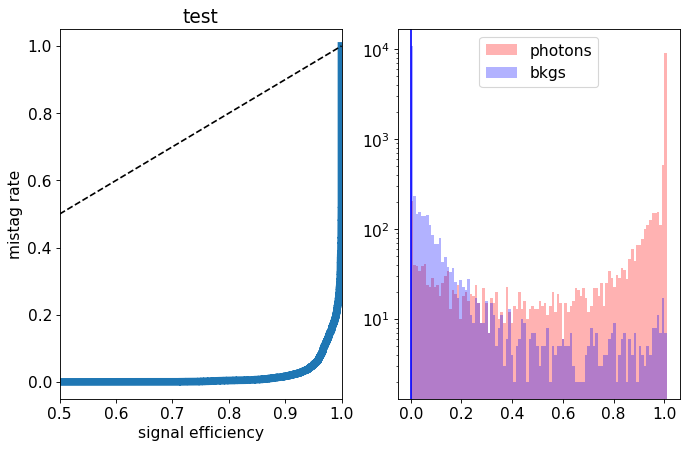

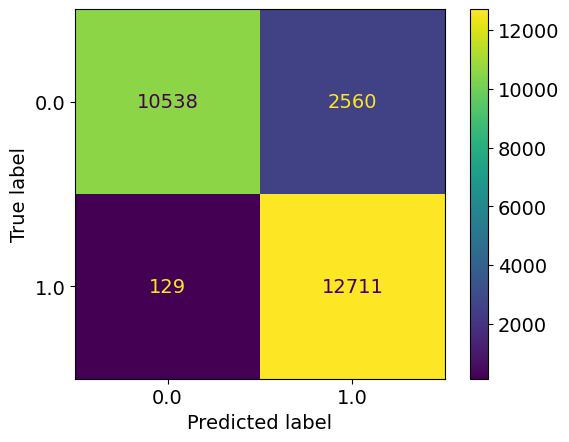

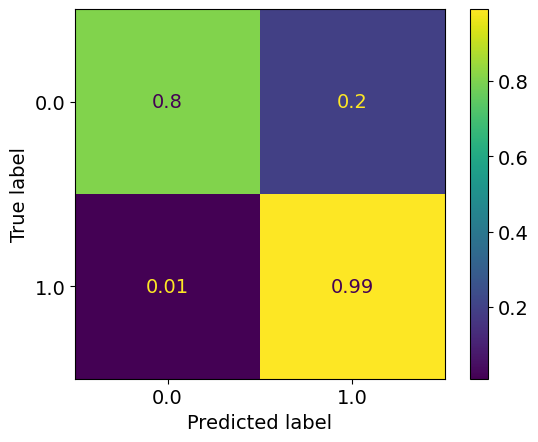

epoch: 400
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.12144611138484382
train acc: 0.95067036


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.15940892256119035
test acc: 0.9434806
epoch: 401
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.12139008009020304
train acc: 0.951027


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.19045943986963143
test acc: 0.9402807
epoch: 402
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.26it/s]


train loss: 0.12214852232119941
train acc: 0.9510077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.05it/s]


test loss: 0.1665906130590222
test acc: 0.9479914
epoch: 403
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.52it/s]


train loss: 0.12176946895143201
train acc: 0.9516824


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.57it/s]


test loss: 0.17807536707683044
test acc: 0.94263244
epoch: 404
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:34<00:00,  5.00it/s]


train loss: 0.1205148522908977
train acc: 0.9510077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.20216283896429973
test acc: 0.9420156
epoch: 405
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.12079814868855339
train acc: 0.9518077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.26it/s]


test loss: 0.16305639645592732
test acc: 0.94509983
epoch: 406
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.51it/s]


train loss: 0.11965701767819466
train acc: 0.95193297


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.29it/s]


test loss: 0.13477381234141914
test acc: 0.95130694
epoch: 407
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.43it/s]


train loss: 0.1209601557495966
train acc: 0.95157635


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.16it/s]


test loss: 0.2060216267339208
test acc: 0.9454083
epoch: 408
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.11888860329727217
train acc: 0.95219326


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.21050914698703724
test acc: 0.9440589
epoch: 409
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.12042876643080243
train acc: 0.9517113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.18it/s]


test loss: 0.184610544111241
test acc: 0.9453697


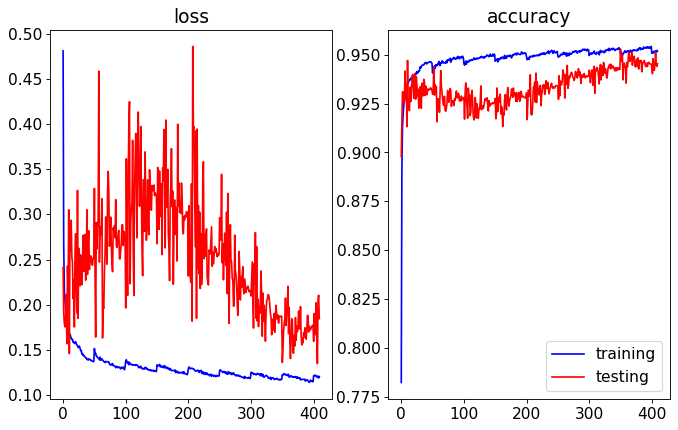

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.19it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


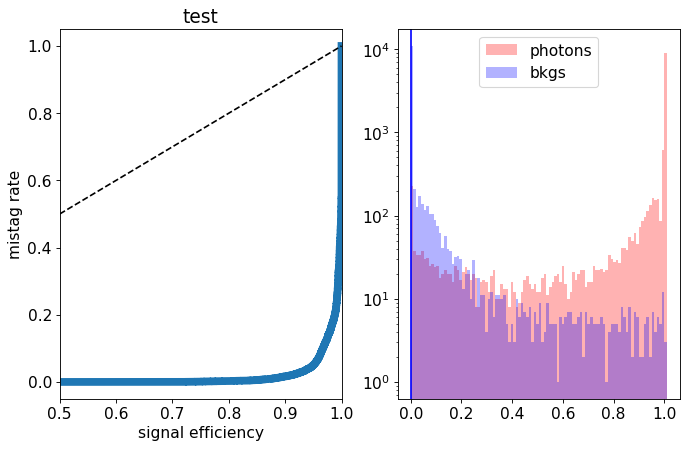

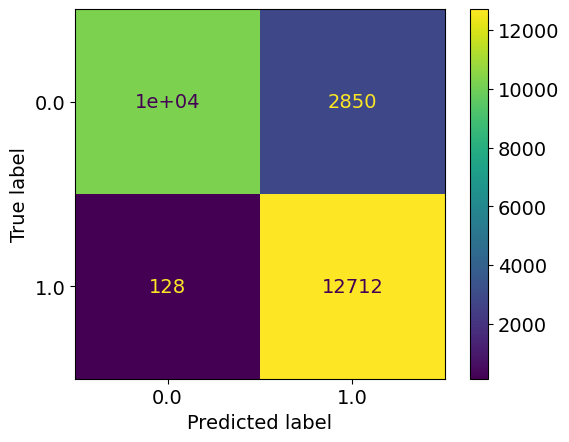

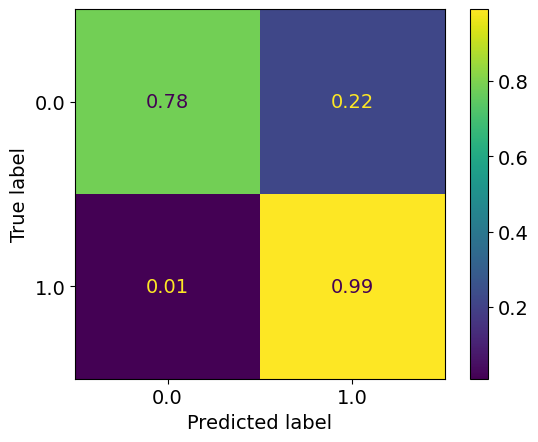

epoch: 410
Learning rate: 0.000904615209340528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.12000402790962617
train acc: 0.9517981


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.190669995309277
test acc: 0.94278663
epoch: 411
Learning rate: 0.0008853723489545782


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.13it/s]


train loss: 0.1212895785194601
train acc: 0.95052576


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.85it/s]


test loss: 0.20881083167412065
test acc: 0.9382759
epoch: 412
Learning rate: 0.0008646085999671838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.1189427716022282
train acc: 0.9519523


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.00it/s]


test loss: 0.13279969770122657
test acc: 0.9497263
epoch: 413
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.11988588026321004
train acc: 0.9523956


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.17376043715260245
test acc: 0.945948
epoch: 414
Learning rate: 0.0008188518951657369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.12007466893147871
train acc: 0.95197153


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.14it/s]


test loss: 0.17424363642930984
test acc: 0.94776005
epoch: 415
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.1200408493680072
train acc: 0.95157635


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.19it/s]


test loss: 0.21353331733156333
test acc: 0.94178426
epoch: 416
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.11825227737426758
train acc: 0.95277154


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.18it/s]


test loss: 0.14102422073483467
test acc: 0.9477215
epoch: 417
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.37it/s]


train loss: 0.11863200728259335
train acc: 0.95244384


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.23it/s]


test loss: 0.21017775853926485
test acc: 0.9437505
epoch: 418
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.58it/s]


train loss: 0.11848230711642029
train acc: 0.95262694


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]


test loss: 0.1712898017669266
test acc: 0.9494178
epoch: 419
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.37it/s]


train loss: 0.1197207008483093
train acc: 0.95177877


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.17it/s]


test loss: 0.17447459037331017
test acc: 0.9459095


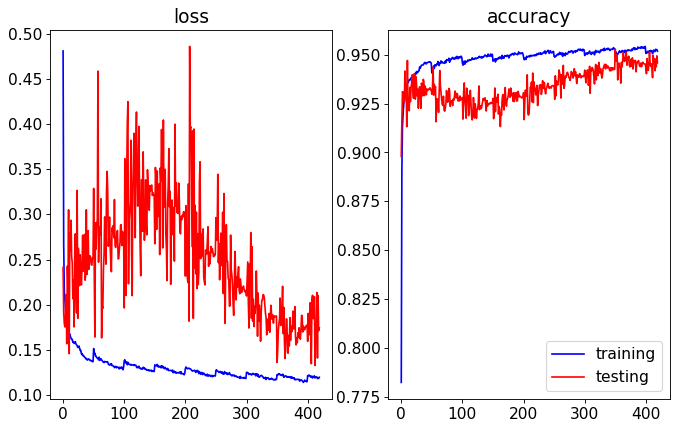

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.89it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


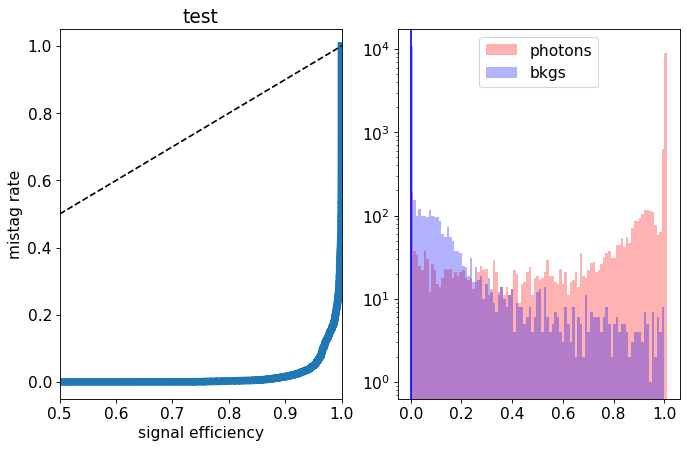

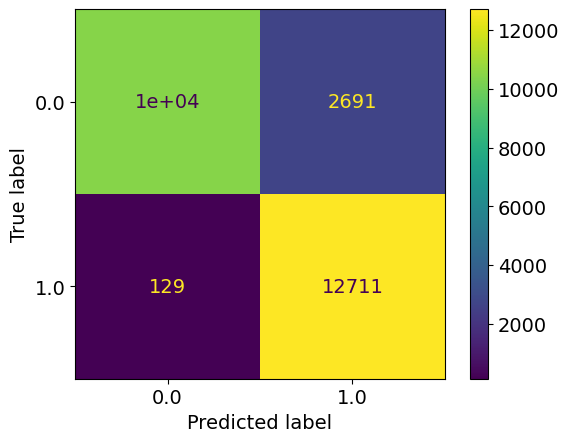

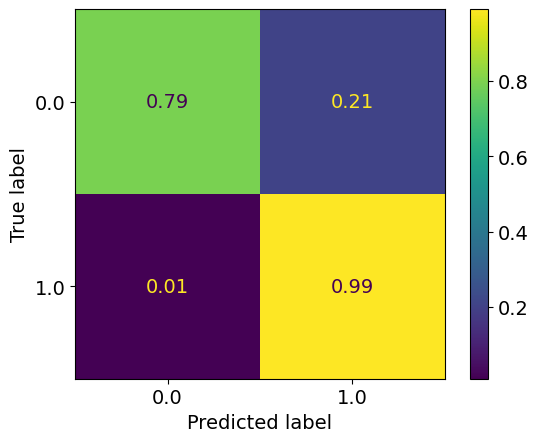

epoch: 420
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.1196217188514726
train acc: 0.95121974


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.05it/s]


test loss: 0.1589000245386904
test acc: 0.95045877
epoch: 421
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.44it/s]


train loss: 0.11810115617134667
train acc: 0.9530221


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.20141272788698023
test acc: 0.9469119
epoch: 422
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.29it/s]


train loss: 0.11684959868475192
train acc: 0.95262694


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.15820264274423773
test acc: 0.94841546
epoch: 423
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.11715348207020346
train acc: 0.952733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.20744676583192564
test acc: 0.9400879
epoch: 424
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.1176735347061488
train acc: 0.95190406


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.20028133876621723
test acc: 0.94236255
epoch: 425
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11723294836937348
train acc: 0.9531089


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]


test loss: 0.19148365340449594
test acc: 0.9434806
epoch: 426
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.11691438652187414
train acc: 0.9532149


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.1745877443728122
test acc: 0.94602513
epoch: 427
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.11770088884527284
train acc: 0.95289683


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.1631725477901372
test acc: 0.9463336
epoch: 428
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.11622481952512885
train acc: 0.95402455


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.96it/s]


test loss: 0.16860428808087652
test acc: 0.9464492
epoch: 429
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.11717405721459086
train acc: 0.9532149


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.89it/s]


test loss: 0.15717113932425325
test acc: 0.9496106


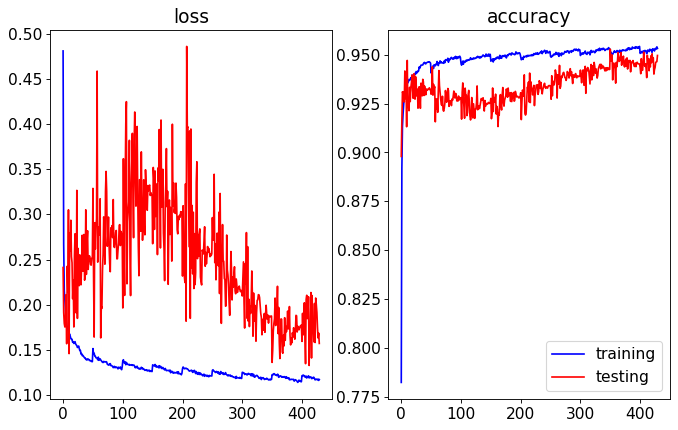

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.69it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


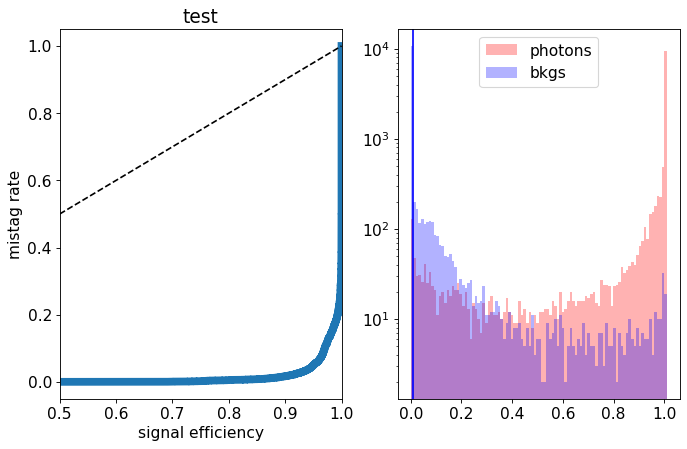

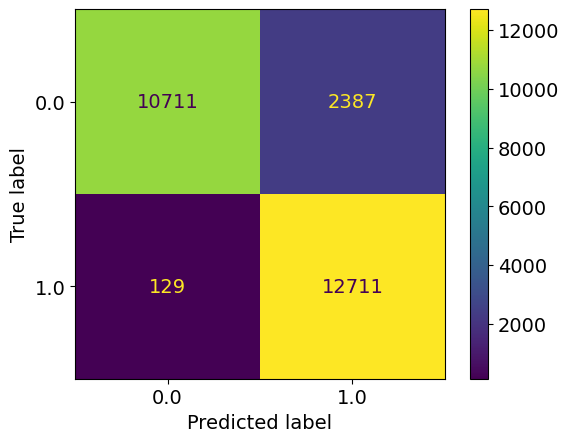

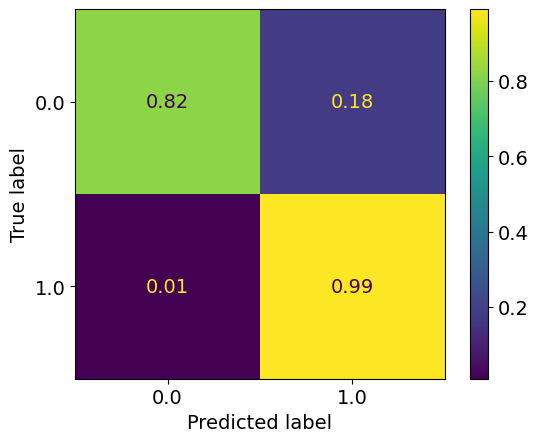

epoch: 430
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.11709916703618331
train acc: 0.953745


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.1694061764600602
test acc: 0.94479144
epoch: 431
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.28it/s]


train loss: 0.11578474249798439
train acc: 0.9535908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.56it/s]


test loss: 0.2060300103304061
test acc: 0.9408204
epoch: 432
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.44it/s]


train loss: 0.1143145581029054
train acc: 0.9539571


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.37it/s]


test loss: 0.1795231754129583
test acc: 0.946989
epoch: 433
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.25it/s]


train loss: 0.11572207295136645
train acc: 0.9533306


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.96it/s]


test loss: 0.16909843175248665
test acc: 0.9465649
epoch: 434
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11544424054250552
train acc: 0.953533


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.99it/s]


test loss: 0.16309297846799548
test acc: 0.9467191
epoch: 435
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.11569989756869443
train acc: 0.95389926


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.20it/s]


test loss: 0.17367866144261576
test acc: 0.94706607
epoch: 436
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11502493439899014
train acc: 0.9541113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.16855822977694598
test acc: 0.9470275
epoch: 437
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.11546946416011436
train acc: 0.9540631


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.23it/s]


test loss: 0.1771703873845664
test acc: 0.94494563
epoch: 438
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.11423400630151605
train acc: 0.95375466


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.18267982774837452
test acc: 0.9444444
epoch: 439
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.39it/s]


train loss: 0.11467744207623377
train acc: 0.95460284


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.24it/s]


test loss: 0.15248195835473863
test acc: 0.9480685


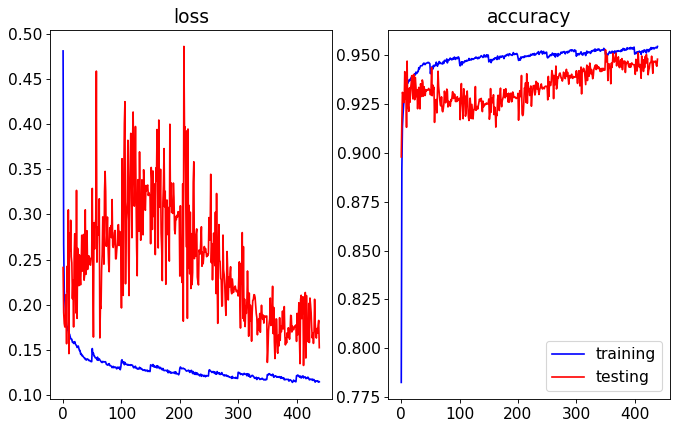

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


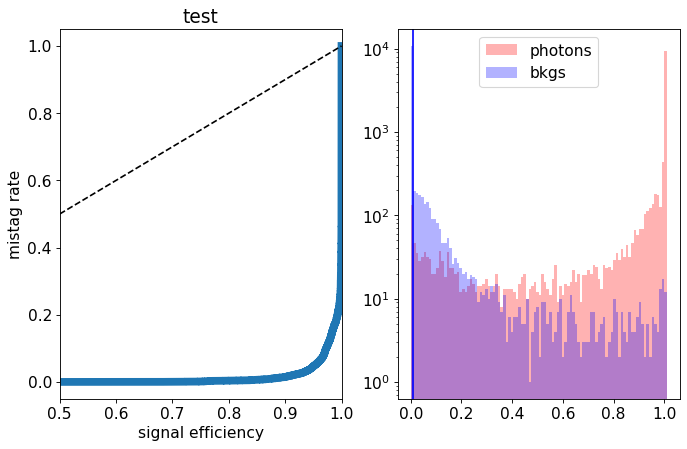

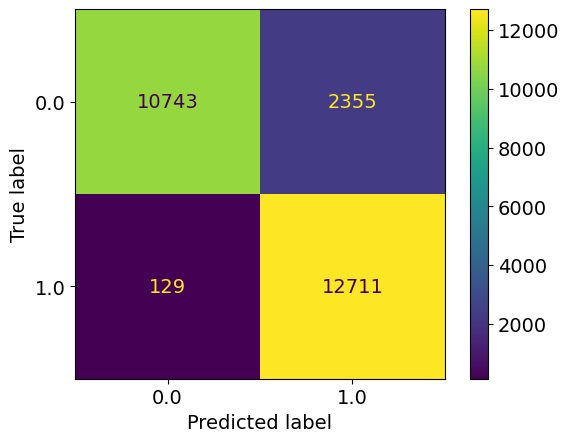

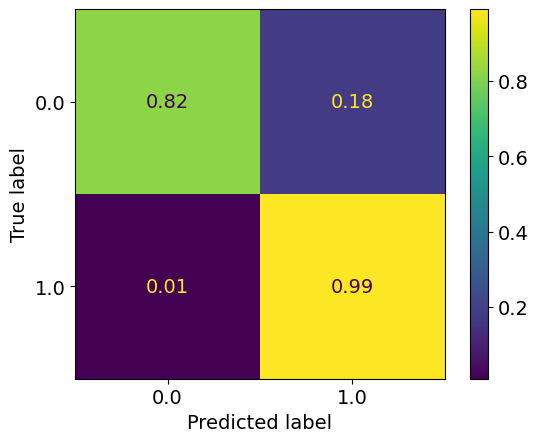

epoch: 440
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.11437697148736502
train acc: 0.9547956


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.46it/s]


test loss: 0.1706767539409074
test acc: 0.9456396
epoch: 441
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11508306559455188
train acc: 0.9534751


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.20it/s]


test loss: 0.17634384452619337
test acc: 0.9451384
epoch: 442
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.36it/s]


train loss: 0.1134630205658819
train acc: 0.9548245


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.22it/s]


test loss: 0.1855465451424772
test acc: 0.94483
epoch: 443
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11409961729380437
train acc: 0.9543908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]


test loss: 0.1684607555243102
test acc: 0.94749016
epoch: 444
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.11438370737209486
train acc: 0.9538318


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.17473880337043243
test acc: 0.9454854
epoch: 445
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11447129501945022
train acc: 0.95505583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.17073801583187145
test acc: 0.9463721
epoch: 446
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.11372918713127257
train acc: 0.9545932


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.18it/s]


test loss: 0.17311626266349445
test acc: 0.9462179
epoch: 447
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.11430486373474143
train acc: 0.9541306


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.17221155305477706
test acc: 0.94610226
epoch: 448
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.11341992287622021
train acc: 0.95436186


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.98it/s]


test loss: 0.1729003485630859
test acc: 0.94610226
epoch: 449
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.11462831794354268
train acc: 0.9537836


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.17265981503508307
test acc: 0.9461408


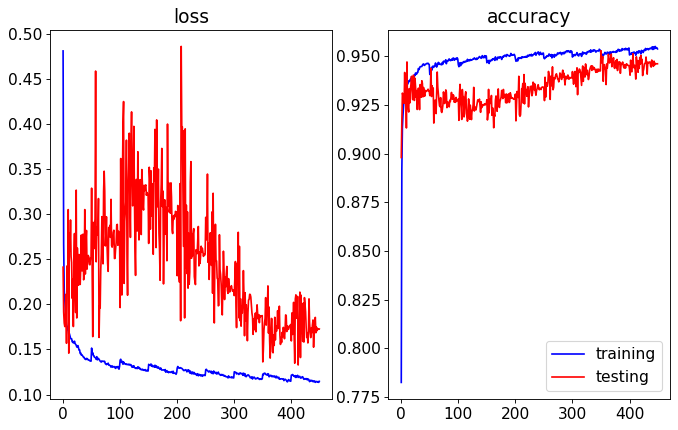

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


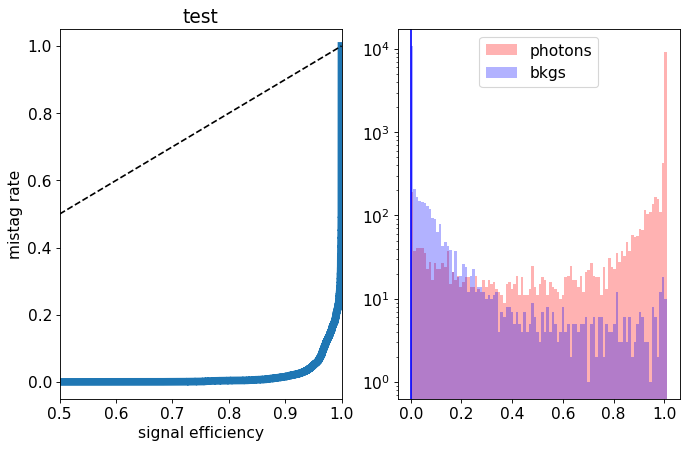

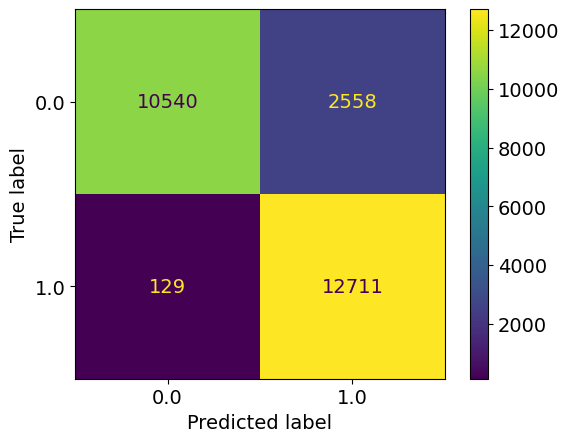

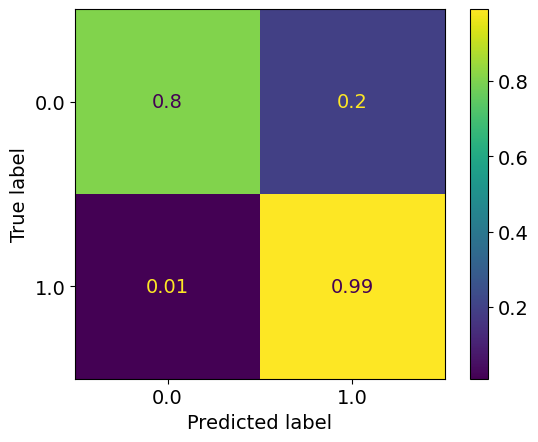

epoch: 450
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.12105435770371056
train acc: 0.9512294


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.17it/s]


test loss: 0.15255098874596032
test acc: 0.95022744
epoch: 451
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.1200650569503707
train acc: 0.9523089


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.31it/s]


test loss: 0.17987783845852723
test acc: 0.9473745
epoch: 452
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.1203445144902075
train acc: 0.9520968


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.22it/s]


test loss: 0.16103821400214324
test acc: 0.9482227
epoch: 453
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11846113347076956
train acc: 0.9525402


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.44it/s]


test loss: 0.16923732276667247
test acc: 0.9489552
epoch: 454
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.11946708915722852
train acc: 0.95174986


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.95it/s]


test loss: 0.1825247991152785
test acc: 0.9437505
epoch: 455
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.1194082439118038
train acc: 0.95250165


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.34it/s]


test loss: 0.20525224760852076
test acc: 0.94205415
epoch: 456
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11945427756089007
train acc: 0.95214504


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.14it/s]


test loss: 0.16204325905577702
test acc: 0.94868535
epoch: 457
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.11835526498411432
train acc: 0.9518848


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.15048598328774626
test acc: 0.9449842
epoch: 458
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.11832394924639278
train acc: 0.9521836


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.19it/s]


test loss: 0.19924661754207176
test acc: 0.94301796
epoch: 459
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.1193664939589583
train acc: 0.9523089


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.55it/s]


test loss: 0.15044030073014172
test acc: 0.95180815


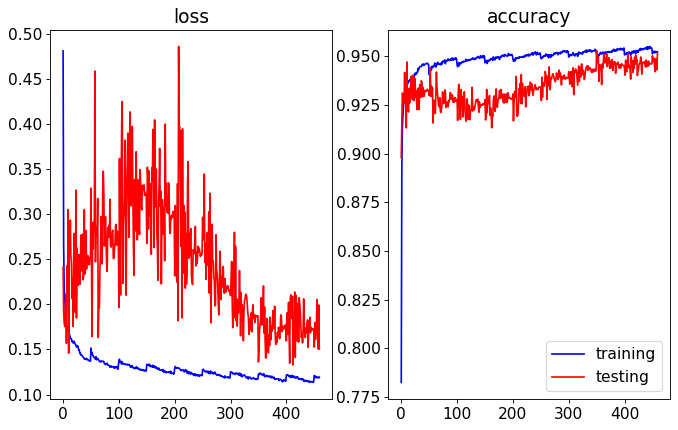

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.53it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


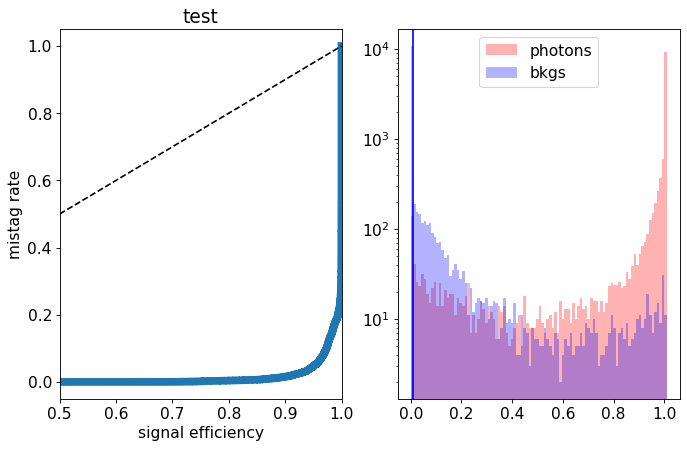

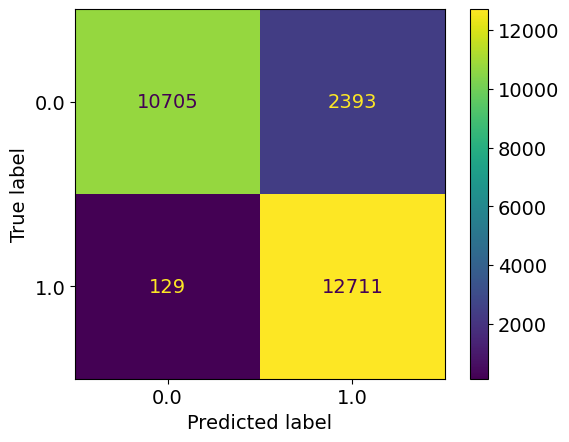

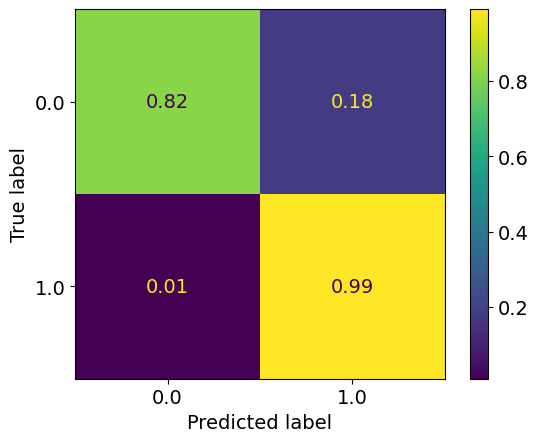

epoch: 460
Learning rate: 0.000904615209340528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.46it/s]


train loss: 0.11884973891553162
train acc: 0.95193297


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.44it/s]


test loss: 0.14066679470918395
test acc: 0.95115274
epoch: 461
Learning rate: 0.0008853723489545782


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.22it/s]


train loss: 0.11874456923304266
train acc: 0.95234746


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.57it/s]


test loss: 0.12210219776765867
test acc: 0.95207804
epoch: 462
Learning rate: 0.0008646085999671838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.11862451337665492
train acc: 0.95186555


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.1752034198831428
test acc: 0.94617933
epoch: 463
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.11775263881235454
train acc: 0.9527619


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.15410251610658385
test acc: 0.9463336
epoch: 464
Learning rate: 0.0008188518951657369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11880759141176422
train acc: 0.95200044


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.22it/s]


test loss: 0.1626950724219734
test acc: 0.94625646
epoch: 465
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.11818536849035693
train acc: 0.9530221


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.21it/s]


test loss: 0.15254911086098713
test acc: 0.94517696
epoch: 466
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.11675934179153057
train acc: 0.9534751


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.31it/s]


test loss: 0.18500611846419898
test acc: 0.9433649
epoch: 467
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11779299111380054
train acc: 0.9529065


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.1414447587660768
test acc: 0.95196235
epoch: 468
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.11798269921816842
train acc: 0.9527523


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.35it/s]


test loss: 0.1531096144833348
test acc: 0.9433649
epoch: 469
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.11699402052370798
train acc: 0.9522125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.1469746804372831
test acc: 0.9510371


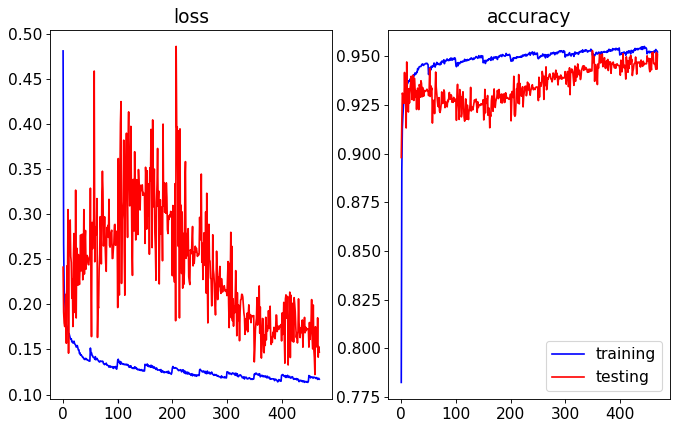

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


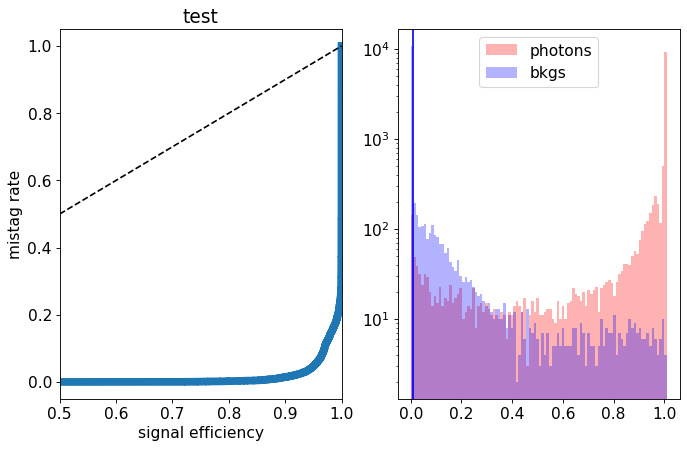

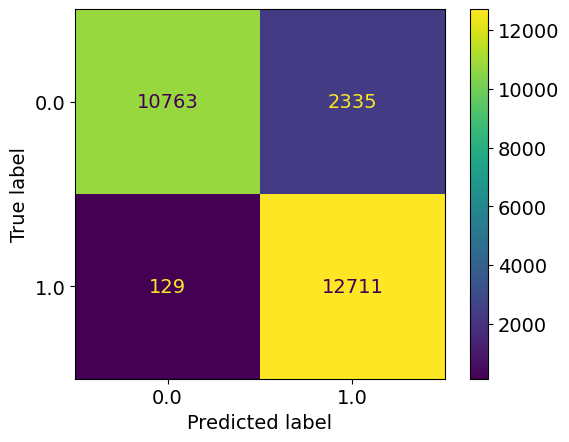

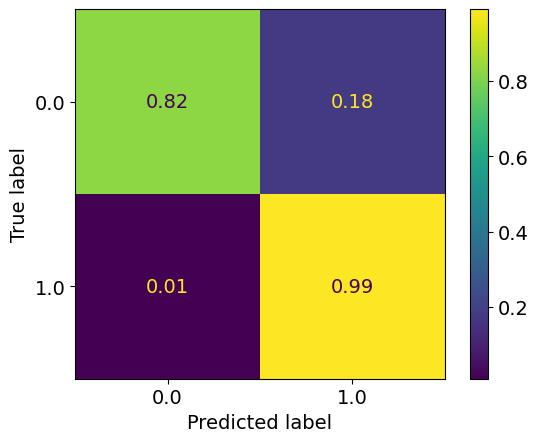

epoch: 470
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.11558184479874682
train acc: 0.9534077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.14it/s]


test loss: 0.18463016572323712
test acc: 0.9445987
epoch: 471
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11653196389620014
train acc: 0.95308


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.20it/s]


test loss: 0.18066194890574974
test acc: 0.94463724
epoch: 472
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.1166231251951587
train acc: 0.95331126


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.88it/s]


test loss: 0.17355014045130124
test acc: 0.9469119
epoch: 473
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.11652110392130868
train acc: 0.9531185


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.17it/s]


test loss: 0.15302124246954918
test acc: 0.9469119
epoch: 474
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.11697578408642312
train acc: 0.9530607


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.18814143182879145
test acc: 0.94436735
epoch: 475
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11640167822038507
train acc: 0.95328236


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.19it/s]


test loss: 0.144385859539563
test acc: 0.94818413
epoch: 476
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.22it/s]


train loss: 0.11672111742758337
train acc: 0.95294505


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.16333522512154144
test acc: 0.94683474
epoch: 477
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.11542677595091692
train acc: 0.95337874


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.00it/s]


test loss: 0.17487312379208478
test acc: 0.9468733
epoch: 478
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.1150502363553626
train acc: 0.9540631


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.02it/s]


test loss: 0.20255899632518942
test acc: 0.9444059
epoch: 479
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.11423920349061834
train acc: 0.95412093


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.18it/s]


test loss: 0.17044237764044243
test acc: 0.94602513


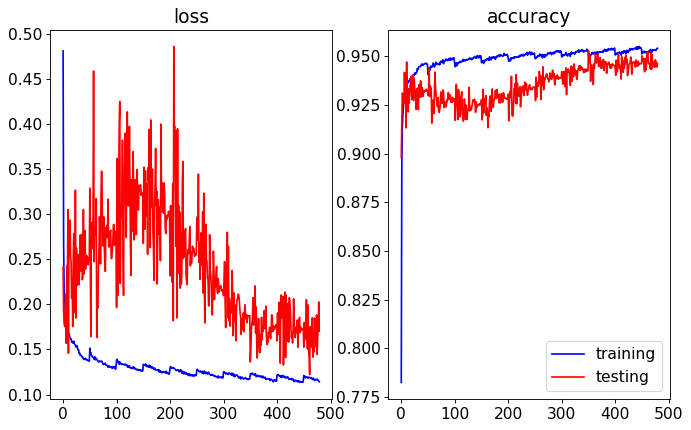

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.24it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


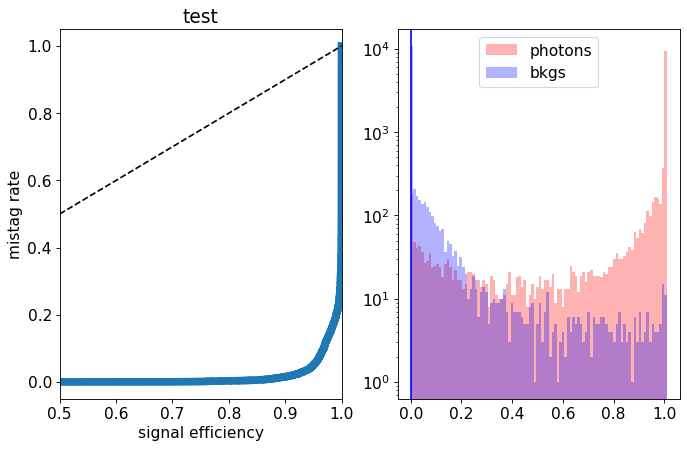

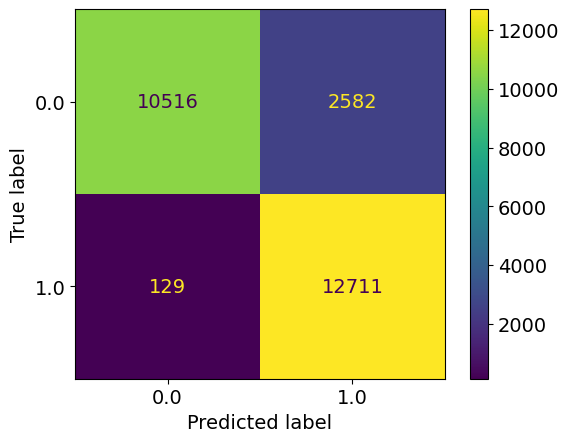

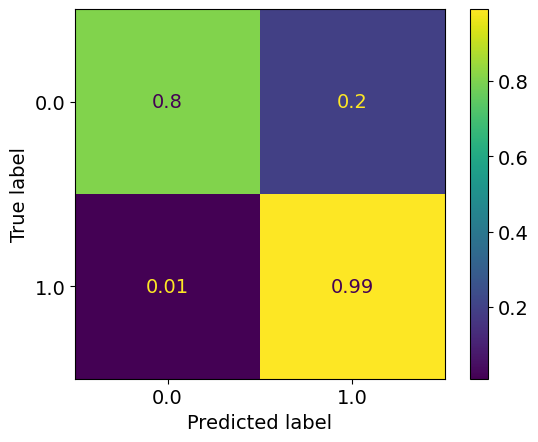

epoch: 480
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.11332865300550626
train acc: 0.95397633


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.16956318931823428
test acc: 0.9484926
epoch: 481
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.11334546384094768
train acc: 0.9541402


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.17136076295917685
test acc: 0.94668055
epoch: 482
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11452299907717402
train acc: 0.95396674


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.17280675436962734
test acc: 0.9467962
epoch: 483
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.11405551847005856
train acc: 0.9544583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.19293346950276333
test acc: 0.9447143
epoch: 484
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.1150286824716998
train acc: 0.9539282


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.16316145793958145
test acc: 0.9454083
epoch: 485
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.27it/s]


train loss: 0.11312530986490967
train acc: 0.95465106


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.15705812671645122
test acc: 0.9463336
epoch: 486
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.11353586295436573
train acc: 0.9546703


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.14592897570268673
test acc: 0.9514612
epoch: 487
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.11317976727823302
train acc: 0.9545739


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.16059151122515852
test acc: 0.94610226
epoch: 488
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11301561509598197
train acc: 0.95465106


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.66it/s]


test loss: 0.1705586685037071
test acc: 0.94587094
epoch: 489
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.19it/s]


train loss: 0.11213128919029511
train acc: 0.95520043


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.32it/s]


test loss: 0.16817960566417736
test acc: 0.9472974


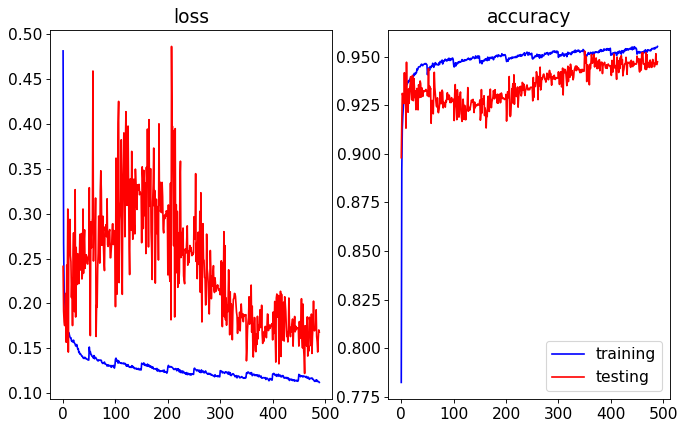

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.37it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


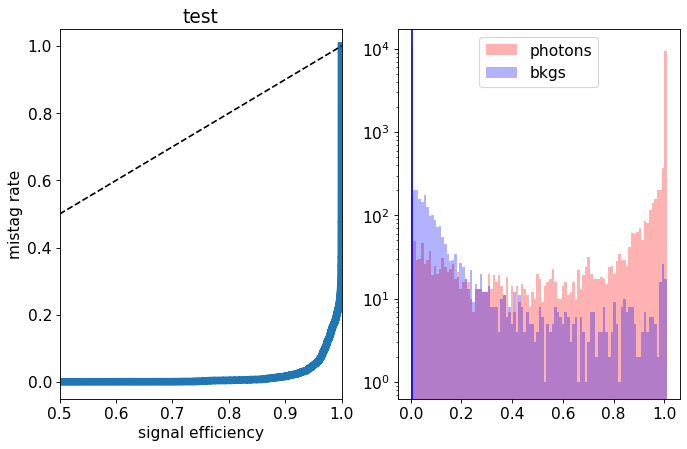

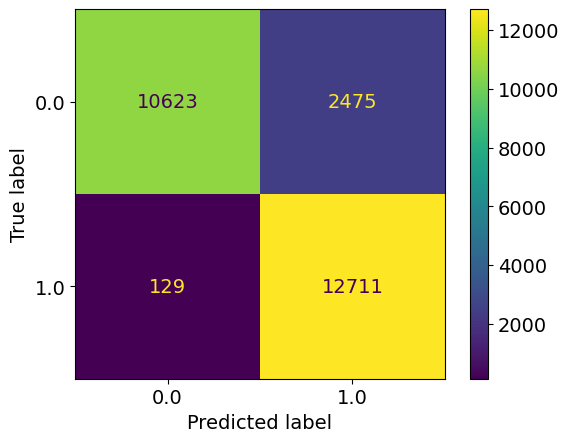

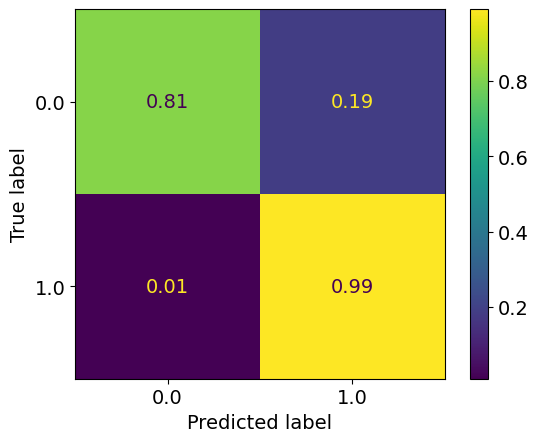

epoch: 490
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.11297024144774917
train acc: 0.9544679


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.16117459383200516
test acc: 0.94760585
epoch: 491
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.11342006650446468
train acc: 0.95460284


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.00it/s]


test loss: 0.16621280698613686
test acc: 0.94575524
epoch: 492
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.11273387505139919
train acc: 0.9551812


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.1712000539357012
test acc: 0.9455239
epoch: 493
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11299270357010681
train acc: 0.9545161


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]


test loss: 0.16177128526297482
test acc: 0.94710463
epoch: 494
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.11210956118699443
train acc: 0.95490164


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.1686650628054684
test acc: 0.94617933
epoch: 495
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.11271455668645099
train acc: 0.95436186


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.99it/s]


test loss: 0.16270418634468858
test acc: 0.9465649
epoch: 496
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.11208316360767177
train acc: 0.9550173


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.17it/s]


test loss: 0.16425350240685724
test acc: 0.9474516
epoch: 497
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11168572375540099
train acc: 0.9548535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.17it/s]


test loss: 0.16667474213648925
test acc: 0.9467191
epoch: 498
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.11202912054137687
train acc: 0.95508474


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.14it/s]


test loss: 0.1653918210755695
test acc: 0.9464492
epoch: 499
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.11304871277140745
train acc: 0.95462215


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.19it/s]


test loss: 0.16509056006642905
test acc: 0.9464492


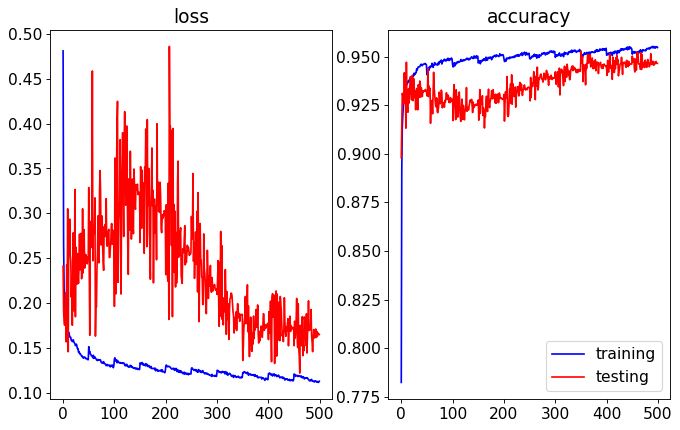

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.96it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


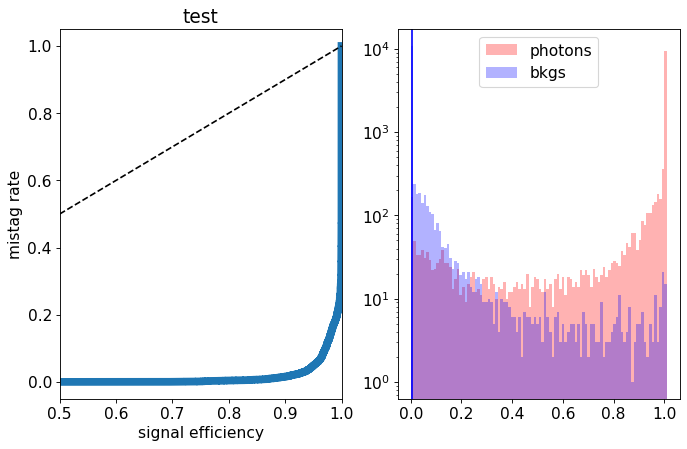

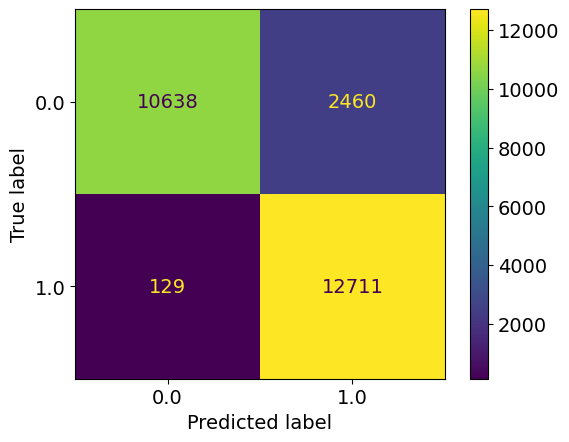

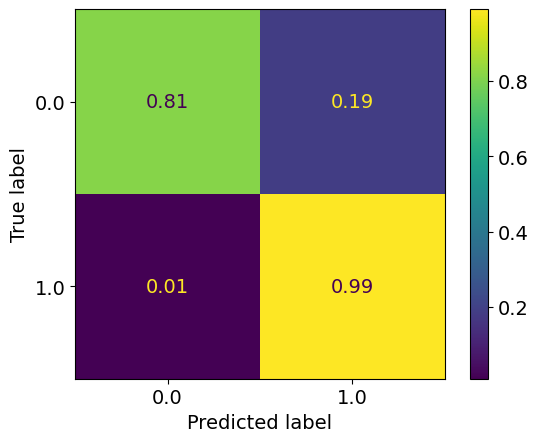

In [15]:
from tqdm import tqdm as tqdm


checkpoint_dir ="/home/llr/cms/cappati/HGC_models/PID_phopi/trainings/outdir_models_30-70_wLowptpho_dropout0p3"
os.makedirs(checkpoint_dir, exist_ok=True)


nepoch=500
best_loss = 99999999
best_acc = 0.
losst = []
lossv = []
acct = []
accv = []
epochs = []
for epoch in range(nepoch):
    print ('epoch:',epoch)
    print("Learning rate:", optimizer.param_groups[0]['lr'])
    loss_t, acc_t = train(epoch)
    losst.append(loss_t)
    acct.append(acc_t)
    loss_v, acc_v = test(epoch)
    loss_epoch = loss_v
    lossv.append(loss_epoch)
    accv.append(acc_v)
    epochs.append(epoch)

    
     
    
    checkpoint = {
    'epoch': epoch + 1,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
    }
    checkpoint_file = 'model_epoch_%i.pth.tar' % ( epoch )
    torch.save(checkpoint,
                   os.path.join(checkpoint_dir,checkpoint_file ))
    
#     if loss_epoch < best_loss:
#         best_loss = loss_epoch
#         print('new best test loss:',best_loss)
#         torch.save(checkpoint,
#                    os.path.join(checkpoint_dir,'model_checkpoint_best.pth.tar' ))
    
    
    if acc_v > best_acc:
        print('new best acc:',acc_v)
        best_acc = acc_v
        torch.save(checkpoint,
                   os.path.join(checkpoint_dir,'model_checkpoint_bestacc.pth.tar' ))
    
    if ((epoch+1)%10 == 0):
        fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10, 6),dpi=80)
        
        ax0.plot(np.array(epochs),np.array(losst),c='b',label='training')
        ax0.plot(np.array(epochs),np.array(lossv),c='r',label='testing')
        ax0.title.set_text("loss")
        #if ((epoch+1) == nepoch):
        #    plt.savefig('%s/TrainvsValLoss_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        #plt.legend()
        #plt.show()
        ax1.plot(np.array(epochs),np.array(acct),c='b',label='training')
        ax1.plot(np.array(epochs),np.array(accv),c='r',label='testing')
        ax1.title.set_text("accuracy")
        plt.legend()
        #if ((epoch+1) == nepoch):
        #    plt.savefig('%s/TrainvsValLoss_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        plt.show()
        
        
        model.eval()
        scores = []
        trues = []
        true_preds, num_preds = 0., 0.
        for data in tqdm(testloader): ### change to loaderDNN for DNN
                datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
                optimizer.zero_grad()
                #label = label.to(torch.long).squeeze()
                result = model(datax, masks, info3d)
                scores.append(torch.exp(result)[:,1].detach().cpu().flatten().numpy())
                trues.append(label.detach().cpu().numpy().flatten())
        
        
        truesa = np.hstack(trues)
        scoresa = np.hstack(scores)
        fpr, tpr, thresholds = metrics.roc_curve(truesa, scoresa, pos_label=1)
        aucv = metrics.auc(fpr, tpr)

        tpr90,fpr90,threshold90 = 0,0,0
        for i,j,k in zip(tpr,fpr,thresholds):
            if i >0.99:
                tpr90 = i
                fpr90 = j
                threshold90 = k
                break

        fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10, 6),dpi=80)
        plt.rcParams['font.size'] = '14'
        ax0.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
        ax0.set_xlabel("signal efficiency")
        ax0.set_ylabel("mistag rate")
        ax0.set_xlim([0.5,1])
        ax0.plot([0.,1], [0.,1], 'k--')
        ax0.title.set_text("test")
        plt.legend()
        #ax.text(0.6,0.6,aucv,)
        #plt.yscale("log")
        
        ax1.hist(scoresa[truesa == 1],bins=100, range=[0,1.01], label='photons',linewidth=2.0, color="r" , alpha=0.3)
        ax1.hist(scoresa[truesa == 0],bins=100, range=[0,1.01], label='bkgs',linewidth=2.0, color="b", alpha=0.3 )
        ax1.axvline(threshold90,c="b")
        plt.yscale("log")
        plt.legend()
        plt.show()

        
        
        
        
        
        ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0))
        plt.show()
        ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0), normalize="true")
        plt.show()
        

In [16]:
#print(epoch_size)

In [17]:
device = torch.device('cuda:1')
model.to(device)
model.eval()
scores = []
trues = []
true_preds, num_preds = 0., 0.
for data in tqdm(testloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        optimizer.zero_grad()
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        scores.append(torch.exp(result)[:,1].detach().cpu().flatten().numpy())
        trues.append(label.detach().cpu().numpy().flatten())
        #break

  2%|██▋                                                                                                                 | 1/44 [00:00<00:19,  2.24it/s]/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/nn/modules/module.py:1501: UserWarning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
 (Triggered internally at ../third_party/nvfuser/csrc/manager.cpp:335.)
  return forward_call(*args, **kwargs)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.08it/s]


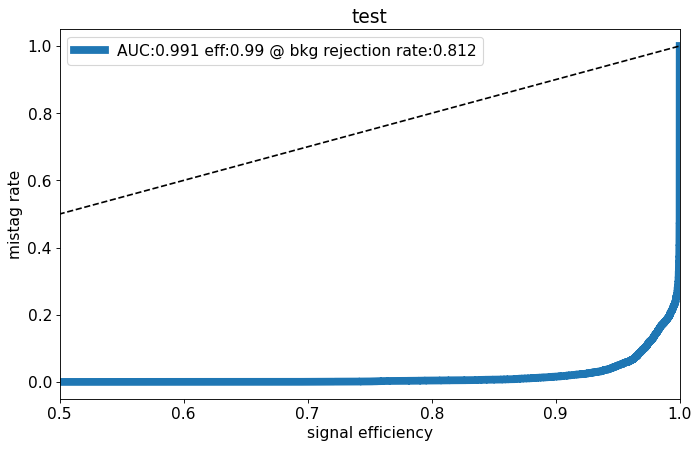

In [18]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.hstack(trues), np.hstack(scores), pos_label=1)
aucv = metrics.auc(fpr, tpr)

tpr90,fpr90,threshold90 = 0,0,0
for i,j,k in zip(tpr,fpr,thresholds):
    if i >0.99:
        tpr90 = i
        fpr90 = j
        threshold90 = k
        break

fig, ax = plt.subplots(figsize=(10, 6),dpi=80)
plt.rcParams['font.size'] = '14'
ax.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
ax.set_xlabel("signal efficiency")
ax.set_ylabel("mistag rate")
ax.set_xlim([0.5,1])
ax.plot([0.,1], [0.,1], 'k--')
ax.title.set_text("test")
#ax.text(0.6,0.6,aucv,)
#plt.yscale("log")
plt.legend()
plt.show()

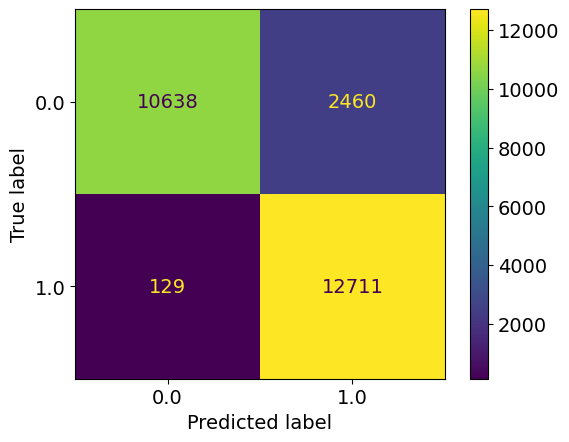

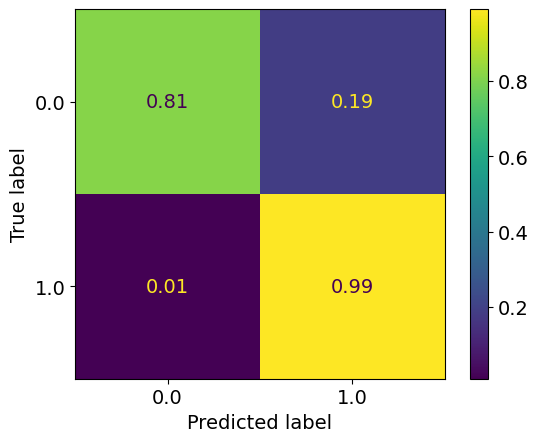

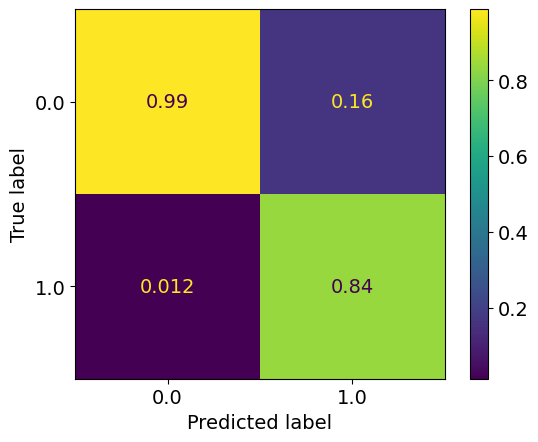

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#confusion_matrix(np.hstack(trues), np.where(np.hstack(scores)>0.5, 1, 0))

ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0))
plt.show()
ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0), normalize="true")
plt.show()
ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0), normalize="pred")
plt.show()